# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [1]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [3]:
datasets, vocab = load_wikitext()

--2020-11-16 13:09:37--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.26.197
Connecting to nyu.box.com (nyu.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-11-16 13:09:37--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-11-16 13:09:38--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.26.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.26.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [4]:
from tqdm import tqdm

class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [5]:
wiki_dataset = datasets
wiki_dict = Dictionary(wiki_dataset, include_valid=True)

100%|██████████| 8464/8464 [00:09<00:00, 920.64it/s]


In [6]:
print(len(wiki_dict))
for i in range(10):
    print(i, wiki_dict.get_token(i))

33181
0 <bos>
1 <eos>
2 <pad>
3 <unk>
4 Valkyria
5 of
6 the
7 Battlefield
8 3
9 )


In [7]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [8]:
from torch.utils.data import Dataset, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [9]:
wiki_tokenized_datasets = tokenize_dataset(wiki_dataset, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 138186.48it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [10]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [11]:
wiki_loaders = {}

batch_size = 128

for split, wiki_dataset in wiki_tensor_dataset.items():
    wiki_loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

#### Model + Training (5 pts)

In [12]:
class LstmRNN(nn.Module):
    def __init__(self, options):
        super().__init__()
        
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers']) 
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
 
    def forward(self, encoded_input_sequence):
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [13]:
# Create a model if we do not want to use pretrained model

load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wiki_lstm_1.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wiki_lstm_1.pt', map_location=current_device)
    
    options = model_dict['options']
    model = LstmRNN(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    hyper_para = [[256, 256, 3], # input_size, hidden_size, num_layers
                  [256, 256, 5], # more layers
                  [256, 512, 3], # larger hidden size
                  [256, 512, 5] # more layers and larger hidden size
                 ]
    
    options_sets = []
    models = []
    for i in range(4):
        options = {
            'num_embeddings': len(wiki_dict),
            'embedding_dim': hyper_para[i][0],
            'padding_idx': wiki_dict.get_id('<pad>'),
            'input_size': hyper_para[i][0],
            'hidden_size': hyper_para[i][1],
            'num_layers': hyper_para[i][2]
        }
        
        model = LstmRNN(options).to(current_device)
        
        options_sets.append(options)
        models.append(model)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'))

In [ ]:
models

[LstmRNN(
   (lookup): Embedding(33181, 256, padding_idx=2)
   (lstm): LSTM(256, 256, num_layers=3)
   (projection): Linear(in_features=256, out_features=33181, bias=True)
 ), LstmRNN(
   (lookup): Embedding(33181, 256, padding_idx=2)
   (lstm): LSTM(256, 256, num_layers=5)
   (projection): Linear(in_features=256, out_features=33181, bias=True)
 ), LstmRNN(
   (lookup): Embedding(33181, 256, padding_idx=2)
   (lstm): LSTM(256, 512, num_layers=3)
   (projection): Linear(in_features=512, out_features=33181, bias=True)
 ), LstmRNN(
   (lookup): Embedding(33181, 256, padding_idx=2)
   (lstm): LSTM(256, 512, num_layers=5)
   (projection): Linear(in_features=512, out_features=33181, bias=True)
 )]

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Model 1

input_size = 256, hidden_size = 256, num_layers = 3

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
import torch.optim as optim

model = models[0]
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

plot_cache = []
max_patience = 3
epochs_no_improve = 0
early_stop = False
last_val_loss = 100

for epoch_number in range(100):
    print(epoch_number)
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['train'])):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['valid'])):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    if avg_val_loss < last_val_loss:
  # Save the model
             #torch.save(model)
             best_model = model
             best_plot_cache = plot_cache
             epochs_no_improve = 0
    else:
      epochs_no_improve += 1
    
    last_val_loss = avg_val_loss

    if epoch_number > 2 and epochs_no_improve >= max_patience:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
    break
    
    if early_stop:
        print("Stopped")
        break
    
    if load_pretrained:
        break

0it [00:00, ?it/s]

0


1it [00:00,  3.19it/s]

Step 0 avg train loss = 10.2034


102it [00:20,  5.20it/s]

Step 100 avg train loss = 10.1378


202it [00:41,  5.03it/s]

Step 200 avg train loss = 9.4145


301it [01:01,  4.92it/s]

Step 300 avg train loss = 8.5792


402it [01:22,  4.80it/s]

Step 400 avg train loss = 8.3822


501it [01:43,  4.55it/s]

Step 500 avg train loss = 8.0142


601it [02:05,  4.61it/s]

Step 600 avg train loss = 7.9626


612it [02:07,  4.78it/s]
67it [00:05, 12.28it/s]
0it [00:00, ?it/s]

Validation loss after 0 epoch = 7.8175
1


1it [00:00,  4.65it/s]

Step 0 avg train loss = 7.9155


101it [00:21,  4.75it/s]

Step 100 avg train loss = 7.8507


201it [00:42,  4.70it/s]

Step 200 avg train loss = 7.8016


301it [01:04,  4.57it/s]

Step 300 avg train loss = 7.7328


401it [01:26,  4.52it/s]

Step 400 avg train loss = 7.7209


502it [01:49,  5.11it/s]

Step 500 avg train loss = 7.6827


601it [02:10,  4.90it/s]

Step 600 avg train loss = 7.6199


612it [02:13,  4.59it/s]
67it [00:05, 11.77it/s]
0it [00:00, ?it/s]

Validation loss after 1 epoch = 7.4760
2


1it [00:00,  3.60it/s]

Step 0 avg train loss = 7.6431


102it [00:22,  5.23it/s]

Step 100 avg train loss = 7.6054


201it [00:43,  5.29it/s]

Step 200 avg train loss = 7.5491


302it [01:05,  4.95it/s]

Step 300 avg train loss = 7.5073


401it [01:27,  4.46it/s]

Step 400 avg train loss = 7.4629


501it [01:49,  4.34it/s]

Step 500 avg train loss = 7.3917


601it [02:11,  5.16it/s]

Step 600 avg train loss = 7.3424


612it [02:13,  4.57it/s]
67it [00:05, 11.73it/s]
0it [00:00, ?it/s]

Validation loss after 2 epoch = 7.1655
3


1it [00:00,  3.30it/s]

Step 0 avg train loss = 7.3141


102it [00:22,  4.71it/s]

Step 100 avg train loss = 7.2882


202it [00:44,  5.13it/s]

Step 200 avg train loss = 7.2584


301it [01:06,  4.52it/s]

Step 300 avg train loss = 7.2196


401it [01:28,  4.76it/s]

Step 400 avg train loss = 7.2024


502it [01:50,  4.48it/s]

Step 500 avg train loss = 7.1575


601it [02:11,  5.13it/s]

Step 600 avg train loss = 7.1363


612it [02:14,  4.56it/s]
67it [00:05, 11.78it/s]
1it [00:00,  5.04it/s]

Validation loss after 3 epoch = 6.9577
4
Step 0 avg train loss = 7.1912


102it [00:22,  4.86it/s]

Step 100 avg train loss = 7.0979


201it [00:43,  4.69it/s]

Step 200 avg train loss = 7.0733


301it [01:06,  4.04it/s]

Step 300 avg train loss = 7.0464


402it [01:28,  4.51it/s]

Step 400 avg train loss = 7.0067


501it [01:50,  4.53it/s]

Step 500 avg train loss = 6.9859


601it [02:12,  4.32it/s]

Step 600 avg train loss = 6.9716


612it [02:14,  4.54it/s]
67it [00:05, 11.72it/s]
0it [00:00, ?it/s]

Validation loss after 4 epoch = 6.7813
5


2it [00:00,  4.62it/s]

Step 0 avg train loss = 6.9859


102it [00:22,  5.05it/s]

Step 100 avg train loss = 6.9414


202it [00:44,  4.63it/s]

Step 200 avg train loss = 6.9187


302it [01:06,  4.93it/s]

Step 300 avg train loss = 6.8952


402it [01:27,  5.16it/s]

Step 400 avg train loss = 6.8748


501it [01:50,  4.28it/s]

Step 500 avg train loss = 6.8505


602it [02:12,  4.93it/s]

Step 600 avg train loss = 6.8330


612it [02:14,  4.55it/s]
67it [00:05, 11.89it/s]
1it [00:00,  5.47it/s]

Validation loss after 5 epoch = 6.6571
6
Step 0 avg train loss = 6.8466


102it [00:22,  4.56it/s]

Step 100 avg train loss = 6.8074


202it [00:44,  4.92it/s]

Step 200 avg train loss = 6.7983


301it [01:06,  4.22it/s]

Step 300 avg train loss = 6.7703


402it [01:28,  5.03it/s]

Step 400 avg train loss = 6.7676


502it [01:50,  5.05it/s]

Step 500 avg train loss = 6.7405


602it [02:12,  4.33it/s]

Step 600 avg train loss = 6.7229


612it [02:14,  4.55it/s]
67it [00:05, 11.86it/s]
1it [00:00,  5.23it/s]

Validation loss after 6 epoch = 6.5441
7
Step 0 avg train loss = 6.6760


102it [00:23,  4.85it/s]

Step 100 avg train loss = 6.7053


201it [00:44,  4.44it/s]

Step 200 avg train loss = 6.6945


302it [01:06,  4.49it/s]

Step 300 avg train loss = 6.6782


401it [01:28,  4.66it/s]

Step 400 avg train loss = 6.6654


501it [01:50,  4.94it/s]

Step 500 avg train loss = 6.6545


602it [02:12,  4.68it/s]

Step 600 avg train loss = 6.6354


612it [02:14,  4.55it/s]
67it [00:05, 11.78it/s]
0it [00:00, ?it/s]

Validation loss after 7 epoch = 6.4623
8


1it [00:00,  3.57it/s]

Step 0 avg train loss = 6.5830


101it [00:22,  4.37it/s]

Step 100 avg train loss = 6.6295


201it [00:44,  4.60it/s]

Step 200 avg train loss = 6.6250


301it [01:05,  5.14it/s]

Step 300 avg train loss = 6.5948


401it [01:28,  4.67it/s]

Step 400 avg train loss = 6.5907


502it [01:50,  4.58it/s]

Step 500 avg train loss = 6.5822


602it [02:12,  5.18it/s]

Step 600 avg train loss = 6.5666


612it [02:14,  4.55it/s]
67it [00:05, 11.84it/s]
1it [00:00,  5.36it/s]

Validation loss after 8 epoch = 6.3950
9
Step 0 avg train loss = 6.5868


101it [00:21,  4.36it/s]

Step 100 avg train loss = 6.5647


201it [00:43,  4.48it/s]

Step 200 avg train loss = 6.5472


301it [01:05,  4.83it/s]

Step 300 avg train loss = 6.5410


402it [01:27,  4.69it/s]

Step 400 avg train loss = 6.5232


501it [01:49,  4.75it/s]

Step 500 avg train loss = 6.5221


601it [02:11,  4.50it/s]

Step 600 avg train loss = 6.5178


612it [02:13,  4.57it/s]
67it [00:05, 11.85it/s]
0it [00:00, ?it/s]

Validation loss after 9 epoch = 6.3375
10


2it [00:00,  4.59it/s]

Step 0 avg train loss = 6.4313


101it [00:22,  4.80it/s]

Step 100 avg train loss = 6.5135


201it [00:44,  4.59it/s]

Step 200 avg train loss = 6.4925


302it [01:06,  4.79it/s]

Step 300 avg train loss = 6.4825


401it [01:28,  4.58it/s]

Step 400 avg train loss = 6.4785


501it [01:50,  3.88it/s]

Step 500 avg train loss = 6.4752


601it [02:12,  4.59it/s]

Step 600 avg train loss = 6.4661


612it [02:14,  4.55it/s]
67it [00:05, 11.72it/s]
1it [00:00,  5.23it/s]

Validation loss after 10 epoch = 6.2977
11
Step 0 avg train loss = 6.4173


102it [00:21,  4.65it/s]

Step 100 avg train loss = 6.4556


201it [00:43,  4.44it/s]

Step 200 avg train loss = 6.4513


302it [01:06,  5.20it/s]

Step 300 avg train loss = 6.4407


401it [01:28,  4.59it/s]

Step 400 avg train loss = 6.4373


501it [01:50,  5.07it/s]

Step 500 avg train loss = 6.4264


601it [02:12,  4.88it/s]

Step 600 avg train loss = 6.4266


612it [02:14,  4.55it/s]
67it [00:05, 11.96it/s]
1it [00:00,  5.71it/s]

Validation loss after 11 epoch = 6.2531
12
Step 0 avg train loss = 6.3884


101it [00:22,  4.94it/s]

Step 100 avg train loss = 6.4169


201it [00:43,  4.90it/s]

Step 200 avg train loss = 6.4058


302it [01:06,  5.17it/s]

Step 300 avg train loss = 6.3962


402it [01:28,  4.80it/s]

Step 400 avg train loss = 6.3947


501it [01:50,  4.40it/s]

Step 500 avg train loss = 6.3903


602it [02:11,  4.80it/s]

Step 600 avg train loss = 6.3908


612it [02:14,  4.56it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 12 epoch = 6.2181
13


1it [00:00,  4.19it/s]

Step 0 avg train loss = 6.3606


101it [00:22,  4.82it/s]

Step 100 avg train loss = 6.3709


202it [00:44,  4.89it/s]

Step 200 avg train loss = 6.3646


301it [01:06,  4.61it/s]

Step 300 avg train loss = 6.3630


401it [01:27,  4.31it/s]

Step 400 avg train loss = 6.3594


501it [01:50,  4.19it/s]

Step 500 avg train loss = 6.3576


602it [02:12,  5.05it/s]

Step 600 avg train loss = 6.3434


612it [02:14,  4.56it/s]
67it [00:05, 12.01it/s]
0it [00:00, ?it/s]

Validation loss after 13 epoch = 6.1786
14


1it [00:00,  5.04it/s]

Step 0 avg train loss = 6.3342


101it [00:21,  4.53it/s]

Step 100 avg train loss = 6.3354


201it [00:43,  4.55it/s]

Step 200 avg train loss = 6.3280


301it [01:06,  4.18it/s]

Step 300 avg train loss = 6.3279


402it [01:28,  5.11it/s]

Step 400 avg train loss = 6.3240


502it [01:50,  4.37it/s]

Step 500 avg train loss = 6.3079


602it [02:12,  4.43it/s]

Step 600 avg train loss = 6.3123


612it [02:14,  4.55it/s]
67it [00:05, 11.91it/s]
0it [00:00, ?it/s]

Validation loss after 14 epoch = 6.1460
15


2it [00:00,  4.61it/s]

Step 0 avg train loss = 6.3202


101it [00:22,  4.90it/s]

Step 100 avg train loss = 6.2907


201it [00:43,  4.60it/s]

Step 200 avg train loss = 6.2921


301it [01:06,  4.53it/s]

Step 300 avg train loss = 6.2966


402it [01:27,  4.67it/s]

Step 400 avg train loss = 6.2839


501it [01:49,  4.28it/s]

Step 500 avg train loss = 6.2725


602it [02:11,  5.23it/s]

Step 600 avg train loss = 6.2736


612it [02:13,  4.58it/s]
67it [00:05, 11.88it/s]
1it [00:00,  5.14it/s]

Validation loss after 15 epoch = 6.1120
16
Step 0 avg train loss = 6.3030


101it [00:22,  4.32it/s]

Step 100 avg train loss = 6.2573


201it [00:44,  4.51it/s]

Step 200 avg train loss = 6.2518


302it [01:06,  5.03it/s]

Step 300 avg train loss = 6.2495


401it [01:28,  3.74it/s]

Step 400 avg train loss = 6.2423


501it [01:50,  4.18it/s]

Step 500 avg train loss = 6.2398


601it [02:12,  4.21it/s]

Step 600 avg train loss = 6.2407


612it [02:14,  4.55it/s]
67it [00:05, 11.69it/s]
0it [00:00, ?it/s]

Validation loss after 16 epoch = 6.0770
17


1it [00:00,  4.36it/s]

Step 0 avg train loss = 6.1451


101it [00:22,  4.51it/s]

Step 100 avg train loss = 6.2315


201it [00:44,  4.71it/s]

Step 200 avg train loss = 6.2244


301it [01:07,  4.75it/s]

Step 300 avg train loss = 6.2147


401it [01:28,  4.66it/s]

Step 400 avg train loss = 6.2024


501it [01:50,  4.12it/s]

Step 500 avg train loss = 6.2069


601it [02:12,  4.83it/s]

Step 600 avg train loss = 6.1874


612it [02:15,  4.53it/s]
67it [00:05, 11.66it/s]
1it [00:00,  5.27it/s]

Validation loss after 17 epoch = 6.0440
18
Step 0 avg train loss = 6.1223


101it [00:22,  4.40it/s]

Step 100 avg train loss = 6.1857


201it [00:43,  4.47it/s]

Step 200 avg train loss = 6.1868


301it [01:05,  4.42it/s]

Step 300 avg train loss = 6.1815


401it [01:28,  4.25it/s]

Step 400 avg train loss = 6.1785


502it [01:50,  4.74it/s]

Step 500 avg train loss = 6.1651


601it [02:12,  3.98it/s]

Step 600 avg train loss = 6.1685


612it [02:14,  4.55it/s]
67it [00:05, 11.93it/s]
1it [00:00,  5.45it/s]

Validation loss after 18 epoch = 6.0167
19
Step 0 avg train loss = 6.1175


102it [00:22,  4.81it/s]

Step 100 avg train loss = 6.1573


201it [00:43,  4.72it/s]

Step 200 avg train loss = 6.1589


301it [01:05,  5.02it/s]

Step 300 avg train loss = 6.1481


401it [01:28,  4.70it/s]

Step 400 avg train loss = 6.1461


501it [01:50,  4.37it/s]

Step 500 avg train loss = 6.1408


602it [02:12,  4.81it/s]

Step 600 avg train loss = 6.1300


612it [02:14,  4.55it/s]
67it [00:05, 12.00it/s]
0it [00:00, ?it/s]

Validation loss after 19 epoch = 5.9882
20


2it [00:00,  4.86it/s]

Step 0 avg train loss = 6.0990


101it [00:22,  4.82it/s]

Step 100 avg train loss = 6.1233


201it [00:44,  4.61it/s]

Step 200 avg train loss = 6.1261


301it [01:07,  4.28it/s]

Step 300 avg train loss = 6.1194


401it [01:28,  4.58it/s]

Step 400 avg train loss = 6.1173


501it [01:50,  5.43it/s]

Step 500 avg train loss = 6.1135


601it [02:11,  4.56it/s]

Step 600 avg train loss = 6.1133


612it [02:14,  4.56it/s]
67it [00:05, 11.99it/s]
0it [00:00, ?it/s]

Validation loss after 20 epoch = 5.9700
21


1it [00:00,  4.94it/s]

Step 0 avg train loss = 6.1428


102it [00:22,  5.02it/s]

Step 100 avg train loss = 6.1085


201it [00:44,  4.32it/s]

Step 200 avg train loss = 6.1030


302it [01:06,  4.94it/s]

Step 300 avg train loss = 6.1030


401it [01:27,  4.53it/s]

Step 400 avg train loss = 6.0901


502it [01:49,  5.00it/s]

Step 500 avg train loss = 6.0809


601it [02:12,  4.40it/s]

Step 600 avg train loss = 6.0769


612it [02:14,  4.55it/s]
67it [00:05, 11.84it/s]
0it [00:00, ?it/s]

Validation loss after 21 epoch = 5.9511
22


2it [00:00,  4.82it/s]

Step 0 avg train loss = 6.1634


101it [00:22,  4.13it/s]

Step 100 avg train loss = 6.0781


202it [00:44,  4.70it/s]

Step 200 avg train loss = 6.0765


301it [01:05,  4.86it/s]

Step 300 avg train loss = 6.0798


401it [01:27,  4.26it/s]

Step 400 avg train loss = 6.0572


501it [01:50,  4.70it/s]

Step 500 avg train loss = 6.0688


601it [02:12,  4.83it/s]

Step 600 avg train loss = 6.0589


612it [02:14,  4.54it/s]
67it [00:05, 11.66it/s]
0it [00:00, ?it/s]

Validation loss after 22 epoch = 5.9304
23


2it [00:00,  4.82it/s]

Step 0 avg train loss = 6.1507


102it [00:22,  5.09it/s]

Step 100 avg train loss = 6.0617


201it [00:44,  5.04it/s]

Step 200 avg train loss = 6.0479


302it [01:06,  4.49it/s]

Step 300 avg train loss = 6.0507


402it [01:28,  5.05it/s]

Step 400 avg train loss = 6.0318


502it [01:49,  4.71it/s]

Step 500 avg train loss = 6.0355


601it [02:11,  4.40it/s]

Step 600 avg train loss = 6.0494


612it [02:14,  4.56it/s]
67it [00:05, 11.82it/s]
0it [00:00, ?it/s]

Validation loss after 23 epoch = 5.9104
24


1it [00:00,  3.94it/s]

Step 0 avg train loss = 5.9265


102it [00:22,  5.22it/s]

Step 100 avg train loss = 6.0341


202it [00:44,  4.75it/s]

Step 200 avg train loss = 6.0280


302it [01:06,  5.05it/s]

Step 300 avg train loss = 6.0368


401it [01:28,  4.90it/s]

Step 400 avg train loss = 6.0104


501it [01:50,  4.11it/s]

Step 500 avg train loss = 6.0108


602it [02:12,  5.25it/s]

Step 600 avg train loss = 6.0221


612it [02:14,  4.54it/s]
67it [00:05, 11.70it/s]
1it [00:00,  5.56it/s]

Validation loss after 24 epoch = 5.8973
25
Step 0 avg train loss = 5.9530


101it [00:23,  4.93it/s]

Step 100 avg train loss = 6.0099


201it [00:44,  4.78it/s]

Step 200 avg train loss = 6.0067


301it [01:06,  4.04it/s]

Step 300 avg train loss = 6.0037


402it [01:29,  4.50it/s]

Step 400 avg train loss = 6.0011


501it [01:50,  4.48it/s]

Step 500 avg train loss = 6.0078


602it [02:12,  5.11it/s]

Step 600 avg train loss = 5.9929


612it [02:15,  4.53it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 25 epoch = 5.8813
26


1it [00:00,  3.42it/s]

Step 0 avg train loss = 6.0155


101it [00:22,  4.44it/s]

Step 100 avg train loss = 5.9811


201it [00:44,  5.30it/s]

Step 200 avg train loss = 5.9930


301it [01:06,  5.13it/s]

Step 300 avg train loss = 5.9905


401it [01:28,  4.78it/s]

Step 400 avg train loss = 5.9916


502it [01:50,  4.38it/s]

Step 500 avg train loss = 5.9793


602it [02:12,  4.04it/s]

Step 600 avg train loss = 5.9700


612it [02:14,  4.54it/s]
67it [00:05, 11.79it/s]
1it [00:00,  5.85it/s]

Validation loss after 26 epoch = 5.8666
27
Step 0 avg train loss = 5.9318


101it [00:22,  4.61it/s]

Step 100 avg train loss = 5.9676


201it [00:44,  4.63it/s]

Step 200 avg train loss = 5.9631


301it [01:06,  3.70it/s]

Step 300 avg train loss = 5.9687


402it [01:28,  5.21it/s]

Step 400 avg train loss = 5.9665


502it [01:50,  5.12it/s]

Step 500 avg train loss = 5.9642


601it [02:12,  4.65it/s]

Step 600 avg train loss = 5.9680


612it [02:14,  4.54it/s]
67it [00:05, 11.89it/s]
0it [00:00, ?it/s]

Validation loss after 27 epoch = 5.8498
28


2it [00:00,  3.69it/s]

Step 0 avg train loss = 5.8233


101it [00:22,  5.02it/s]

Step 100 avg train loss = 5.9492


201it [00:44,  4.33it/s]

Step 200 avg train loss = 5.9634


302it [01:05,  4.79it/s]

Step 300 avg train loss = 5.9391


402it [01:28,  4.49it/s]

Step 400 avg train loss = 5.9446


501it [01:50,  3.92it/s]

Step 500 avg train loss = 5.9480


602it [02:13,  4.38it/s]

Step 600 avg train loss = 5.9490


612it [02:15,  4.52it/s]
67it [00:05, 11.74it/s]
0it [00:00, ?it/s]

Validation loss after 28 epoch = 5.8407
29


1it [00:00,  2.68it/s]

Step 0 avg train loss = 5.8437


101it [00:21,  4.19it/s]

Step 100 avg train loss = 5.9385


201it [00:44,  4.17it/s]

Step 200 avg train loss = 5.9335


301it [01:06,  4.86it/s]

Step 300 avg train loss = 5.9309


402it [01:28,  4.60it/s]

Step 400 avg train loss = 5.9326


501it [01:50,  4.94it/s]

Step 500 avg train loss = 5.9276


601it [02:12,  4.09it/s]

Step 600 avg train loss = 5.9357


612it [02:15,  4.53it/s]
67it [00:05, 11.82it/s]
0it [00:00, ?it/s]

Validation loss after 29 epoch = 5.8253
30


1it [00:00,  4.49it/s]

Step 0 avg train loss = 5.8941


101it [00:21,  4.39it/s]

Step 100 avg train loss = 5.9174


202it [00:43,  4.64it/s]

Step 200 avg train loss = 5.9194


301it [01:05,  4.32it/s]

Step 300 avg train loss = 5.9171


401it [01:27,  4.79it/s]

Step 400 avg train loss = 5.9208


501it [01:49,  4.71it/s]

Step 500 avg train loss = 5.9073


601it [02:11,  4.93it/s]

Step 600 avg train loss = 5.9157


612it [02:14,  4.55it/s]
67it [00:05, 11.74it/s]
0it [00:00, ?it/s]

Validation loss after 30 epoch = 5.8118
31


2it [00:00,  4.81it/s]

Step 0 avg train loss = 5.8529


101it [00:21,  4.58it/s]

Step 100 avg train loss = 5.9126


201it [00:43,  4.56it/s]

Step 200 avg train loss = 5.9072


301it [01:06,  4.77it/s]

Step 300 avg train loss = 5.8971


402it [01:28,  4.48it/s]

Step 400 avg train loss = 5.9045


501it [01:50,  4.70it/s]

Step 500 avg train loss = 5.8990


601it [02:12,  4.21it/s]

Step 600 avg train loss = 5.8920


612it [02:14,  4.54it/s]
67it [00:05, 11.90it/s]
0it [00:00, ?it/s]

Validation loss after 31 epoch = 5.8008
32


1it [00:00,  4.77it/s]

Step 0 avg train loss = 5.8497


101it [00:22,  4.65it/s]

Step 100 avg train loss = 5.8981


202it [00:44,  4.59it/s]

Step 200 avg train loss = 5.8894


301it [01:06,  4.75it/s]

Step 300 avg train loss = 5.8848


401it [01:28,  4.03it/s]

Step 400 avg train loss = 5.8820


502it [01:50,  4.89it/s]

Step 500 avg train loss = 5.8864


602it [02:12,  4.70it/s]

Step 600 avg train loss = 5.8851


612it [02:14,  4.55it/s]
67it [00:05, 11.64it/s]
0it [00:00, ?it/s]

Validation loss after 32 epoch = 5.7942
33


1it [00:00,  3.99it/s]

Step 0 avg train loss = 5.9281


101it [00:22,  4.58it/s]

Step 100 avg train loss = 5.8750


202it [00:44,  4.98it/s]

Step 200 avg train loss = 5.8768


302it [01:06,  4.76it/s]

Step 300 avg train loss = 5.8688


402it [01:29,  4.42it/s]

Step 400 avg train loss = 5.8798


501it [01:51,  4.84it/s]

Step 500 avg train loss = 5.8745


601it [02:12,  4.44it/s]

Step 600 avg train loss = 5.8722


612it [02:15,  4.53it/s]
67it [00:05, 11.69it/s]
1it [00:00,  5.35it/s]

Validation loss after 33 epoch = 5.7819
34
Step 0 avg train loss = 5.9604


101it [00:22,  4.43it/s]

Step 100 avg train loss = 5.8570


201it [00:44,  3.77it/s]

Step 200 avg train loss = 5.8645


301it [01:05,  4.24it/s]

Step 300 avg train loss = 5.8658


401it [01:27,  4.48it/s]

Step 400 avg train loss = 5.8575


502it [01:50,  4.85it/s]

Step 500 avg train loss = 5.8597


602it [02:12,  4.77it/s]

Step 600 avg train loss = 5.8594


612it [02:14,  4.56it/s]
67it [00:05, 11.85it/s]
0it [00:00, ?it/s]

Validation loss after 34 epoch = 5.7686
35


1it [00:00,  4.39it/s]

Step 0 avg train loss = 5.8489


102it [00:22,  4.85it/s]

Step 100 avg train loss = 5.8464


201it [00:43,  4.69it/s]

Step 200 avg train loss = 5.8477


302it [01:05,  5.07it/s]

Step 300 avg train loss = 5.8432


402it [01:28,  4.77it/s]

Step 400 avg train loss = 5.8483


501it [01:50,  4.74it/s]

Step 500 avg train loss = 5.8520


602it [02:12,  4.58it/s]

Step 600 avg train loss = 5.8492


612it [02:14,  4.54it/s]
67it [00:05, 11.70it/s]
0it [00:00, ?it/s]

Validation loss after 35 epoch = 5.7603
36


1it [00:00,  3.32it/s]

Step 0 avg train loss = 5.7509


101it [00:21,  4.74it/s]

Step 100 avg train loss = 5.8427


201it [00:43,  4.40it/s]

Step 200 avg train loss = 5.8356


301it [01:06,  3.72it/s]

Step 300 avg train loss = 5.8392


401it [01:28,  4.58it/s]

Step 400 avg train loss = 5.8314


501it [01:50,  4.76it/s]

Step 500 avg train loss = 5.8289


601it [02:11,  4.70it/s]

Step 600 avg train loss = 5.8388


612it [02:14,  4.55it/s]
67it [00:05, 11.87it/s]
1it [00:00,  5.06it/s]

Validation loss after 36 epoch = 5.7524
37
Step 0 avg train loss = 5.9421


101it [00:21,  4.99it/s]

Step 100 avg train loss = 5.8240


202it [00:44,  4.96it/s]

Step 200 avg train loss = 5.8326


301it [01:06,  4.15it/s]

Step 300 avg train loss = 5.8271


402it [01:29,  4.94it/s]

Step 400 avg train loss = 5.8191


501it [01:51,  4.31it/s]

Step 500 avg train loss = 5.8181


601it [02:13,  4.31it/s]

Step 600 avg train loss = 5.8230


612it [02:15,  4.51it/s]
67it [00:05, 11.77it/s]
0it [00:00, ?it/s]

Validation loss after 37 epoch = 5.7466
38


2it [00:00,  4.30it/s]

Step 0 avg train loss = 5.8078


101it [00:21,  4.67it/s]

Step 100 avg train loss = 5.8164


202it [00:44,  4.67it/s]

Step 200 avg train loss = 5.8269


302it [01:06,  4.84it/s]

Step 300 avg train loss = 5.8159


401it [01:28,  4.57it/s]

Step 400 avg train loss = 5.8101


501it [01:50,  5.04it/s]

Step 500 avg train loss = 5.8093


601it [02:12,  3.49it/s]

Step 600 avg train loss = 5.7995


612it [02:15,  4.52it/s]
67it [00:05, 11.62it/s]
1it [00:00,  5.55it/s]

Validation loss after 38 epoch = 5.7370
39
Step 0 avg train loss = 5.8251


102it [00:22,  4.44it/s]

Step 100 avg train loss = 5.7926


202it [00:43,  4.91it/s]

Step 200 avg train loss = 5.8013


301it [01:05,  5.02it/s]

Step 300 avg train loss = 5.8056


401it [01:27,  4.56it/s]

Step 400 avg train loss = 5.8085


501it [01:49,  4.44it/s]

Step 500 avg train loss = 5.8049


602it [02:12,  4.70it/s]

Step 600 avg train loss = 5.7970


612it [02:14,  4.55it/s]
67it [00:05, 11.75it/s]
0it [00:00, ?it/s]

Validation loss after 39 epoch = 5.7358
40


2it [00:00,  4.68it/s]

Step 0 avg train loss = 5.8015


101it [00:22,  4.27it/s]

Step 100 avg train loss = 5.7903


201it [00:44,  4.81it/s]

Step 200 avg train loss = 5.7932


301it [01:06,  4.69it/s]

Step 300 avg train loss = 5.7913


401it [01:28,  4.70it/s]

Step 400 avg train loss = 5.7848


502it [01:50,  5.00it/s]

Step 500 avg train loss = 5.7900


601it [02:12,  4.49it/s]

Step 600 avg train loss = 5.7974


612it [02:14,  4.55it/s]
67it [00:05, 11.73it/s]
0it [00:00, ?it/s]

Validation loss after 40 epoch = 5.7245
41


2it [00:00,  4.03it/s]

Step 0 avg train loss = 5.7693


102it [00:22,  4.43it/s]

Step 100 avg train loss = 5.7799


202it [00:44,  5.13it/s]

Step 200 avg train loss = 5.7836


301it [01:06,  4.97it/s]

Step 300 avg train loss = 5.7868


401it [01:28,  4.56it/s]

Step 400 avg train loss = 5.7757


502it [01:50,  4.52it/s]

Step 500 avg train loss = 5.7855


601it [02:13,  4.47it/s]

Step 600 avg train loss = 5.7734


612it [02:15,  4.51it/s]
67it [00:05, 11.91it/s]
1it [00:00,  5.96it/s]

Validation loss after 41 epoch = 5.7167
42
Step 0 avg train loss = 5.8097


101it [00:22,  4.47it/s]

Step 100 avg train loss = 5.7622


201it [00:44,  3.82it/s]

Step 200 avg train loss = 5.7815


301it [01:06,  4.91it/s]

Step 300 avg train loss = 5.7641


402it [01:29,  4.27it/s]

Step 400 avg train loss = 5.7687


501it [01:50,  4.83it/s]

Step 500 avg train loss = 5.7769


601it [02:12,  4.75it/s]

Step 600 avg train loss = 5.7695


612it [02:14,  4.54it/s]
67it [00:05, 11.69it/s]
1it [00:00,  5.10it/s]

Validation loss after 42 epoch = 5.7115
43
Step 0 avg train loss = 5.5772


101it [00:21,  3.92it/s]

Step 100 avg train loss = 5.7496


202it [00:44,  4.92it/s]

Step 200 avg train loss = 5.7521


301it [01:06,  4.62it/s]

Step 300 avg train loss = 5.7698


401it [01:28,  4.18it/s]

Step 400 avg train loss = 5.7697


501it [01:50,  4.58it/s]

Step 500 avg train loss = 5.7716


601it [02:13,  4.75it/s]

Step 600 avg train loss = 5.7574


612it [02:15,  4.52it/s]
67it [00:05, 11.78it/s]
0it [00:00, ?it/s]

Validation loss after 43 epoch = 5.7093
44


1it [00:00,  3.57it/s]

Step 0 avg train loss = 5.8563


102it [00:23,  4.74it/s]

Step 100 avg train loss = 5.7432


201it [00:45,  3.97it/s]

Step 200 avg train loss = 5.7550


301it [01:07,  4.49it/s]

Step 300 avg train loss = 5.7546


401it [01:29,  4.63it/s]

Step 400 avg train loss = 5.7469


502it [01:51,  4.79it/s]

Step 500 avg train loss = 5.7613


602it [02:13,  4.28it/s]

Step 600 avg train loss = 5.7485


612it [02:15,  4.50it/s]
67it [00:05, 11.56it/s]
0it [00:00, ?it/s]

Validation loss after 44 epoch = 5.6971
45


1it [00:00,  4.05it/s]

Step 0 avg train loss = 5.7724


101it [00:22,  4.58it/s]

Step 100 avg train loss = 5.7472


201it [00:44,  4.63it/s]

Step 200 avg train loss = 5.7383


302it [01:07,  5.05it/s]

Step 300 avg train loss = 5.7386


401it [01:29,  4.80it/s]

Step 400 avg train loss = 5.7474


501it [01:51,  4.34it/s]

Step 500 avg train loss = 5.7430


601it [02:13,  4.03it/s]

Step 600 avg train loss = 5.7454


612it [02:15,  4.52it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 45 epoch = 5.6926
46


1it [00:00,  4.04it/s]

Step 0 avg train loss = 5.7195


102it [00:22,  4.40it/s]

Step 100 avg train loss = 5.7311


201it [00:43,  4.82it/s]

Step 200 avg train loss = 5.7285


301it [01:05,  4.84it/s]

Step 300 avg train loss = 5.7286


401it [01:28,  4.21it/s]

Step 400 avg train loss = 5.7367


501it [01:49,  4.75it/s]

Step 500 avg train loss = 5.7342


601it [02:12,  4.48it/s]

Step 600 avg train loss = 5.7445


612it [02:14,  4.54it/s]
67it [00:05, 11.70it/s]
0it [00:00, ?it/s]

Validation loss after 46 epoch = 5.6919
47


2it [00:00,  5.14it/s]

Step 0 avg train loss = 5.8333


102it [00:22,  4.69it/s]

Step 100 avg train loss = 5.7242


201it [00:43,  4.77it/s]

Step 200 avg train loss = 5.7236


301it [01:06,  4.08it/s]

Step 300 avg train loss = 5.7287


401it [01:29,  4.16it/s]

Step 400 avg train loss = 5.7186


502it [01:51,  4.50it/s]

Step 500 avg train loss = 5.7238


602it [02:13,  5.33it/s]

Step 600 avg train loss = 5.7290


612it [02:15,  4.52it/s]
67it [00:05, 11.70it/s]
0it [00:00, ?it/s]

Validation loss after 47 epoch = 5.6870
48


1it [00:00,  3.57it/s]

Step 0 avg train loss = 5.7384


102it [00:22,  5.00it/s]

Step 100 avg train loss = 5.7193


201it [00:44,  4.10it/s]

Step 200 avg train loss = 5.7089


302it [01:06,  4.48it/s]

Step 300 avg train loss = 5.7137


401it [01:28,  4.57it/s]

Step 400 avg train loss = 5.7124


502it [01:51,  4.95it/s]

Step 500 avg train loss = 5.7188


602it [02:13,  4.95it/s]

Step 600 avg train loss = 5.7261


612it [02:15,  4.52it/s]
67it [00:05, 11.95it/s]
1it [00:00,  5.79it/s]

Validation loss after 48 epoch = 5.6844
49
Step 0 avg train loss = 5.7103


101it [00:21,  5.12it/s]

Step 100 avg train loss = 5.7101


202it [00:44,  4.72it/s]

Step 200 avg train loss = 5.7121


302it [01:06,  4.90it/s]

Step 300 avg train loss = 5.6938


401it [01:27,  4.56it/s]

Step 400 avg train loss = 5.7089


501it [01:49,  4.73it/s]

Step 500 avg train loss = 5.7063


601it [02:12,  5.22it/s]

Step 600 avg train loss = 5.7169


612it [02:14,  4.56it/s]
67it [00:05, 11.92it/s]
1it [00:00,  5.19it/s]

Validation loss after 49 epoch = 5.6773
50
Step 0 avg train loss = 5.8339


101it [00:21,  4.94it/s]

Step 100 avg train loss = 5.7051


201it [00:44,  4.31it/s]

Step 200 avg train loss = 5.6939


301it [01:05,  4.89it/s]

Step 300 avg train loss = 5.7014


402it [01:28,  4.86it/s]

Step 400 avg train loss = 5.7018


502it [01:49,  4.75it/s]

Step 500 avg train loss = 5.6989


601it [02:12,  4.79it/s]

Step 600 avg train loss = 5.7010


612it [02:14,  4.56it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 50 epoch = 5.6671
51


2it [00:00,  3.71it/s]

Step 0 avg train loss = 5.8044


101it [00:21,  4.53it/s]

Step 100 avg train loss = 5.6910


202it [00:43,  4.88it/s]

Step 200 avg train loss = 5.6891


301it [01:05,  4.77it/s]

Step 300 avg train loss = 5.6956


401it [01:27,  4.92it/s]

Step 400 avg train loss = 5.6923


501it [01:49,  4.67it/s]

Step 500 avg train loss = 5.6873


601it [02:12,  4.05it/s]

Step 600 avg train loss = 5.6998


612it [02:15,  4.53it/s]
67it [00:05, 11.75it/s]
1it [00:00,  5.11it/s]

Validation loss after 51 epoch = 5.6632
52
Step 0 avg train loss = 5.6865


102it [00:21,  5.05it/s]

Step 100 avg train loss = 5.6865


201it [00:43,  4.14it/s]

Step 200 avg train loss = 5.6761


301it [01:05,  4.63it/s]

Step 300 avg train loss = 5.6883


401it [01:27,  4.39it/s]

Step 400 avg train loss = 5.6951


501it [01:49,  4.78it/s]

Step 500 avg train loss = 5.6732


601it [02:11,  4.42it/s]

Step 600 avg train loss = 5.6871


612it [02:14,  4.56it/s]
67it [00:05, 11.74it/s]
1it [00:00,  5.58it/s]

Validation loss after 52 epoch = 5.6623
53
Step 0 avg train loss = 5.6089


102it [00:22,  4.85it/s]

Step 100 avg train loss = 5.6808


201it [00:44,  4.00it/s]

Step 200 avg train loss = 5.6790


302it [01:06,  4.73it/s]

Step 300 avg train loss = 5.6771


401it [01:28,  4.12it/s]

Step 400 avg train loss = 5.6642


502it [01:51,  4.96it/s]

Step 500 avg train loss = 5.6796


602it [02:12,  4.78it/s]

Step 600 avg train loss = 5.6866


612it [02:14,  4.56it/s]
67it [00:05, 11.65it/s]
1it [00:00,  5.64it/s]

Validation loss after 53 epoch = 5.6571
54
Step 0 avg train loss = 5.6429


102it [00:21,  5.01it/s]

Step 100 avg train loss = 5.6668


201it [00:44,  4.22it/s]

Step 200 avg train loss = 5.6675


302it [01:06,  4.86it/s]

Step 300 avg train loss = 5.6754


402it [01:28,  4.88it/s]

Step 400 avg train loss = 5.6780


501it [01:49,  4.75it/s]

Step 500 avg train loss = 5.6709


601it [02:11,  4.53it/s]

Step 600 avg train loss = 5.6668


612it [02:14,  4.55it/s]
67it [00:05, 12.00it/s]
0it [00:00, ?it/s]

Validation loss after 54 epoch = 5.6484
55


1it [00:00,  4.08it/s]

Step 0 avg train loss = 5.6214


102it [00:22,  4.72it/s]

Step 100 avg train loss = 5.6640


201it [00:44,  4.26it/s]

Step 200 avg train loss = 5.6585


302it [01:06,  5.06it/s]

Step 300 avg train loss = 5.6645


401it [01:29,  4.54it/s]

Step 400 avg train loss = 5.6755


501it [01:51,  4.41it/s]

Step 500 avg train loss = 5.6614


601it [02:12,  4.64it/s]

Step 600 avg train loss = 5.6607


612it [02:15,  4.53it/s]
67it [00:05, 11.82it/s]
0it [00:00, ?it/s]

Validation loss after 55 epoch = 5.6471
56


1it [00:00,  4.51it/s]

Step 0 avg train loss = 5.6210


102it [00:23,  4.11it/s]

Step 100 avg train loss = 5.6613


201it [00:44,  4.65it/s]

Step 200 avg train loss = 5.6547


301it [01:06,  4.69it/s]

Step 300 avg train loss = 5.6479


401it [01:27,  4.85it/s]

Step 400 avg train loss = 5.6584


501it [01:50,  5.11it/s]

Step 500 avg train loss = 5.6512


602it [02:12,  4.60it/s]

Step 600 avg train loss = 5.6635


612it [02:14,  4.55it/s]
67it [00:05, 11.68it/s]
0it [00:00, ?it/s]

Validation loss after 56 epoch = 5.6436
57


1it [00:00,  3.43it/s]

Step 0 avg train loss = 5.6583


101it [00:22,  4.38it/s]

Step 100 avg train loss = 5.6579


202it [00:44,  4.87it/s]

Step 200 avg train loss = 5.6417


301it [01:06,  3.75it/s]

Step 300 avg train loss = 5.6488


401it [01:27,  5.15it/s]

Step 400 avg train loss = 5.6462


501it [01:49,  4.65it/s]

Step 500 avg train loss = 5.6498


602it [02:11,  4.13it/s]

Step 600 avg train loss = 5.6509


612it [02:14,  4.56it/s]
67it [00:05, 11.72it/s]
0it [00:00, ?it/s]

Validation loss after 57 epoch = 5.6413
58


1it [00:00,  4.23it/s]

Step 0 avg train loss = 5.6851


102it [00:22,  5.02it/s]

Step 100 avg train loss = 5.6411


202it [00:44,  4.88it/s]

Step 200 avg train loss = 5.6471


301it [01:06,  4.67it/s]

Step 300 avg train loss = 5.6467


401it [01:27,  4.32it/s]

Step 400 avg train loss = 5.6393


501it [01:50,  4.95it/s]

Step 500 avg train loss = 5.6338


601it [02:12,  4.61it/s]

Step 600 avg train loss = 5.6479


612it [02:14,  4.55it/s]
67it [00:05, 11.73it/s]
0it [00:00, ?it/s]

Validation loss after 58 epoch = 5.6427
59


1it [00:00,  4.35it/s]

Step 0 avg train loss = 5.7545


101it [00:21,  4.55it/s]

Step 100 avg train loss = 5.6350


202it [00:44,  4.91it/s]

Step 200 avg train loss = 5.6376


301it [01:06,  4.42it/s]

Step 300 avg train loss = 5.6315


402it [01:29,  4.99it/s]

Step 400 avg train loss = 5.6372


501it [01:51,  4.49it/s]

Step 500 avg train loss = 5.6395


601it [02:13,  4.16it/s]

Step 600 avg train loss = 5.6424


612it [02:15,  4.51it/s]
67it [00:05, 12.03it/s]
0it [00:00, ?it/s]

Validation loss after 59 epoch = 5.6367
60


1it [00:00,  4.11it/s]

Step 0 avg train loss = 5.6098


102it [00:22,  4.69it/s]

Step 100 avg train loss = 5.6341


202it [00:44,  5.11it/s]

Step 200 avg train loss = 5.6218


302it [01:05,  5.03it/s]

Step 300 avg train loss = 5.6226


401it [01:28,  3.43it/s]

Step 400 avg train loss = 5.6337


501it [01:49,  4.33it/s]

Step 500 avg train loss = 5.6349


602it [02:12,  4.66it/s]

Step 600 avg train loss = 5.6319


612it [02:14,  4.54it/s]
67it [00:05, 11.92it/s]
0it [00:00, ?it/s]

Validation loss after 60 epoch = 5.6323
61


1it [00:00,  5.07it/s]

Step 0 avg train loss = 5.6487


102it [00:23,  4.69it/s]

Step 100 avg train loss = 5.6107


202it [00:44,  4.53it/s]

Step 200 avg train loss = 5.6244


302it [01:06,  4.96it/s]

Step 300 avg train loss = 5.6328


402it [01:28,  4.33it/s]

Step 400 avg train loss = 5.6326


502it [01:50,  5.04it/s]

Step 500 avg train loss = 5.6168


601it [02:12,  4.02it/s]

Step 600 avg train loss = 5.6208


612it [02:14,  4.55it/s]
67it [00:05, 11.89it/s]
1it [00:00,  5.09it/s]

Validation loss after 61 epoch = 5.6293
62
Step 0 avg train loss = 5.5745


101it [00:22,  4.60it/s]

Step 100 avg train loss = 5.6080


201it [00:44,  4.93it/s]

Step 200 avg train loss = 5.6112


301it [01:06,  4.35it/s]

Step 300 avg train loss = 5.6221


402it [01:28,  4.98it/s]

Step 400 avg train loss = 5.6177


502it [01:50,  4.72it/s]

Step 500 avg train loss = 5.6271


601it [02:12,  3.86it/s]

Step 600 avg train loss = 5.6175


612it [02:14,  4.55it/s]
67it [00:05, 11.73it/s]
0it [00:00, ?it/s]

Validation loss after 62 epoch = 5.6238
63


2it [00:00,  4.52it/s]

Step 0 avg train loss = 5.6010


102it [00:22,  4.76it/s]

Step 100 avg train loss = 5.6153


201it [00:44,  4.76it/s]

Step 200 avg train loss = 5.6146


301it [01:06,  4.98it/s]

Step 300 avg train loss = 5.6136


402it [01:28,  4.60it/s]

Step 400 avg train loss = 5.6014


501it [01:50,  4.33it/s]

Step 500 avg train loss = 5.6118


601it [02:12,  4.45it/s]

Step 600 avg train loss = 5.6139


612it [02:14,  4.54it/s]
67it [00:05, 11.83it/s]
0it [00:00, ?it/s]

Validation loss after 63 epoch = 5.6225
64


2it [00:00,  4.49it/s]

Step 0 avg train loss = 5.4841


101it [00:22,  4.35it/s]

Step 100 avg train loss = 5.5961


202it [00:45,  4.88it/s]

Step 200 avg train loss = 5.6101


301it [01:07,  4.43it/s]

Step 300 avg train loss = 5.6069


402it [01:28,  5.19it/s]

Step 400 avg train loss = 5.6043


502it [01:50,  4.83it/s]

Step 500 avg train loss = 5.6065


601it [02:12,  4.57it/s]

Step 600 avg train loss = 5.6086


612it [02:14,  4.55it/s]
67it [00:05, 11.93it/s]
0it [00:00, ?it/s]

Validation loss after 64 epoch = 5.6201
65


1it [00:00,  3.42it/s]

Step 0 avg train loss = 5.6758


101it [00:22,  4.16it/s]

Step 100 avg train loss = 5.5963


201it [00:43,  4.73it/s]

Step 200 avg train loss = 5.6055


301it [01:05,  4.27it/s]

Step 300 avg train loss = 5.5993


402it [01:28,  4.66it/s]

Step 400 avg train loss = 5.5925


501it [01:50,  4.47it/s]

Step 500 avg train loss = 5.6015


601it [02:11,  4.41it/s]

Step 600 avg train loss = 5.6032


612it [02:14,  4.56it/s]
67it [00:05, 11.74it/s]
1it [00:00,  5.12it/s]

Validation loss after 65 epoch = 5.6203
66
Step 0 avg train loss = 5.6084


102it [00:22,  5.12it/s]

Step 100 avg train loss = 5.5892


201it [00:44,  4.19it/s]

Step 200 avg train loss = 5.5925


302it [01:06,  4.82it/s]

Step 300 avg train loss = 5.5938


401it [01:28,  5.09it/s]

Step 400 avg train loss = 5.5996


502it [01:50,  4.49it/s]

Step 500 avg train loss = 5.5945


601it [02:11,  4.57it/s]

Step 600 avg train loss = 5.5991


612it [02:14,  4.56it/s]
67it [00:05, 11.74it/s]
0it [00:00, ?it/s]

Validation loss after 66 epoch = 5.6134
67


1it [00:00,  4.11it/s]

Step 0 avg train loss = 5.5640


102it [00:22,  5.04it/s]

Step 100 avg train loss = 5.5876


202it [00:43,  4.89it/s]

Step 200 avg train loss = 5.5862


302it [01:06,  4.58it/s]

Step 300 avg train loss = 5.5924


402it [01:28,  4.58it/s]

Step 400 avg train loss = 5.5812


501it [01:50,  4.59it/s]

Step 500 avg train loss = 5.5803


601it [02:12,  4.51it/s]

Step 600 avg train loss = 5.6009


612it [02:14,  4.54it/s]
67it [00:05, 11.78it/s]
1it [00:00,  5.84it/s]

Validation loss after 67 epoch = 5.6080
68
Step 0 avg train loss = 5.6313


101it [00:22,  3.74it/s]

Step 100 avg train loss = 5.5791


201it [00:43,  4.78it/s]

Step 200 avg train loss = 5.5881


301it [01:06,  4.44it/s]

Step 300 avg train loss = 5.5760


401it [01:27,  5.04it/s]

Step 400 avg train loss = 5.5809


501it [01:49,  4.41it/s]

Step 500 avg train loss = 5.5912


602it [02:12,  4.83it/s]

Step 600 avg train loss = 5.5789


612it [02:14,  4.54it/s]
67it [00:05, 11.84it/s]
0it [00:00, ?it/s]

Validation loss after 68 epoch = 5.6113
69


2it [00:00,  4.85it/s]

Step 0 avg train loss = 5.5901


101it [00:21,  4.91it/s]

Step 100 avg train loss = 5.5776


201it [00:43,  4.58it/s]

Step 200 avg train loss = 5.5683


301it [01:05,  4.23it/s]

Step 300 avg train loss = 5.5787


401it [01:28,  4.27it/s]

Step 400 avg train loss = 5.5815


502it [01:50,  4.88it/s]

Step 500 avg train loss = 5.5828


601it [02:12,  4.35it/s]

Step 600 avg train loss = 5.5783


612it [02:14,  4.53it/s]
67it [00:05, 11.76it/s]
0it [00:00, ?it/s]

Validation loss after 69 epoch = 5.6053
70


2it [00:00,  3.89it/s]

Step 0 avg train loss = 5.6716


102it [00:22,  4.70it/s]

Step 100 avg train loss = 5.5750


202it [00:45,  5.01it/s]

Step 200 avg train loss = 5.5710


302it [01:06,  5.00it/s]

Step 300 avg train loss = 5.5645


402it [01:29,  4.67it/s]

Step 400 avg train loss = 5.5675


502it [01:51,  4.88it/s]

Step 500 avg train loss = 5.5834


602it [02:14,  4.45it/s]

Step 600 avg train loss = 5.5694


612it [02:16,  4.50it/s]
67it [00:05, 11.97it/s]
1it [00:00,  5.06it/s]

Validation loss after 70 epoch = 5.6044
71
Step 0 avg train loss = 5.5617


101it [00:22,  4.93it/s]

Step 100 avg train loss = 5.5606


201it [00:44,  4.33it/s]

Step 200 avg train loss = 5.5717


301it [01:06,  4.52it/s]

Step 300 avg train loss = 5.5689


401it [01:29,  4.82it/s]

Step 400 avg train loss = 5.5694


501it [01:50,  4.93it/s]

Step 500 avg train loss = 5.5626


601it [02:12,  4.13it/s]

Step 600 avg train loss = 5.5627


612it [02:14,  4.54it/s]
67it [00:05, 11.78it/s]
1it [00:00,  5.64it/s]

Validation loss after 71 epoch = 5.5989
72
Step 0 avg train loss = 5.5530


101it [00:22,  4.40it/s]

Step 100 avg train loss = 5.5561


202it [00:44,  4.28it/s]

Step 200 avg train loss = 5.5587


301it [01:06,  4.98it/s]

Step 300 avg train loss = 5.5617


401it [01:28,  4.32it/s]

Step 400 avg train loss = 5.5671


501it [01:51,  4.90it/s]

Step 500 avg train loss = 5.5631


601it [02:13,  4.58it/s]

Step 600 avg train loss = 5.5577


612it [02:15,  4.51it/s]
67it [00:05, 11.70it/s]
0it [00:00, ?it/s]

Validation loss after 72 epoch = 5.6000
73


1it [00:00,  4.35it/s]

Step 0 avg train loss = 5.6531


101it [00:22,  5.11it/s]

Step 100 avg train loss = 5.5477


201it [00:44,  4.45it/s]

Step 200 avg train loss = 5.5589


301it [01:06,  4.65it/s]

Step 300 avg train loss = 5.5582


401it [01:29,  4.26it/s]

Step 400 avg train loss = 5.5484


502it [01:50,  5.17it/s]

Step 500 avg train loss = 5.5635


601it [02:12,  4.01it/s]

Step 600 avg train loss = 5.5614


612it [02:14,  4.54it/s]
67it [00:05, 11.57it/s]
1it [00:00,  5.07it/s]

Validation loss after 73 epoch = 5.5965
74
Step 0 avg train loss = 5.5763


102it [00:22,  4.54it/s]

Step 100 avg train loss = 5.5458


201it [00:44,  4.53it/s]

Step 200 avg train loss = 5.5486


301it [01:06,  4.98it/s]

Step 300 avg train loss = 5.5587


401it [01:28,  4.50it/s]

Step 400 avg train loss = 5.5428


502it [01:50,  4.66it/s]

Step 500 avg train loss = 5.5585


601it [02:11,  4.46it/s]

Step 600 avg train loss = 5.5506


612it [02:14,  4.55it/s]
67it [00:05, 11.68it/s]
1it [00:00,  5.50it/s]

Validation loss after 74 epoch = 5.5993
75
Step 0 avg train loss = 5.5293


101it [00:22,  4.85it/s]

Step 100 avg train loss = 5.5445


201it [00:44,  4.99it/s]

Step 200 avg train loss = 5.5468


302it [01:07,  4.75it/s]

Step 300 avg train loss = 5.5369


402it [01:29,  5.12it/s]

Step 400 avg train loss = 5.5508


501it [01:50,  5.16it/s]

Step 500 avg train loss = 5.5477


601it [02:12,  4.45it/s]

Step 600 avg train loss = 5.5575


612it [02:14,  4.54it/s]
67it [00:05, 11.77it/s]
0it [00:00, ?it/s]

Validation loss after 75 epoch = 5.5958
76


1it [00:00,  4.94it/s]

Step 0 avg train loss = 5.5755


101it [00:22,  4.73it/s]

Step 100 avg train loss = 5.5397


201it [00:44,  4.18it/s]

Step 200 avg train loss = 5.5511


301it [01:07,  5.26it/s]

Step 300 avg train loss = 5.5495


402it [01:29,  4.60it/s]

Step 400 avg train loss = 5.5328


501it [01:51,  4.47it/s]

Step 500 avg train loss = 5.5363


602it [02:13,  4.84it/s]

Step 600 avg train loss = 5.5389


612it [02:15,  4.53it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 76 epoch = 5.5941
77


1it [00:00,  4.50it/s]

Step 0 avg train loss = 5.4911


101it [00:21,  4.90it/s]

Step 100 avg train loss = 5.5327


201it [00:43,  4.96it/s]

Step 200 avg train loss = 5.5338


301it [01:06,  4.35it/s]

Step 300 avg train loss = 5.5426


401it [01:28,  4.23it/s]

Step 400 avg train loss = 5.5409


502it [01:50,  4.44it/s]

Step 500 avg train loss = 5.5312


601it [02:12,  4.31it/s]

Step 600 avg train loss = 5.5423


612it [02:14,  4.54it/s]
67it [00:05, 11.88it/s]
0it [00:00, ?it/s]

Validation loss after 77 epoch = 5.5857
78


2it [00:00,  5.01it/s]

Step 0 avg train loss = 5.5477


101it [00:22,  4.66it/s]

Step 100 avg train loss = 5.5261


202it [00:44,  4.65it/s]

Step 200 avg train loss = 5.5279


301it [01:06,  4.92it/s]

Step 300 avg train loss = 5.5346


401it [01:28,  4.55it/s]

Step 400 avg train loss = 5.5264


501it [01:50,  3.58it/s]

Step 500 avg train loss = 5.5429


601it [02:12,  4.32it/s]

Step 600 avg train loss = 5.5353


612it [02:14,  4.53it/s]
67it [00:05, 11.75it/s]
0it [00:00, ?it/s]

Validation loss after 78 epoch = 5.5859
79


1it [00:00,  4.34it/s]

Step 0 avg train loss = 5.5650


101it [00:22,  4.38it/s]

Step 100 avg train loss = 5.5287


202it [00:44,  5.61it/s]

Step 200 avg train loss = 5.5267


301it [01:06,  4.83it/s]

Step 300 avg train loss = 5.5234


401it [01:29,  4.32it/s]

Step 400 avg train loss = 5.5333


501it [01:51,  5.29it/s]

Step 500 avg train loss = 5.5222


602it [02:13,  4.87it/s]

Step 600 avg train loss = 5.5251


612it [02:15,  4.53it/s]
67it [00:05, 11.69it/s]
0it [00:00, ?it/s]

Validation loss after 79 epoch = 5.5876
80


2it [00:00,  4.39it/s]

Step 0 avg train loss = 5.4812


102it [00:22,  4.55it/s]

Step 100 avg train loss = 5.5285


201it [00:43,  4.86it/s]

Step 200 avg train loss = 5.5205


302it [01:06,  4.25it/s]

Step 300 avg train loss = 5.5222


401it [01:28,  3.89it/s]

Step 400 avg train loss = 5.5232


502it [01:50,  4.80it/s]

Step 500 avg train loss = 5.5184


602it [02:13,  4.91it/s]

Step 600 avg train loss = 5.5249


612it [02:15,  4.53it/s]
67it [00:05, 11.71it/s]
0it [00:00, ?it/s]

Validation loss after 80 epoch = 5.5845
81


1it [00:00,  4.43it/s]

Step 0 avg train loss = 5.4878


101it [00:21,  4.61it/s]

Step 100 avg train loss = 5.5127


202it [00:43,  4.99it/s]

Step 200 avg train loss = 5.5178


302it [01:06,  4.47it/s]

Step 300 avg train loss = 5.5099


402it [01:28,  5.24it/s]

Step 400 avg train loss = 5.5175


501it [01:50,  4.38it/s]

Step 500 avg train loss = 5.5362


602it [02:12,  4.25it/s]

Step 600 avg train loss = 5.5107


612it [02:14,  4.54it/s]
67it [00:05, 11.75it/s]
0it [00:00, ?it/s]

Validation loss after 81 epoch = 5.5798
82


1it [00:00,  4.08it/s]

Step 0 avg train loss = 5.4773


101it [00:22,  4.21it/s]

Step 100 avg train loss = 5.5087


201it [00:45,  4.40it/s]

Step 200 avg train loss = 5.5053


301it [01:07,  4.41it/s]

Step 300 avg train loss = 5.5153


402it [01:29,  4.83it/s]

Step 400 avg train loss = 5.5183


501it [01:50,  4.09it/s]

Step 500 avg train loss = 5.5116


601it [02:12,  4.71it/s]

Step 600 avg train loss = 5.5225


612it [02:15,  4.52it/s]
67it [00:05, 11.71it/s]
0it [00:00, ?it/s]

Validation loss after 82 epoch = 5.5823
83


2it [00:00,  4.35it/s]

Step 0 avg train loss = 5.6147


101it [00:22,  4.83it/s]

Step 100 avg train loss = 5.5116


202it [00:44,  4.78it/s]

Step 200 avg train loss = 5.5153


301it [01:06,  4.94it/s]

Step 300 avg train loss = 5.5024


402it [01:29,  4.95it/s]

Step 400 avg train loss = 5.5119


501it [01:51,  4.08it/s]

Step 500 avg train loss = 5.5033


601it [02:13,  4.53it/s]

Step 600 avg train loss = 5.5062


612it [02:15,  4.51it/s]
67it [00:05, 11.80it/s]
1it [00:00,  5.17it/s]

Validation loss after 83 epoch = 5.5848
84
Step 0 avg train loss = 5.5764


101it [00:22,  4.78it/s]

Step 100 avg train loss = 5.5069


201it [00:45,  5.09it/s]

Step 200 avg train loss = 5.5016


301it [01:06,  4.51it/s]

Step 300 avg train loss = 5.5004


402it [01:28,  4.43it/s]

Step 400 avg train loss = 5.5014


501it [01:50,  4.43it/s]

Step 500 avg train loss = 5.5039


601it [02:12,  4.57it/s]

Step 600 avg train loss = 5.5131


612it [02:14,  4.54it/s]
67it [00:05, 11.76it/s]
0it [00:00, ?it/s]

Validation loss after 84 epoch = 5.5817
85


2it [00:00,  4.93it/s]

Step 0 avg train loss = 5.5080


102it [00:22,  4.42it/s]

Step 100 avg train loss = 5.5065


202it [00:45,  4.83it/s]

Step 200 avg train loss = 5.4881


301it [01:06,  4.44it/s]

Step 300 avg train loss = 5.5013


402it [01:28,  4.84it/s]

Step 400 avg train loss = 5.5057


501it [01:51,  4.37it/s]

Step 500 avg train loss = 5.4984


601it [02:13,  4.45it/s]

Step 600 avg train loss = 5.5069


612it [02:15,  4.51it/s]
67it [00:05, 11.73it/s]
0it [00:00, ?it/s]

Validation loss after 85 epoch = 5.5783
86


1it [00:00,  3.41it/s]

Step 0 avg train loss = 5.5728


101it [00:22,  4.48it/s]

Step 100 avg train loss = 5.4927


201it [00:44,  3.83it/s]

Step 200 avg train loss = 5.4870


302it [01:07,  4.76it/s]

Step 300 avg train loss = 5.5021


401it [01:28,  4.72it/s]

Step 400 avg train loss = 5.4990


501it [01:49,  4.94it/s]

Step 500 avg train loss = 5.4946


601it [02:12,  4.18it/s]

Step 600 avg train loss = 5.5015


612it [02:14,  4.55it/s]
67it [00:05, 11.89it/s]
0it [00:00, ?it/s]

Validation loss after 86 epoch = 5.5752
87


1it [00:00,  4.97it/s]

Step 0 avg train loss = 5.4324


102it [00:22,  5.29it/s]

Step 100 avg train loss = 5.4880


201it [00:44,  4.79it/s]

Step 200 avg train loss = 5.4851


302it [01:06,  4.71it/s]

Step 300 avg train loss = 5.4912


401it [01:28,  4.03it/s]

Step 400 avg train loss = 5.4970


502it [01:50,  4.56it/s]

Step 500 avg train loss = 5.4945


602it [02:12,  4.48it/s]

Step 600 avg train loss = 5.4978


612it [02:14,  4.55it/s]
67it [00:05, 11.69it/s]
0it [00:00, ?it/s]

Validation loss after 87 epoch = 5.5741
88


1it [00:00,  4.85it/s]

Step 0 avg train loss = 5.4760


101it [00:22,  4.60it/s]

Step 100 avg train loss = 5.4895


201it [00:43,  4.53it/s]

Step 200 avg train loss = 5.4798


302it [01:06,  4.60it/s]

Step 300 avg train loss = 5.4678


402it [01:27,  4.76it/s]

Step 400 avg train loss = 5.4977


501it [01:50,  4.49it/s]

Step 500 avg train loss = 5.4951


601it [02:12,  4.39it/s]

Step 600 avg train loss = 5.4931


612it [02:15,  4.53it/s]
67it [00:05, 11.87it/s]
0it [00:00, ?it/s]

Validation loss after 88 epoch = 5.5699
89


1it [00:00,  3.39it/s]

Step 0 avg train loss = 5.5788


102it [00:22,  5.26it/s]

Step 100 avg train loss = 5.4764


202it [00:44,  4.66it/s]

Step 200 avg train loss = 5.4862


302it [01:06,  4.87it/s]

Step 300 avg train loss = 5.4750


401it [01:28,  4.74it/s]

Step 400 avg train loss = 5.4821


501it [01:49,  4.58it/s]

Step 500 avg train loss = 5.4862


601it [02:12,  3.96it/s]

Step 600 avg train loss = 5.4900


612it [02:14,  4.54it/s]
67it [00:05, 11.76it/s]
1it [00:00,  5.09it/s]

Validation loss after 89 epoch = 5.5700
90
Step 0 avg train loss = 5.3862


101it [00:21,  4.96it/s]

Step 100 avg train loss = 5.4712


201it [00:43,  4.34it/s]

Step 200 avg train loss = 5.4786


302it [01:05,  4.83it/s]

Step 300 avg train loss = 5.4788


401it [01:27,  4.72it/s]

Step 400 avg train loss = 5.4838


501it [01:49,  4.77it/s]

Step 500 avg train loss = 5.4739


602it [02:12,  4.54it/s]

Step 600 avg train loss = 5.4850


612it [02:14,  4.54it/s]
67it [00:05, 11.81it/s]
0it [00:00, ?it/s]

Validation loss after 90 epoch = 5.5650
91


1it [00:00,  3.96it/s]

Step 0 avg train loss = 5.5162


101it [00:22,  4.35it/s]

Step 100 avg train loss = 5.4811


201it [00:44,  4.65it/s]

Step 200 avg train loss = 5.4738


301it [01:06,  4.49it/s]

Step 300 avg train loss = 5.4745


401it [01:27,  4.49it/s]

Step 400 avg train loss = 5.4752


502it [01:50,  4.44it/s]

Step 500 avg train loss = 5.4792


602it [02:12,  4.99it/s]

Step 600 avg train loss = 5.4718


612it [02:14,  4.54it/s]
67it [00:05, 11.86it/s]
1it [00:00,  5.52it/s]

Validation loss after 91 epoch = 5.5666
92
Step 0 avg train loss = 5.4892


101it [00:22,  5.25it/s]

Step 100 avg train loss = 5.4662


202it [00:45,  5.00it/s]

Step 200 avg train loss = 5.4714


301it [01:06,  4.70it/s]

Step 300 avg train loss = 5.4709


401it [01:28,  4.68it/s]

Step 400 avg train loss = 5.4650


502it [01:50,  4.95it/s]

Step 500 avg train loss = 5.4770


602it [02:12,  5.17it/s]

Step 600 avg train loss = 5.4777


612it [02:14,  4.55it/s]
67it [00:05, 11.74it/s]
1it [00:00,  5.31it/s]

Validation loss after 92 epoch = 5.5704
93
Step 0 avg train loss = 5.4348


101it [00:22,  4.93it/s]

Step 100 avg train loss = 5.4591


201it [00:43,  4.19it/s]

Step 200 avg train loss = 5.4632


302it [01:06,  4.69it/s]

Step 300 avg train loss = 5.4730


401it [01:28,  4.49it/s]

Step 400 avg train loss = 5.4663


501it [01:50,  4.44it/s]

Step 500 avg train loss = 5.4752


601it [02:12,  4.50it/s]

Step 600 avg train loss = 5.4685


612it [02:14,  4.55it/s]
67it [00:05, 11.79it/s]
0it [00:00, ?it/s]

Validation loss after 93 epoch = 5.5659
94


2it [00:00,  5.23it/s]

Step 0 avg train loss = 5.4609


101it [00:22,  4.49it/s]

Step 100 avg train loss = 5.4630


202it [00:45,  4.79it/s]

Step 200 avg train loss = 5.4631


301it [01:07,  5.04it/s]

Step 300 avg train loss = 5.4687


401it [01:29,  4.62it/s]

Step 400 avg train loss = 5.4603


502it [01:51,  4.83it/s]

Step 500 avg train loss = 5.4627


601it [02:12,  4.28it/s]

Step 600 avg train loss = 5.4617


612it [02:15,  4.52it/s]
67it [00:05, 11.77it/s]
0it [00:00, ?it/s]

Validation loss after 94 epoch = 5.5626
95


1it [00:00,  4.10it/s]

Step 0 avg train loss = 5.5830


102it [00:22,  4.73it/s]

Step 100 avg train loss = 5.4519


201it [00:44,  3.93it/s]

Step 200 avg train loss = 5.4594


301it [01:06,  4.91it/s]

Step 300 avg train loss = 5.4600


401it [01:28,  4.26it/s]

Step 400 avg train loss = 5.4665


502it [01:50,  4.48it/s]

Step 500 avg train loss = 5.4650


601it [02:12,  4.77it/s]

Step 600 avg train loss = 5.4551


612it [02:14,  4.55it/s]
67it [00:05, 11.76it/s]
0it [00:00, ?it/s]

Validation loss after 95 epoch = 5.5641
96


1it [00:00,  4.84it/s]

Step 0 avg train loss = 5.4195


102it [00:22,  4.03it/s]

Step 100 avg train loss = 5.4537


202it [00:43,  4.68it/s]

Step 200 avg train loss = 5.4534


301it [01:05,  4.87it/s]

Step 300 avg train loss = 5.4587


401it [01:28,  4.79it/s]

Step 400 avg train loss = 5.4627


501it [01:50,  4.59it/s]

Step 500 avg train loss = 5.4567


601it [02:12,  4.09it/s]

Step 600 avg train loss = 5.4522


612it [02:14,  4.54it/s]
67it [00:05, 11.75it/s]
1it [00:00,  5.41it/s]

Validation loss after 96 epoch = 5.5549
97
Step 0 avg train loss = 5.4548


101it [00:21,  4.75it/s]

Step 100 avg train loss = 5.4394


201it [00:43,  4.88it/s]

Step 200 avg train loss = 5.4572


302it [01:06,  4.43it/s]

Step 300 avg train loss = 5.4505


401it [01:28,  4.57it/s]

Step 400 avg train loss = 5.4532


501it [01:50,  3.74it/s]

Step 500 avg train loss = 5.4604


601it [02:12,  4.94it/s]

Step 600 avg train loss = 5.4544


612it [02:14,  4.54it/s]
67it [00:05, 11.89it/s]
0it [00:00, ?it/s]

Validation loss after 97 epoch = 5.5573
98


1it [00:00,  4.58it/s]

Step 0 avg train loss = 5.5689


101it [00:22,  4.30it/s]

Step 100 avg train loss = 5.4394


202it [00:44,  5.08it/s]

Step 200 avg train loss = 5.4407


302it [01:06,  4.47it/s]

Step 300 avg train loss = 5.4536


402it [01:29,  4.91it/s]

Step 400 avg train loss = 5.4498


502it [01:51,  4.86it/s]

Step 500 avg train loss = 5.4493


601it [02:12,  4.39it/s]

Step 600 avg train loss = 5.4614


612it [02:15,  4.53it/s]
67it [00:05, 11.66it/s]
1it [00:00,  5.26it/s]

Validation loss after 98 epoch = 5.5583
99
Step 0 avg train loss = 5.4544


102it [00:22,  4.94it/s]

Step 100 avg train loss = 5.4437


201it [00:44,  4.77it/s]

Step 200 avg train loss = 5.4528


301it [01:06,  4.06it/s]

Step 300 avg train loss = 5.4486


402it [01:29,  4.65it/s]

Step 400 avg train loss = 5.4451


502it [01:50,  4.95it/s]

Step 500 avg train loss = 5.4407


602it [02:12,  4.87it/s]

Step 600 avg train loss = 5.4442


612it [02:14,  4.53it/s]
67it [00:05, 11.72it/s]

Validation loss after 99 epoch = 5.5562


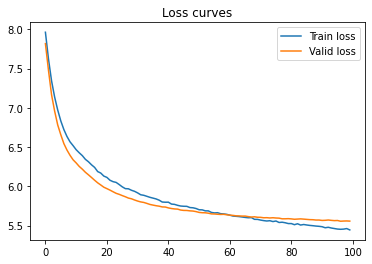

In [ ]:
import matplotlib.pyplot as plt
epochs = np.array(list(range(len(best_plot_cache))))
plt.plot(epochs, [i[0] for i in best_plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in best_plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

In [ ]:
torch.save({'options': options,
            'loss_cache': best_plot_cache,
            'model_dict': best_model.state_dict()
            }, '../content/drive/My Drive/wiki_lstm_1.pt')

##### Model 2

input_size = 256, hidden_size = 256, num_layers = 5

In [ ]:
import torch
torch.cuda.empty_cache()

In [15]:
import torch.optim as optim

model = models[1]
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

plot_cache = []
max_patience = 3
epochs_no_improve = 0
early_stop = False
last_val_loss = 100

for epoch_number in range(100):
    print(epoch_number)
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['train'])):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['valid'])):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    if avg_val_loss < last_val_loss:
  # Save the model
             #torch.save(model)
             best_model = model
             best_plot_cache = plot_cache
             epochs_no_improve = 0
    else:
      epochs_no_improve += 1
    
    last_val_loss = avg_val_loss

    if epoch_number > 2 and epochs_no_improve >= max_patience:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
    break
    
    if early_stop:
        print("Stopped")
        break
    
    if load_pretrained:
        break

0it [00:00, ?it/s]

0


1it [00:00,  3.80it/s]

Step 0 avg train loss = 10.4110


101it [00:25,  2.73it/s]

Step 100 avg train loss = 10.3806


201it [00:49,  3.61it/s]

Step 200 avg train loss = 10.1911


301it [01:16,  3.69it/s]

Step 300 avg train loss = 9.3798


401it [01:41,  4.08it/s]

Step 400 avg train loss = 8.5802


501it [02:06,  4.42it/s]

Step 500 avg train loss = 8.3636


601it [02:31,  4.25it/s]

Step 600 avg train loss = 8.0411


612it [02:34,  3.97it/s]
67it [00:06, 10.05it/s]
0it [00:00, ?it/s]

Validation loss after 0 epoch = 7.7958
1


1it [00:00,  3.47it/s]

Step 0 avg train loss = 7.8882


101it [00:26,  4.08it/s]

Step 100 avg train loss = 7.9399


201it [00:50,  3.86it/s]

Step 200 avg train loss = 7.8364


301it [01:15,  4.32it/s]

Step 300 avg train loss = 7.8237


401it [01:41,  3.38it/s]

Step 400 avg train loss = 7.7570


501it [02:07,  3.57it/s]

Step 500 avg train loss = 7.7419


601it [02:32,  3.98it/s]

Step 600 avg train loss = 7.7083


612it [02:35,  3.94it/s]
67it [00:06, 10.30it/s]
0it [00:00, ?it/s]

Validation loss after 1 epoch = 7.5482
2


1it [00:00,  3.32it/s]

Step 0 avg train loss = 7.6547


101it [00:24,  4.38it/s]

Step 100 avg train loss = 7.6652


201it [00:50,  3.73it/s]

Step 200 avg train loss = 7.6545


301it [01:15,  3.53it/s]

Step 300 avg train loss = 7.6177


401it [01:39,  4.24it/s]

Step 400 avg train loss = 7.5930


501it [02:04,  3.93it/s]

Step 500 avg train loss = 7.5734


601it [02:30,  3.41it/s]

Step 600 avg train loss = 7.5526


612it [02:33,  3.99it/s]
67it [00:06, 10.22it/s]
0it [00:00, ?it/s]

Validation loss after 2 epoch = 7.3902
3


1it [00:00,  4.90it/s]

Step 0 avg train loss = 7.4998


101it [00:24,  3.97it/s]

Step 100 avg train loss = 7.5163


201it [00:49,  3.61it/s]

Step 200 avg train loss = 7.4974


301it [01:15,  3.97it/s]

Step 300 avg train loss = 7.4764


401it [01:40,  3.72it/s]

Step 400 avg train loss = 7.4548


501it [02:06,  4.11it/s]

Step 500 avg train loss = 7.4450


601it [02:32,  3.60it/s]

Step 600 avg train loss = 7.4153


612it [02:34,  3.95it/s]
67it [00:06, 10.22it/s]
0it [00:00, ?it/s]

Validation loss after 3 epoch = 7.2580
4


1it [00:00,  4.17it/s]

Step 0 avg train loss = 7.3882


101it [00:25,  3.28it/s]

Step 100 avg train loss = 7.3914


201it [00:50,  4.23it/s]

Step 200 avg train loss = 7.3824


301it [01:16,  3.85it/s]

Step 300 avg train loss = 7.3656


401it [01:41,  3.92it/s]

Step 400 avg train loss = 7.3506


501it [02:07,  4.39it/s]

Step 500 avg train loss = 7.3323


601it [02:32,  3.75it/s]

Step 600 avg train loss = 7.3194


612it [02:35,  3.94it/s]
67it [00:06, 10.21it/s]
0it [00:00, ?it/s]

Validation loss after 4 epoch = 7.1400
5


1it [00:00,  4.03it/s]

Step 0 avg train loss = 7.3283


101it [00:25,  3.71it/s]

Step 100 avg train loss = 7.2950


201it [00:50,  3.99it/s]

Step 200 avg train loss = 7.2893


301it [01:16,  3.57it/s]

Step 300 avg train loss = 7.2671


401it [01:41,  4.36it/s]

Step 400 avg train loss = 7.2561


501it [02:06,  3.93it/s]

Step 500 avg train loss = 7.2356


601it [02:32,  3.88it/s]

Step 600 avg train loss = 7.2270


612it [02:34,  3.96it/s]
67it [00:06, 10.14it/s]
1it [00:00,  5.20it/s]

Validation loss after 5 epoch = 7.0512
6
Step 0 avg train loss = 7.2435


101it [00:25,  3.80it/s]

Step 100 avg train loss = 7.2119


201it [00:50,  3.96it/s]

Step 200 avg train loss = 7.2006


301it [01:16,  4.31it/s]

Step 300 avg train loss = 7.1909


401it [01:41,  3.78it/s]

Step 400 avg train loss = 7.1784


501it [02:06,  3.63it/s]

Step 500 avg train loss = 7.1605


601it [02:32,  3.85it/s]

Step 600 avg train loss = 7.1356


612it [02:35,  3.95it/s]
67it [00:06, 10.11it/s]
0it [00:00, ?it/s]

Validation loss after 6 epoch = 6.9612
7


1it [00:00,  3.75it/s]

Step 0 avg train loss = 7.1086


101it [00:25,  4.00it/s]

Step 100 avg train loss = 7.1264


201it [00:50,  4.20it/s]

Step 200 avg train loss = 7.1148


301it [01:16,  3.93it/s]

Step 300 avg train loss = 7.1054


401it [01:42,  3.88it/s]

Step 400 avg train loss = 7.0811


501it [02:07,  3.95it/s]

Step 500 avg train loss = 7.0636


601it [02:33,  4.14it/s]

Step 600 avg train loss = 7.0412


612it [02:35,  3.93it/s]
67it [00:06, 10.26it/s]
0it [00:00, ?it/s]

Validation loss after 7 epoch = 6.8650
8


1it [00:00,  4.77it/s]

Step 0 avg train loss = 6.9880


101it [00:25,  4.17it/s]

Step 100 avg train loss = 7.0201


201it [00:51,  3.61it/s]

Step 200 avg train loss = 6.9926


301it [01:16,  3.67it/s]

Step 300 avg train loss = 6.9665


401it [01:42,  3.96it/s]

Step 400 avg train loss = 6.9343


501it [02:08,  4.05it/s]

Step 500 avg train loss = 6.9127


601it [02:34,  3.49it/s]

Step 600 avg train loss = 6.8916


612it [02:36,  3.91it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 8 epoch = 6.7176
9


1it [00:00,  4.86it/s]

Step 0 avg train loss = 6.7862


101it [00:25,  3.77it/s]

Step 100 avg train loss = 6.8810


201it [00:51,  4.46it/s]

Step 200 avg train loss = 6.8672


301it [01:15,  4.21it/s]

Step 300 avg train loss = 6.8600


401it [01:41,  3.45it/s]

Step 400 avg train loss = 6.8591


501it [02:06,  3.97it/s]

Step 500 avg train loss = 6.8426


601it [02:32,  3.64it/s]

Step 600 avg train loss = 6.8434


612it [02:34,  3.96it/s]
67it [00:06, 10.26it/s]
0it [00:00, ?it/s]

Validation loss after 9 epoch = 6.6667
10


1it [00:00,  4.06it/s]

Step 0 avg train loss = 6.7902


101it [00:25,  4.16it/s]

Step 100 avg train loss = 6.8189


201it [00:51,  3.50it/s]

Step 200 avg train loss = 6.8130


301it [01:18,  3.80it/s]

Step 300 avg train loss = 6.8009


401it [01:43,  3.88it/s]

Step 400 avg train loss = 6.7987


501it [02:08,  4.26it/s]

Step 500 avg train loss = 6.7743


601it [02:33,  3.65it/s]

Step 600 avg train loss = 6.7756


612it [02:36,  3.92it/s]
67it [00:06, 10.12it/s]
0it [00:00, ?it/s]

Validation loss after 10 epoch = 6.5933
11


1it [00:00,  4.73it/s]

Step 0 avg train loss = 6.7937


101it [00:25,  3.93it/s]

Step 100 avg train loss = 6.7555


201it [00:51,  3.86it/s]

Step 200 avg train loss = 6.7348


301it [01:17,  3.98it/s]

Step 300 avg train loss = 6.7321


401it [01:43,  3.73it/s]

Step 400 avg train loss = 6.7215


501it [02:08,  4.27it/s]

Step 500 avg train loss = 6.6986


601it [02:33,  4.38it/s]

Step 600 avg train loss = 6.6889


612it [02:36,  3.92it/s]
67it [00:06, 10.17it/s]
0it [00:00, ?it/s]

Validation loss after 11 epoch = 6.5155
12


1it [00:00,  3.25it/s]

Step 0 avg train loss = 6.7724


101it [00:26,  3.95it/s]

Step 100 avg train loss = 6.6764


201it [00:51,  3.92it/s]

Step 200 avg train loss = 6.6721


302it [01:17,  4.04it/s]

Step 300 avg train loss = 6.6617


401it [01:42,  3.41it/s]

Step 400 avg train loss = 6.6504


501it [02:07,  3.95it/s]

Step 500 avg train loss = 6.6342


601it [02:32,  3.79it/s]

Step 600 avg train loss = 6.6347


612it [02:35,  3.94it/s]
67it [00:06, 10.10it/s]
0it [00:00, ?it/s]

Validation loss after 12 epoch = 6.4574
13


1it [00:00,  4.81it/s]

Step 0 avg train loss = 6.6185


101it [00:25,  3.65it/s]

Step 100 avg train loss = 6.6167


201it [00:51,  4.17it/s]

Step 200 avg train loss = 6.6205


301it [01:16,  3.54it/s]

Step 300 avg train loss = 6.5998


401it [01:41,  3.71it/s]

Step 400 avg train loss = 6.5975


501it [02:06,  4.22it/s]

Step 500 avg train loss = 6.5937


601it [02:33,  3.81it/s]

Step 600 avg train loss = 6.5865


612it [02:35,  3.93it/s]
67it [00:06, 10.00it/s]
0it [00:00, ?it/s]

Validation loss after 13 epoch = 6.4056
14


1it [00:00,  3.71it/s]

Step 0 avg train loss = 6.6200


101it [00:25,  3.84it/s]

Step 100 avg train loss = 6.5683


201it [00:50,  4.03it/s]

Step 200 avg train loss = 6.5644


301it [01:16,  3.95it/s]

Step 300 avg train loss = 6.5662


401it [01:41,  3.66it/s]

Step 400 avg train loss = 6.5567


501it [02:07,  4.11it/s]

Step 500 avg train loss = 6.5424


601it [02:32,  4.14it/s]

Step 600 avg train loss = 6.5434


612it [02:35,  3.94it/s]
67it [00:06, 10.02it/s]
0it [00:00, ?it/s]

Validation loss after 14 epoch = 6.3680
15


1it [00:00,  4.07it/s]

Step 0 avg train loss = 6.5019


101it [00:25,  3.76it/s]

Step 100 avg train loss = 6.5343


201it [00:51,  4.11it/s]

Step 200 avg train loss = 6.5199


301it [01:16,  4.02it/s]

Step 300 avg train loss = 6.5249


401it [01:41,  4.21it/s]

Step 400 avg train loss = 6.5111


501it [02:07,  4.03it/s]

Step 500 avg train loss = 6.5063


601it [02:33,  4.15it/s]

Step 600 avg train loss = 6.5109


612it [02:36,  3.91it/s]
67it [00:06, 10.06it/s]
0it [00:00, ?it/s]

Validation loss after 15 epoch = 6.3336
16


1it [00:00,  3.90it/s]

Step 0 avg train loss = 6.5063


101it [00:26,  4.39it/s]

Step 100 avg train loss = 6.5035


201it [00:52,  3.67it/s]

Step 200 avg train loss = 6.4964


301it [01:17,  4.03it/s]

Step 300 avg train loss = 6.4816


401it [01:43,  4.21it/s]

Step 400 avg train loss = 6.4887


501it [02:08,  3.57it/s]

Step 500 avg train loss = 6.4750


601it [02:33,  4.25it/s]

Step 600 avg train loss = 6.4691


612it [02:35,  3.93it/s]
67it [00:06, 10.00it/s]
0it [00:00, ?it/s]

Validation loss after 16 epoch = 6.3031
17


1it [00:00,  5.00it/s]

Step 0 avg train loss = 6.4651


101it [00:25,  3.64it/s]

Step 100 avg train loss = 6.4742


201it [00:51,  3.82it/s]

Step 200 avg train loss = 6.4638


301it [01:17,  3.91it/s]

Step 300 avg train loss = 6.4600


401it [01:42,  4.16it/s]

Step 400 avg train loss = 6.4508


501it [02:08,  3.91it/s]

Step 500 avg train loss = 6.4445


601it [02:34,  4.32it/s]

Step 600 avg train loss = 6.4578


612it [02:37,  3.89it/s]
67it [00:06, 10.20it/s]
0it [00:00, ?it/s]

Validation loss after 17 epoch = 6.2770
18


1it [00:00,  2.35it/s]

Step 0 avg train loss = 6.4214


102it [00:26,  4.19it/s]

Step 100 avg train loss = 6.4386


201it [00:52,  3.27it/s]

Step 200 avg train loss = 6.4384


301it [01:17,  4.44it/s]

Step 300 avg train loss = 6.4356


401it [01:42,  3.60it/s]

Step 400 avg train loss = 6.4420


501it [02:08,  4.22it/s]

Step 500 avg train loss = 6.4229


601it [02:33,  4.02it/s]

Step 600 avg train loss = 6.4240


612it [02:35,  3.92it/s]
67it [00:06, 10.22it/s]
0it [00:00, ?it/s]

Validation loss after 18 epoch = 6.2600
19


1it [00:00,  4.54it/s]

Step 0 avg train loss = 6.3824


101it [00:26,  3.67it/s]

Step 100 avg train loss = 6.4195


201it [00:51,  3.59it/s]

Step 200 avg train loss = 6.4177


301it [01:17,  3.69it/s]

Step 300 avg train loss = 6.4104


401it [01:43,  3.70it/s]

Step 400 avg train loss = 6.4063


501it [02:08,  3.76it/s]

Step 500 avg train loss = 6.4180


601it [02:34,  3.75it/s]

Step 600 avg train loss = 6.3972


612it [02:36,  3.90it/s]
67it [00:06,  9.88it/s]
0it [00:00, ?it/s]

Validation loss after 19 epoch = 6.2390
20


1it [00:00,  4.96it/s]

Step 0 avg train loss = 6.4083


101it [00:25,  3.90it/s]

Step 100 avg train loss = 6.3985


201it [00:51,  3.79it/s]

Step 200 avg train loss = 6.3993


301it [01:16,  4.10it/s]

Step 300 avg train loss = 6.4006


401it [01:42,  4.12it/s]

Step 400 avg train loss = 6.4022


501it [02:08,  4.14it/s]

Step 500 avg train loss = 6.3916


601it [02:33,  3.90it/s]

Step 600 avg train loss = 6.3954


612it [02:36,  3.92it/s]
67it [00:06, 10.30it/s]
0it [00:00, ?it/s]

Validation loss after 20 epoch = 6.2328
21


1it [00:00,  4.96it/s]

Step 0 avg train loss = 6.3723


101it [00:25,  3.92it/s]

Step 100 avg train loss = 6.3957


201it [00:51,  3.65it/s]

Step 200 avg train loss = 6.3825


301it [01:16,  3.83it/s]

Step 300 avg train loss = 6.3860


401it [01:42,  3.79it/s]

Step 400 avg train loss = 6.3789


501it [02:08,  4.21it/s]

Step 500 avg train loss = 6.3720


601it [02:34,  4.17it/s]

Step 600 avg train loss = 6.3686


612it [02:36,  3.90it/s]
67it [00:06, 10.12it/s]
0it [00:00, ?it/s]

Validation loss after 21 epoch = 6.2097
22


1it [00:00,  3.12it/s]

Step 0 avg train loss = 6.4139


101it [00:25,  3.88it/s]

Step 100 avg train loss = 6.3629


201it [00:51,  3.89it/s]

Step 200 avg train loss = 6.3610


301it [01:16,  3.70it/s]

Step 300 avg train loss = 6.3596


401it [01:43,  3.56it/s]

Step 400 avg train loss = 6.3500


501it [02:08,  4.26it/s]

Step 500 avg train loss = 6.3605


601it [02:33,  3.85it/s]

Step 600 avg train loss = 6.3562


612it [02:36,  3.91it/s]
67it [00:06, 10.08it/s]
1it [00:00,  5.61it/s]

Validation loss after 22 epoch = 6.1915
23
Step 0 avg train loss = 6.3009


101it [00:25,  3.78it/s]

Step 100 avg train loss = 6.3395


201it [00:51,  3.26it/s]

Step 200 avg train loss = 6.3440


301it [01:17,  3.81it/s]

Step 300 avg train loss = 6.3371


401it [01:43,  4.00it/s]

Step 400 avg train loss = 6.3289


501it [02:08,  3.84it/s]

Step 500 avg train loss = 6.3339


601it [02:33,  3.84it/s]

Step 600 avg train loss = 6.3343


612it [02:36,  3.92it/s]
67it [00:06, 10.13it/s]
0it [00:00, ?it/s]

Validation loss after 23 epoch = 6.1723
24


1it [00:00,  4.91it/s]

Step 0 avg train loss = 6.2711


101it [00:25,  4.47it/s]

Step 100 avg train loss = 6.3230


201it [00:50,  4.05it/s]

Step 200 avg train loss = 6.3288


301it [01:16,  4.03it/s]

Step 300 avg train loss = 6.3141


401it [01:42,  3.77it/s]

Step 400 avg train loss = 6.3153


501it [02:07,  4.07it/s]

Step 500 avg train loss = 6.3048


601it [02:33,  4.11it/s]

Step 600 avg train loss = 6.3067


612it [02:35,  3.93it/s]
67it [00:06, 10.23it/s]
0it [00:00, ?it/s]

Validation loss after 24 epoch = 6.1567
25


1it [00:00,  3.83it/s]

Step 0 avg train loss = 6.3352


101it [00:25,  4.10it/s]

Step 100 avg train loss = 6.3050


201it [00:51,  3.73it/s]

Step 200 avg train loss = 6.3008


301it [01:16,  3.99it/s]

Step 300 avg train loss = 6.2963


401it [01:42,  3.61it/s]

Step 400 avg train loss = 6.2914


502it [02:07,  4.40it/s]

Step 500 avg train loss = 6.2896


601it [02:33,  3.91it/s]

Step 600 avg train loss = 6.2840


612it [02:36,  3.91it/s]
67it [00:06, 10.13it/s]
0it [00:00, ?it/s]

Validation loss after 25 epoch = 6.1376
26


1it [00:00,  3.38it/s]

Step 0 avg train loss = 6.2609


101it [00:25,  3.44it/s]

Step 100 avg train loss = 6.2872


201it [00:51,  4.11it/s]

Step 200 avg train loss = 6.2706


301it [01:17,  4.21it/s]

Step 300 avg train loss = 6.2763


401it [01:43,  3.84it/s]

Step 400 avg train loss = 6.2744


501it [02:08,  3.87it/s]

Step 500 avg train loss = 6.2665


601it [02:33,  4.03it/s]

Step 600 avg train loss = 6.2650


612it [02:36,  3.91it/s]
67it [00:06, 10.06it/s]
0it [00:00, ?it/s]

Validation loss after 26 epoch = 6.1151
27


1it [00:00,  4.48it/s]

Step 0 avg train loss = 6.3522


101it [00:25,  3.60it/s]

Step 100 avg train loss = 6.2631


201it [00:51,  3.89it/s]

Step 200 avg train loss = 6.2511


301it [01:17,  4.21it/s]

Step 300 avg train loss = 6.2519


401it [01:42,  4.13it/s]

Step 400 avg train loss = 6.2524


502it [02:08,  4.01it/s]

Step 500 avg train loss = 6.2442


601it [02:34,  3.97it/s]

Step 600 avg train loss = 6.2488


612it [02:36,  3.90it/s]
67it [00:06,  9.91it/s]
0it [00:00, ?it/s]

Validation loss after 27 epoch = 6.0986
28


1it [00:00,  3.57it/s]

Step 0 avg train loss = 6.2483


101it [00:25,  3.96it/s]

Step 100 avg train loss = 6.2277


201it [00:51,  3.58it/s]

Step 200 avg train loss = 6.2377


301it [01:16,  4.42it/s]

Step 300 avg train loss = 6.2315


401it [01:41,  4.10it/s]

Step 400 avg train loss = 6.2243


501it [02:07,  4.34it/s]

Step 500 avg train loss = 6.2330


601it [02:33,  3.58it/s]

Step 600 avg train loss = 6.2266


612it [02:36,  3.92it/s]
67it [00:06,  9.91it/s]
0it [00:00, ?it/s]

Validation loss after 28 epoch = 6.0822
29


1it [00:00,  3.16it/s]

Step 0 avg train loss = 6.2425


101it [00:26,  4.09it/s]

Step 100 avg train loss = 6.2123


201it [00:51,  4.08it/s]

Step 200 avg train loss = 6.2120


301it [01:16,  4.08it/s]

Step 300 avg train loss = 6.2047


401it [01:41,  3.54it/s]

Step 400 avg train loss = 6.2042


501it [02:07,  3.69it/s]

Step 500 avg train loss = 6.2088


601it [02:33,  3.87it/s]

Step 600 avg train loss = 6.2005


612it [02:36,  3.91it/s]
67it [00:06, 10.14it/s]
0it [00:00, ?it/s]

Validation loss after 29 epoch = 6.0556
30


1it [00:00,  3.93it/s]

Step 0 avg train loss = 6.2344


101it [00:25,  3.20it/s]

Step 100 avg train loss = 6.1943


201it [00:50,  3.94it/s]

Step 200 avg train loss = 6.1887


301it [01:16,  4.02it/s]

Step 300 avg train loss = 6.1774


401it [01:41,  3.88it/s]

Step 400 avg train loss = 6.1870


501it [02:06,  4.28it/s]

Step 500 avg train loss = 6.1823


601it [02:33,  4.07it/s]

Step 600 avg train loss = 6.1694


612it [02:36,  3.92it/s]
67it [00:06, 10.02it/s]
0it [00:00, ?it/s]

Validation loss after 30 epoch = 6.0411
31


1it [00:00,  4.46it/s]

Step 0 avg train loss = 6.2292


101it [00:26,  3.65it/s]

Step 100 avg train loss = 6.1674


201it [00:51,  3.89it/s]

Step 200 avg train loss = 6.1601


301it [01:17,  4.08it/s]

Step 300 avg train loss = 6.1658


401it [01:43,  3.85it/s]

Step 400 avg train loss = 6.1631


501it [02:08,  4.05it/s]

Step 500 avg train loss = 6.1582


601it [02:33,  3.65it/s]

Step 600 avg train loss = 6.1519


612it [02:36,  3.91it/s]
67it [00:06, 10.37it/s]
0it [00:00, ?it/s]

Validation loss after 31 epoch = 6.0204
32


2it [00:00,  4.13it/s]

Step 0 avg train loss = 6.0679


101it [00:24,  4.34it/s]

Step 100 avg train loss = 6.1511


201it [00:50,  3.95it/s]

Step 200 avg train loss = 6.1442


301it [01:15,  3.96it/s]

Step 300 avg train loss = 6.1391


401it [01:42,  3.64it/s]

Step 400 avg train loss = 6.1416


501it [02:07,  3.88it/s]

Step 500 avg train loss = 6.1373


601it [02:33,  3.45it/s]

Step 600 avg train loss = 6.1308


612it [02:36,  3.91it/s]
67it [00:06, 10.05it/s]
0it [00:00, ?it/s]

Validation loss after 32 epoch = 6.0037
33


1it [00:00,  4.75it/s]

Step 0 avg train loss = 6.1574


101it [00:24,  3.71it/s]

Step 100 avg train loss = 6.1243


201it [00:50,  4.40it/s]

Step 200 avg train loss = 6.1236


301it [01:15,  3.99it/s]

Step 300 avg train loss = 6.1284


401it [01:41,  4.23it/s]

Step 400 avg train loss = 6.1189


501it [02:06,  4.20it/s]

Step 500 avg train loss = 6.1218


601it [02:32,  3.96it/s]

Step 600 avg train loss = 6.1130


612it [02:35,  3.94it/s]
67it [00:06, 10.06it/s]
0it [00:00, ?it/s]

Validation loss after 33 epoch = 5.9849
34


1it [00:00,  4.00it/s]

Step 0 avg train loss = 6.0184


101it [00:25,  4.53it/s]

Step 100 avg train loss = 6.1075


201it [00:51,  4.17it/s]

Step 200 avg train loss = 6.1083


301it [01:17,  3.91it/s]

Step 300 avg train loss = 6.0955


401it [01:42,  3.75it/s]

Step 400 avg train loss = 6.1049


501it [02:08,  4.11it/s]

Step 500 avg train loss = 6.1168


601it [02:34,  3.91it/s]

Step 600 avg train loss = 6.0894


612it [02:36,  3.90it/s]
67it [00:06, 10.11it/s]
0it [00:00, ?it/s]

Validation loss after 34 epoch = 5.9712
35


1it [00:00,  4.42it/s]

Step 0 avg train loss = 6.1228


101it [00:25,  4.09it/s]

Step 100 avg train loss = 6.0832


201it [00:51,  4.40it/s]

Step 200 avg train loss = 6.0880


301it [01:16,  3.81it/s]

Step 300 avg train loss = 6.0943


401it [01:42,  4.37it/s]

Step 400 avg train loss = 6.0895


501it [02:08,  3.90it/s]

Step 500 avg train loss = 6.0716


601it [02:34,  3.79it/s]

Step 600 avg train loss = 6.0855


612it [02:36,  3.90it/s]
67it [00:06, 10.04it/s]
0it [00:00, ?it/s]

Validation loss after 35 epoch = 5.9602
36


1it [00:00,  4.65it/s]

Step 0 avg train loss = 6.0591


101it [00:25,  3.79it/s]

Step 100 avg train loss = 6.0732


201it [00:51,  3.80it/s]

Step 200 avg train loss = 6.0772


301it [01:16,  3.97it/s]

Step 300 avg train loss = 6.0656


401it [01:41,  4.22it/s]

Step 400 avg train loss = 6.0700


501it [02:07,  4.23it/s]

Step 500 avg train loss = 6.0607


601it [02:32,  3.70it/s]

Step 600 avg train loss = 6.0636


612it [02:35,  3.93it/s]
67it [00:06, 10.14it/s]
0it [00:00, ?it/s]

Validation loss after 36 epoch = 5.9441
37


1it [00:00,  3.35it/s]

Step 0 avg train loss = 6.0446


101it [00:26,  3.69it/s]

Step 100 avg train loss = 6.0574


201it [00:51,  3.70it/s]

Step 200 avg train loss = 6.0458


301it [01:16,  4.08it/s]

Step 300 avg train loss = 6.0515


401it [01:42,  4.42it/s]

Step 400 avg train loss = 6.0593


501it [02:08,  3.39it/s]

Step 500 avg train loss = 6.0601


601it [02:34,  4.15it/s]

Step 600 avg train loss = 6.0490


612it [02:36,  3.90it/s]
67it [00:06, 10.36it/s]
0it [00:00, ?it/s]

Validation loss after 37 epoch = 5.9397
38


1it [00:00,  4.01it/s]

Step 0 avg train loss = 6.0155


101it [00:25,  3.91it/s]

Step 100 avg train loss = 6.0450


201it [00:50,  3.69it/s]

Step 200 avg train loss = 6.0317


301it [01:16,  3.88it/s]

Step 300 avg train loss = 6.0361


401it [01:42,  4.14it/s]

Step 400 avg train loss = 6.0402


502it [02:08,  4.32it/s]

Step 500 avg train loss = 6.0517


601it [02:33,  4.15it/s]

Step 600 avg train loss = 6.0336


612it [02:36,  3.92it/s]
67it [00:06, 10.16it/s]
0it [00:00, ?it/s]

Validation loss after 38 epoch = 5.9219
39


1it [00:00,  3.84it/s]

Step 0 avg train loss = 6.0084


101it [00:25,  4.20it/s]

Step 100 avg train loss = 6.0245


201it [00:50,  4.15it/s]

Step 200 avg train loss = 6.0261


301it [01:17,  4.09it/s]

Step 300 avg train loss = 6.0304


402it [01:42,  4.28it/s]

Step 400 avg train loss = 6.0204


501it [02:07,  3.62it/s]

Step 500 avg train loss = 6.0312


601it [02:33,  3.51it/s]

Step 600 avg train loss = 6.0317


612it [02:36,  3.91it/s]
67it [00:06, 10.06it/s]
0it [00:00, ?it/s]

Validation loss after 39 epoch = 5.9126
40


1it [00:00,  4.58it/s]

Step 0 avg train loss = 6.0405


101it [00:25,  4.00it/s]

Step 100 avg train loss = 6.0137


201it [00:51,  4.16it/s]

Step 200 avg train loss = 6.0114


301it [01:16,  3.82it/s]

Step 300 avg train loss = 6.0357


402it [01:42,  4.13it/s]

Step 400 avg train loss = 6.0185


501it [02:08,  3.88it/s]

Step 500 avg train loss = 6.0088


601it [02:33,  3.80it/s]

Step 600 avg train loss = 6.0132


612it [02:36,  3.91it/s]
67it [00:06, 10.04it/s]
0it [00:00, ?it/s]

Validation loss after 40 epoch = 5.9098
41


1it [00:00,  3.76it/s]

Step 0 avg train loss = 6.0836


101it [00:25,  4.02it/s]

Step 100 avg train loss = 6.0094


201it [00:51,  3.97it/s]

Step 200 avg train loss = 6.0021


302it [01:18,  3.95it/s]

Step 300 avg train loss = 6.0032


401it [01:42,  4.48it/s]

Step 400 avg train loss = 6.0084


501it [02:08,  4.19it/s]

Step 500 avg train loss = 6.0160


601it [02:34,  4.01it/s]

Step 600 avg train loss = 5.9953


612it [02:36,  3.90it/s]
67it [00:06, 10.20it/s]
0it [00:00, ?it/s]

Validation loss after 41 epoch = 5.8947
42


1it [00:00,  3.61it/s]

Step 0 avg train loss = 5.9896


101it [00:26,  3.91it/s]

Step 100 avg train loss = 5.9904


201it [00:52,  3.74it/s]

Step 200 avg train loss = 5.9989


301it [01:17,  4.03it/s]

Step 300 avg train loss = 5.9967


401it [01:43,  4.16it/s]

Step 400 avg train loss = 5.9912


501it [02:09,  4.45it/s]

Step 500 avg train loss = 6.0006


601it [02:34,  4.29it/s]

Step 600 avg train loss = 5.9907


612it [02:37,  3.89it/s]
67it [00:06, 10.16it/s]
0it [00:00, ?it/s]

Validation loss after 42 epoch = 5.8902
43


1it [00:00,  4.16it/s]

Step 0 avg train loss = 6.0105


101it [00:25,  3.82it/s]

Step 100 avg train loss = 5.9905


201it [00:51,  3.96it/s]

Step 200 avg train loss = 5.9916


301it [01:16,  3.99it/s]

Step 300 avg train loss = 5.9895


401it [01:42,  4.15it/s]

Step 400 avg train loss = 5.9792


501it [02:08,  3.90it/s]

Step 500 avg train loss = 5.9787


601it [02:33,  4.45it/s]

Step 600 avg train loss = 5.9839


612it [02:36,  3.92it/s]
67it [00:06, 10.17it/s]
0it [00:00, ?it/s]

Validation loss after 43 epoch = 5.8859
44


1it [00:00,  4.13it/s]

Step 0 avg train loss = 6.0026


101it [00:26,  3.83it/s]

Step 100 avg train loss = 5.9780


201it [00:51,  3.94it/s]

Step 200 avg train loss = 5.9758


301it [01:17,  3.90it/s]

Step 300 avg train loss = 5.9767


401it [01:42,  4.05it/s]

Step 400 avg train loss = 5.9699


501it [02:08,  3.68it/s]

Step 500 avg train loss = 5.9762


601it [02:33,  3.87it/s]

Step 600 avg train loss = 5.9822


612it [02:36,  3.90it/s]
67it [00:06, 10.00it/s]
0it [00:00, ?it/s]

Validation loss after 44 epoch = 5.8767
45


1it [00:00,  4.62it/s]

Step 0 avg train loss = 5.9723


101it [00:26,  4.00it/s]

Step 100 avg train loss = 5.9561


201it [00:52,  3.64it/s]

Step 200 avg train loss = 5.9765


301it [01:18,  3.79it/s]

Step 300 avg train loss = 5.9753


401it [01:43,  3.62it/s]

Step 400 avg train loss = 5.9696


501it [02:08,  4.07it/s]

Step 500 avg train loss = 5.9723


601it [02:33,  3.97it/s]

Step 600 avg train loss = 5.9617


612it [02:36,  3.91it/s]
67it [00:06, 10.12it/s]
0it [00:00, ?it/s]

Validation loss after 45 epoch = 5.8719
46


1it [00:00,  3.69it/s]

Step 0 avg train loss = 6.0883


101it [00:25,  3.86it/s]

Step 100 avg train loss = 5.9624


201it [00:50,  4.33it/s]

Step 200 avg train loss = 5.9621


301it [01:16,  4.26it/s]

Step 300 avg train loss = 5.9566


401it [01:42,  3.74it/s]

Step 400 avg train loss = 5.9619


501it [02:08,  3.61it/s]

Step 500 avg train loss = 5.9590


601it [02:33,  4.18it/s]

Step 600 avg train loss = 5.9536


612it [02:36,  3.91it/s]
67it [00:06, 10.03it/s]
0it [00:00, ?it/s]

Validation loss after 46 epoch = 5.8656
47


1it [00:00,  3.37it/s]

Step 0 avg train loss = 5.8942


102it [00:26,  4.32it/s]

Step 100 avg train loss = 5.9396


201it [00:51,  4.35it/s]

Step 200 avg train loss = 5.9550


301it [01:16,  3.64it/s]

Step 300 avg train loss = 5.9542


401it [01:43,  4.18it/s]

Step 400 avg train loss = 5.9497


501it [02:08,  3.69it/s]

Step 500 avg train loss = 5.9507


601it [02:34,  3.92it/s]

Step 600 avg train loss = 5.9519


612it [02:36,  3.90it/s]
67it [00:06, 10.11it/s]
0it [00:00, ?it/s]

Validation loss after 47 epoch = 5.8600
48


1it [00:00,  4.46it/s]

Step 0 avg train loss = 5.9276


101it [00:26,  3.90it/s]

Step 100 avg train loss = 5.9415


201it [00:51,  3.52it/s]

Step 200 avg train loss = 5.9453


301it [01:17,  4.33it/s]

Step 300 avg train loss = 5.9392


401it [01:42,  4.15it/s]

Step 400 avg train loss = 5.9426


501it [02:08,  3.98it/s]

Step 500 avg train loss = 5.9445


601it [02:34,  3.98it/s]

Step 600 avg train loss = 5.9381


612it [02:37,  3.89it/s]
67it [00:06, 10.23it/s]
0it [00:00, ?it/s]

Validation loss after 48 epoch = 5.8507
49


2it [00:00,  5.02it/s]

Step 0 avg train loss = 5.8597


101it [00:25,  3.93it/s]

Step 100 avg train loss = 5.9309


201it [00:50,  3.97it/s]

Step 200 avg train loss = 5.9451


301it [01:16,  3.97it/s]

Step 300 avg train loss = 5.9276


401it [01:42,  4.05it/s]

Step 400 avg train loss = 5.9337


501it [02:08,  4.27it/s]

Step 500 avg train loss = 5.9372


601it [02:33,  3.78it/s]

Step 600 avg train loss = 5.9256


612it [02:36,  3.92it/s]
67it [00:06, 10.13it/s]
1it [00:00,  5.12it/s]

Validation loss after 49 epoch = 5.8523
50
Step 0 avg train loss = 5.8647


101it [00:25,  3.53it/s]

Step 100 avg train loss = 5.9260


201it [00:51,  3.48it/s]

Step 200 avg train loss = 5.9183


301it [01:17,  3.90it/s]

Step 300 avg train loss = 5.9264


401it [01:42,  4.04it/s]

Step 400 avg train loss = 5.9245


501it [02:08,  3.50it/s]

Step 500 avg train loss = 5.9264


601it [02:34,  3.97it/s]

Step 600 avg train loss = 5.9325


612it [02:36,  3.90it/s]
67it [00:06,  9.99it/s]
0it [00:00, ?it/s]

Validation loss after 50 epoch = 5.8419
51


1it [00:00,  4.42it/s]

Step 0 avg train loss = 5.8705


101it [00:25,  4.16it/s]

Step 100 avg train loss = 5.9144


201it [00:50,  3.83it/s]

Step 200 avg train loss = 5.9125


302it [01:16,  3.85it/s]

Step 300 avg train loss = 5.9272


401it [01:42,  4.46it/s]

Step 400 avg train loss = 5.9203


501it [02:07,  3.64it/s]

Step 500 avg train loss = 5.9111


601it [02:33,  4.04it/s]

Step 600 avg train loss = 5.9249


612it [02:35,  3.93it/s]
67it [00:06, 10.10it/s]
0it [00:00, ?it/s]

Validation loss after 51 epoch = 5.8393
52


1it [00:00,  4.59it/s]

Step 0 avg train loss = 5.9974


101it [00:25,  3.79it/s]

Step 100 avg train loss = 5.9189


201it [00:51,  4.01it/s]

Step 200 avg train loss = 5.9037


301it [01:17,  3.80it/s]

Step 300 avg train loss = 5.9131


401it [01:43,  4.27it/s]

Step 400 avg train loss = 5.9201


501it [02:08,  3.87it/s]

Step 500 avg train loss = 5.9216


601it [02:34,  3.60it/s]

Step 600 avg train loss = 5.8962


612it [02:36,  3.90it/s]
67it [00:06, 10.00it/s]
0it [00:00, ?it/s]

Validation loss after 52 epoch = 5.8295
53


1it [00:00,  3.91it/s]

Step 0 avg train loss = 5.9877


101it [00:25,  3.53it/s]

Step 100 avg train loss = 5.8990


201it [00:51,  3.54it/s]

Step 200 avg train loss = 5.8966


301it [01:17,  3.61it/s]

Step 300 avg train loss = 5.9159


401it [01:42,  4.04it/s]

Step 400 avg train loss = 5.9049


501it [02:08,  3.83it/s]

Step 500 avg train loss = 5.9045


601it [02:33,  4.16it/s]

Step 600 avg train loss = 5.9099


612it [02:36,  3.91it/s]
67it [00:06, 10.19it/s]
0it [00:00, ?it/s]

Validation loss after 53 epoch = 5.8264
54


1it [00:00,  3.83it/s]

Step 0 avg train loss = 5.8903


101it [00:25,  4.12it/s]

Step 100 avg train loss = 5.9081


201it [00:51,  3.84it/s]

Step 200 avg train loss = 5.8996


301it [01:17,  3.92it/s]

Step 300 avg train loss = 5.8931


401it [01:42,  3.82it/s]

Step 400 avg train loss = 5.8901


501it [02:08,  3.79it/s]

Step 500 avg train loss = 5.8981


601it [02:33,  3.93it/s]

Step 600 avg train loss = 5.8970


612it [02:36,  3.91it/s]
67it [00:06, 10.08it/s]
0it [00:00, ?it/s]

Validation loss after 54 epoch = 5.8163
55


1it [00:00,  4.17it/s]

Step 0 avg train loss = 5.9060


101it [00:26,  3.10it/s]

Step 100 avg train loss = 5.8910


201it [00:52,  4.03it/s]

Step 200 avg train loss = 5.8874


301it [01:17,  3.73it/s]

Step 300 avg train loss = 5.8870


401it [01:42,  4.17it/s]

Step 400 avg train loss = 5.8950


501it [02:08,  4.57it/s]

Step 500 avg train loss = 5.9008


601it [02:34,  3.95it/s]

Step 600 avg train loss = 5.8933


612it [02:36,  3.90it/s]
67it [00:06, 10.22it/s]
0it [00:00, ?it/s]

Validation loss after 55 epoch = 5.8183
56


1it [00:00,  4.49it/s]

Step 0 avg train loss = 5.9639


101it [00:26,  3.92it/s]

Step 100 avg train loss = 5.8840


201it [00:52,  3.97it/s]

Step 200 avg train loss = 5.8848


301it [01:16,  3.91it/s]

Step 300 avg train loss = 5.8796


402it [01:42,  4.20it/s]

Step 400 avg train loss = 5.8929


501it [02:07,  3.94it/s]

Step 500 avg train loss = 5.8822


601it [02:33,  3.73it/s]

Step 600 avg train loss = 5.8904


612it [02:36,  3.92it/s]
67it [00:06, 10.01it/s]
0it [00:00, ?it/s]

Validation loss after 56 epoch = 5.8120
57


1it [00:00,  3.57it/s]

Step 0 avg train loss = 5.8665


101it [00:26,  3.81it/s]

Step 100 avg train loss = 5.8791


201it [00:52,  3.99it/s]

Step 200 avg train loss = 5.8793


301it [01:17,  4.21it/s]

Step 300 avg train loss = 5.8795


401it [01:42,  4.05it/s]

Step 400 avg train loss = 5.8741


501it [02:08,  3.88it/s]

Step 500 avg train loss = 5.8830


601it [02:34,  3.95it/s]

Step 600 avg train loss = 5.8819


612it [02:36,  3.90it/s]
67it [00:06, 10.18it/s]
0it [00:00, ?it/s]

Validation loss after 57 epoch = 5.8119
58


1it [00:00,  3.15it/s]

Step 0 avg train loss = 5.8826


101it [00:26,  3.93it/s]

Step 100 avg train loss = 5.8744


201it [00:51,  4.09it/s]

Step 200 avg train loss = 5.8739


301it [01:16,  3.70it/s]

Step 300 avg train loss = 5.8604


401it [01:42,  3.54it/s]

Step 400 avg train loss = 5.8791


501it [02:08,  3.26it/s]

Step 500 avg train loss = 5.8830


601it [02:34,  3.84it/s]

Step 600 avg train loss = 5.8746


612it [02:36,  3.90it/s]
67it [00:06,  9.99it/s]
1it [00:00,  5.30it/s]

Validation loss after 58 epoch = 5.8116
59
Step 0 avg train loss = 5.8822


101it [00:26,  3.99it/s]

Step 100 avg train loss = 5.8661


201it [00:51,  4.06it/s]

Step 200 avg train loss = 5.8696


301it [01:17,  4.25it/s]

Step 300 avg train loss = 5.8746


402it [01:42,  4.40it/s]

Step 400 avg train loss = 5.8661


501it [02:07,  3.74it/s]

Step 500 avg train loss = 5.8744


601it [02:32,  3.87it/s]

Step 600 avg train loss = 5.8596


612it [02:35,  3.93it/s]
67it [00:06, 10.10it/s]
0it [00:00, ?it/s]

Validation loss after 59 epoch = 5.7956
60


1it [00:00,  4.03it/s]

Step 0 avg train loss = 5.9324


101it [00:26,  3.57it/s]

Step 100 avg train loss = 5.8605


201it [00:51,  4.07it/s]

Step 200 avg train loss = 5.8615


301it [01:16,  3.72it/s]

Step 300 avg train loss = 5.8530


401it [01:43,  3.98it/s]

Step 400 avg train loss = 5.8597


501it [02:09,  4.02it/s]

Step 500 avg train loss = 5.8649


601it [02:34,  3.76it/s]

Step 600 avg train loss = 5.8684


612it [02:37,  3.90it/s]
67it [00:06, 10.15it/s]
0it [00:00, ?it/s]

Validation loss after 60 epoch = 5.7981
61


1it [00:00,  4.69it/s]

Step 0 avg train loss = 5.8703


101it [00:25,  3.62it/s]

Step 100 avg train loss = 5.8585


201it [00:51,  3.89it/s]

Step 200 avg train loss = 5.8566


301it [01:17,  3.83it/s]

Step 300 avg train loss = 5.8619


401it [01:43,  4.11it/s]

Step 400 avg train loss = 5.8587


501it [02:08,  4.04it/s]

Step 500 avg train loss = 5.8569


601it [02:34,  3.96it/s]

Step 600 avg train loss = 5.8529


612it [02:36,  3.90it/s]
67it [00:06, 10.03it/s]
0it [00:00, ?it/s]

Validation loss after 61 epoch = 5.7975
62


1it [00:00,  3.58it/s]

Step 0 avg train loss = 5.9531


101it [00:26,  3.78it/s]

Step 100 avg train loss = 5.8571


201it [00:52,  3.66it/s]

Step 200 avg train loss = 5.8476


301it [01:17,  3.65it/s]

Step 300 avg train loss = 5.8453


401it [01:43,  4.13it/s]

Step 400 avg train loss = 5.8495


501it [02:08,  3.86it/s]

Step 500 avg train loss = 5.8561


601it [02:34,  3.82it/s]

Step 600 avg train loss = 5.8532


612it [02:36,  3.90it/s]
67it [00:06, 10.25it/s]
0it [00:00, ?it/s]

Validation loss after 62 epoch = 5.7887
63


1it [00:00,  4.41it/s]

Step 0 avg train loss = 5.8001


101it [00:25,  4.21it/s]

Step 100 avg train loss = 5.8399


201it [00:50,  4.13it/s]

Step 200 avg train loss = 5.8385


301it [01:15,  3.67it/s]

Step 300 avg train loss = 5.8572


401it [01:41,  3.97it/s]

Step 400 avg train loss = 5.8416


501it [02:07,  3.71it/s]

Step 500 avg train loss = 5.8512


601it [02:33,  3.59it/s]

Step 600 avg train loss = 5.8445


612it [02:35,  3.93it/s]
67it [00:06, 10.04it/s]
0it [00:00, ?it/s]

Validation loss after 63 epoch = 5.7831
64


1it [00:00,  4.83it/s]

Step 0 avg train loss = 5.8165


101it [00:25,  4.11it/s]

Step 100 avg train loss = 5.8428


201it [00:51,  3.96it/s]

Step 200 avg train loss = 5.8306


301it [01:17,  4.36it/s]

Step 300 avg train loss = 5.8433


401it [01:42,  3.89it/s]

Step 400 avg train loss = 5.8392


501it [02:08,  3.77it/s]

Step 500 avg train loss = 5.8375


601it [02:34,  3.78it/s]

Step 600 avg train loss = 5.8463


612it [02:37,  3.89it/s]
67it [00:06, 10.11it/s]
0it [00:00, ?it/s]

Validation loss after 64 epoch = 5.7793
65


1it [00:00,  4.18it/s]

Step 0 avg train loss = 5.8111


101it [00:25,  4.34it/s]

Step 100 avg train loss = 5.8326


201it [00:51,  4.27it/s]

Step 200 avg train loss = 5.8325


301it [01:16,  3.82it/s]

Step 300 avg train loss = 5.8332


401it [01:42,  3.51it/s]

Step 400 avg train loss = 5.8412


501it [02:07,  4.11it/s]

Step 500 avg train loss = 5.8349


601it [02:33,  3.86it/s]

Step 600 avg train loss = 5.8342


612it [02:36,  3.91it/s]
67it [00:06,  9.99it/s]
0it [00:00, ?it/s]

Validation loss after 65 epoch = 5.7805
66


1it [00:00,  4.08it/s]

Step 0 avg train loss = 5.7753


101it [00:25,  4.16it/s]

Step 100 avg train loss = 5.8303


201it [00:51,  4.03it/s]

Step 200 avg train loss = 5.8353


301it [01:16,  4.14it/s]

Step 300 avg train loss = 5.8315


401it [01:42,  3.80it/s]

Step 400 avg train loss = 5.8304


501it [02:07,  3.76it/s]

Step 500 avg train loss = 5.8375


601it [02:32,  4.06it/s]

Step 600 avg train loss = 5.8230


612it [02:35,  3.93it/s]
67it [00:06, 10.15it/s]
0it [00:00, ?it/s]

Validation loss after 66 epoch = 5.7811
67


1it [00:00,  3.81it/s]

Step 0 avg train loss = 5.8082


101it [00:25,  3.98it/s]

Step 100 avg train loss = 5.8164


201it [00:51,  4.32it/s]

Step 200 avg train loss = 5.8260


301it [01:16,  4.21it/s]

Step 300 avg train loss = 5.8322


401it [01:42,  4.16it/s]

Step 400 avg train loss = 5.8282


501it [02:08,  3.62it/s]

Step 500 avg train loss = 5.8371


602it [02:33,  3.99it/s]

Step 600 avg train loss = 5.8202


612it [02:36,  3.91it/s]
67it [00:06, 10.18it/s]
0it [00:00, ?it/s]

Validation loss after 67 epoch = 5.7747
68


1it [00:00,  4.52it/s]

Step 0 avg train loss = 5.8508


101it [00:25,  3.39it/s]

Step 100 avg train loss = 5.8247


201it [00:51,  4.15it/s]

Step 200 avg train loss = 5.8220


301it [01:17,  3.46it/s]

Step 300 avg train loss = 5.8200


401it [01:42,  4.04it/s]

Step 400 avg train loss = 5.8187


501it [02:08,  3.98it/s]

Step 500 avg train loss = 5.8197


601it [02:33,  4.00it/s]

Step 600 avg train loss = 5.8251


612it [02:36,  3.91it/s]
67it [00:06, 10.04it/s]
0it [00:00, ?it/s]

Validation loss after 68 epoch = 5.7698
69


1it [00:00,  4.65it/s]

Step 0 avg train loss = 5.8607


101it [00:25,  4.07it/s]

Step 100 avg train loss = 5.8148


201it [00:51,  4.29it/s]

Step 200 avg train loss = 5.8120


301it [01:17,  3.88it/s]

Step 300 avg train loss = 5.8190


401it [01:43,  3.74it/s]

Step 400 avg train loss = 5.8186


501it [02:08,  3.76it/s]

Step 500 avg train loss = 5.8097


601it [02:34,  4.09it/s]

Step 600 avg train loss = 5.8213


612it [02:36,  3.90it/s]
67it [00:06, 10.01it/s]
0it [00:00, ?it/s]

Validation loss after 69 epoch = 5.7676
70


1it [00:00,  4.61it/s]

Step 0 avg train loss = 5.8132


101it [00:26,  4.04it/s]

Step 100 avg train loss = 5.8067


201it [00:52,  3.85it/s]

Step 200 avg train loss = 5.8031


301it [01:17,  4.11it/s]

Step 300 avg train loss = 5.8058


401it [01:42,  3.71it/s]

Step 400 avg train loss = 5.8156


501it [02:08,  3.94it/s]

Step 500 avg train loss = 5.8239


601it [02:33,  4.38it/s]

Step 600 avg train loss = 5.8164


612it [02:36,  3.92it/s]
67it [00:06, 10.05it/s]
0it [00:00, ?it/s]

Validation loss after 70 epoch = 5.7615
71


2it [00:00,  4.09it/s]

Step 0 avg train loss = 5.7768


101it [00:25,  4.23it/s]

Step 100 avg train loss = 5.7990


201it [00:51,  4.07it/s]

Step 200 avg train loss = 5.8004


301it [01:17,  3.87it/s]

Step 300 avg train loss = 5.8095


401it [01:43,  4.14it/s]

Step 400 avg train loss = 5.8101


501it [02:08,  4.14it/s]

Step 500 avg train loss = 5.8149


601it [02:34,  4.02it/s]

Step 600 avg train loss = 5.8116


612it [02:37,  3.89it/s]
67it [00:06,  9.81it/s]
0it [00:00, ?it/s]

Validation loss after 71 epoch = 5.7600
72


2it [00:00,  5.02it/s]

Step 0 avg train loss = 5.6745


101it [00:25,  3.95it/s]

Step 100 avg train loss = 5.8070


201it [00:50,  3.84it/s]

Step 200 avg train loss = 5.8047


301it [01:17,  4.29it/s]

Step 300 avg train loss = 5.8026


401it [01:42,  3.59it/s]

Step 400 avg train loss = 5.8020


501it [02:08,  3.56it/s]

Step 500 avg train loss = 5.7995


601it [02:33,  4.25it/s]

Step 600 avg train loss = 5.8065


612it [02:36,  3.91it/s]
67it [00:06, 10.12it/s]
1it [00:00,  5.16it/s]

Validation loss after 72 epoch = 5.7595
73
Step 0 avg train loss = 5.7835


101it [00:25,  4.18it/s]

Step 100 avg train loss = 5.7995


201it [00:51,  4.22it/s]

Step 200 avg train loss = 5.7982


301it [01:17,  3.94it/s]

Step 300 avg train loss = 5.7903


401it [01:42,  3.78it/s]

Step 400 avg train loss = 5.7929


501it [02:07,  3.72it/s]

Step 500 avg train loss = 5.8028


601it [02:33,  3.56it/s]

Step 600 avg train loss = 5.8121


612it [02:35,  3.92it/s]
67it [00:06, 10.05it/s]
0it [00:00, ?it/s]

Validation loss after 73 epoch = 5.7606
74


1it [00:00,  4.90it/s]

Step 0 avg train loss = 5.6463


101it [00:25,  4.37it/s]

Step 100 avg train loss = 5.7904


201it [00:51,  3.74it/s]

Step 200 avg train loss = 5.7927


301it [01:16,  3.70it/s]

Step 300 avg train loss = 5.8028


401it [01:41,  4.11it/s]

Step 400 avg train loss = 5.7948


501it [02:07,  3.85it/s]

Step 500 avg train loss = 5.7889


601it [02:33,  3.45it/s]

Step 600 avg train loss = 5.8004


612it [02:36,  3.91it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 74 epoch = 5.7576
75


1it [00:00,  4.98it/s]

Step 0 avg train loss = 5.7155


101it [00:26,  3.84it/s]

Step 100 avg train loss = 5.7883


201it [00:51,  3.82it/s]

Step 200 avg train loss = 5.7940


301it [01:16,  3.74it/s]

Step 300 avg train loss = 5.7929


401it [01:42,  3.58it/s]

Step 400 avg train loss = 5.7873


501it [02:07,  4.16it/s]

Step 500 avg train loss = 5.7925


601it [02:33,  4.06it/s]

Step 600 avg train loss = 5.7979


612it [02:36,  3.91it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 75 epoch = 5.7488
76


1it [00:00,  3.31it/s]

Step 0 avg train loss = 5.9113


101it [00:26,  3.63it/s]

Step 100 avg train loss = 5.7853


201it [00:51,  3.69it/s]

Step 200 avg train loss = 5.7882


301it [01:15,  3.98it/s]

Step 300 avg train loss = 5.7810


401it [01:42,  3.49it/s]

Step 400 avg train loss = 5.7918


501it [02:07,  3.82it/s]

Step 500 avg train loss = 5.7888


601it [02:33,  3.77it/s]

Step 600 avg train loss = 5.7876


612it [02:36,  3.91it/s]
67it [00:06, 10.06it/s]
0it [00:00, ?it/s]

Validation loss after 76 epoch = 5.7462
77


1it [00:00,  1.94it/s]

Step 0 avg train loss = 5.8767


101it [00:25,  4.45it/s]

Step 100 avg train loss = 5.7834


201it [00:52,  3.93it/s]

Step 200 avg train loss = 5.7760


301it [01:18,  4.08it/s]

Step 300 avg train loss = 5.7856


401it [01:43,  3.79it/s]

Step 400 avg train loss = 5.7774


501it [02:09,  3.85it/s]

Step 500 avg train loss = 5.7881


601it [02:34,  3.92it/s]

Step 600 avg train loss = 5.7888


612it [02:37,  3.89it/s]
67it [00:06, 10.23it/s]
0it [00:00, ?it/s]

Validation loss after 77 epoch = 5.7442
78


1it [00:00,  4.73it/s]

Step 0 avg train loss = 5.7901


101it [00:25,  4.27it/s]

Step 100 avg train loss = 5.7776


201it [00:51,  4.00it/s]

Step 200 avg train loss = 5.7719


301it [01:17,  3.86it/s]

Step 300 avg train loss = 5.7860


401it [01:42,  3.85it/s]

Step 400 avg train loss = 5.7803


501it [02:08,  3.61it/s]

Step 500 avg train loss = 5.7773


601it [02:33,  4.33it/s]

Step 600 avg train loss = 5.7787


612it [02:36,  3.92it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 78 epoch = 5.7433
79


1it [00:00,  3.99it/s]

Step 0 avg train loss = 5.7442


101it [00:25,  3.68it/s]

Step 100 avg train loss = 5.7775


201it [00:52,  3.96it/s]

Step 200 avg train loss = 5.7796


301it [01:18,  4.20it/s]

Step 300 avg train loss = 5.7714


401it [01:43,  3.96it/s]

Step 400 avg train loss = 5.7666


501it [02:09,  4.19it/s]

Step 500 avg train loss = 5.7806


601it [02:35,  4.06it/s]

Step 600 avg train loss = 5.7744


612it [02:37,  3.88it/s]
67it [00:06,  9.99it/s]
0it [00:00, ?it/s]

Validation loss after 79 epoch = 5.7420
80


2it [00:00,  4.12it/s]

Step 0 avg train loss = 5.7737


101it [00:25,  3.52it/s]

Step 100 avg train loss = 5.7690


201it [00:51,  3.81it/s]

Step 200 avg train loss = 5.7659


301it [01:16,  3.59it/s]

Step 300 avg train loss = 5.7678


401it [01:42,  3.86it/s]

Step 400 avg train loss = 5.7771


501it [02:08,  3.82it/s]

Step 500 avg train loss = 5.7752


601it [02:34,  3.88it/s]

Step 600 avg train loss = 5.7696


612it [02:37,  3.90it/s]
67it [00:06,  9.94it/s]
0it [00:00, ?it/s]

Validation loss after 80 epoch = 5.7337
81


1it [00:00,  4.42it/s]

Step 0 avg train loss = 5.8277


101it [00:25,  4.32it/s]

Step 100 avg train loss = 5.7727


201it [00:51,  3.91it/s]

Step 200 avg train loss = 5.7637


301it [01:16,  4.48it/s]

Step 300 avg train loss = 5.7716


401it [01:42,  3.88it/s]

Step 400 avg train loss = 5.7709


501it [02:07,  3.95it/s]

Step 500 avg train loss = 5.7595


601it [02:33,  4.37it/s]

Step 600 avg train loss = 5.7624


612it [02:36,  3.91it/s]
67it [00:06, 10.19it/s]
0it [00:00, ?it/s]

Validation loss after 81 epoch = 5.7357
82


1it [00:00,  4.45it/s]

Step 0 avg train loss = 5.7919


101it [00:25,  3.35it/s]

Step 100 avg train loss = 5.7692


201it [00:51,  3.85it/s]

Step 200 avg train loss = 5.7616


301it [01:16,  4.38it/s]

Step 300 avg train loss = 5.7543


401it [01:41,  4.08it/s]

Step 400 avg train loss = 5.7577


501it [02:07,  3.40it/s]

Step 500 avg train loss = 5.7641


601it [02:33,  3.99it/s]

Step 600 avg train loss = 5.7775


612it [02:35,  3.93it/s]
67it [00:06, 10.20it/s]
0it [00:00, ?it/s]

Validation loss after 82 epoch = 5.7328
83


1it [00:00,  3.68it/s]

Step 0 avg train loss = 5.7654


101it [00:26,  3.85it/s]

Step 100 avg train loss = 5.7584


201it [00:51,  4.18it/s]

Step 200 avg train loss = 5.7592


301it [01:16,  4.08it/s]

Step 300 avg train loss = 5.7666


401it [01:42,  3.80it/s]

Step 400 avg train loss = 5.7558


501it [02:08,  3.71it/s]

Step 500 avg train loss = 5.7592


601it [02:34,  3.95it/s]

Step 600 avg train loss = 5.7621


612it [02:36,  3.90it/s]
67it [00:06,  9.96it/s]
0it [00:00, ?it/s]

Validation loss after 83 epoch = 5.7325
84


1it [00:00,  3.72it/s]

Step 0 avg train loss = 5.7302


101it [00:25,  4.00it/s]

Step 100 avg train loss = 5.7512


201it [00:51,  3.86it/s]

Step 200 avg train loss = 5.7576


301it [01:16,  3.90it/s]

Step 300 avg train loss = 5.7640


401it [01:42,  3.63it/s]

Step 400 avg train loss = 5.7542


501it [02:08,  3.68it/s]

Step 500 avg train loss = 5.7580


601it [02:34,  3.77it/s]

Step 600 avg train loss = 5.7574


612it [02:36,  3.90it/s]
67it [00:06, 10.00it/s]
0it [00:00, ?it/s]

Validation loss after 84 epoch = 5.7297
85


2it [00:00,  3.64it/s]

Step 0 avg train loss = 5.7171


101it [00:26,  3.74it/s]

Step 100 avg train loss = 5.7414


201it [00:51,  3.64it/s]

Step 200 avg train loss = 5.7554


301it [01:16,  4.16it/s]

Step 300 avg train loss = 5.7494


401it [01:42,  3.83it/s]

Step 400 avg train loss = 5.7618


501it [02:07,  3.87it/s]

Step 500 avg train loss = 5.7503


601it [02:34,  3.92it/s]

Step 600 avg train loss = 5.7603


612it [02:37,  3.90it/s]
67it [00:06, 10.05it/s]
0it [00:00, ?it/s]

Validation loss after 85 epoch = 5.7231
86


1it [00:00,  4.19it/s]

Step 0 avg train loss = 5.6668


101it [00:25,  3.36it/s]

Step 100 avg train loss = 5.7440


201it [00:51,  3.79it/s]

Step 200 avg train loss = 5.7512


301it [01:16,  3.99it/s]

Step 300 avg train loss = 5.7448


401it [01:41,  4.21it/s]

Step 400 avg train loss = 5.7548


501it [02:07,  4.07it/s]

Step 500 avg train loss = 5.7550


601it [02:33,  4.24it/s]

Step 600 avg train loss = 5.7478


612it [02:36,  3.92it/s]
67it [00:06, 10.33it/s]
0it [00:00, ?it/s]

Validation loss after 86 epoch = 5.7272
87


1it [00:00,  4.72it/s]

Step 0 avg train loss = 5.7775


101it [00:25,  3.74it/s]

Step 100 avg train loss = 5.7353


201it [00:51,  3.95it/s]

Step 200 avg train loss = 5.7493


301it [01:16,  3.71it/s]

Step 300 avg train loss = 5.7451


401it [01:42,  4.27it/s]

Step 400 avg train loss = 5.7448


501it [02:08,  3.63it/s]

Step 500 avg train loss = 5.7434


601it [02:33,  3.69it/s]

Step 600 avg train loss = 5.7531


612it [02:36,  3.91it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 87 epoch = 5.7240
88


1it [00:00,  4.20it/s]

Step 0 avg train loss = 5.6931


101it [00:25,  3.78it/s]

Step 100 avg train loss = 5.7356


201it [00:51,  3.57it/s]

Step 200 avg train loss = 5.7311


301it [01:16,  3.88it/s]

Step 300 avg train loss = 5.7464


401it [01:42,  4.01it/s]

Step 400 avg train loss = 5.7493


501it [02:08,  4.11it/s]

Step 500 avg train loss = 5.7379


601it [02:34,  3.97it/s]

Step 600 avg train loss = 5.7493


612it [02:37,  3.89it/s]
67it [00:06, 10.19it/s]
0it [00:00, ?it/s]

Validation loss after 88 epoch = 5.7260
89


1it [00:00,  4.66it/s]

Step 0 avg train loss = 5.7197


101it [00:26,  3.79it/s]

Step 100 avg train loss = 5.7303


201it [00:52,  4.03it/s]

Step 200 avg train loss = 5.7332


301it [01:18,  4.26it/s]

Step 300 avg train loss = 5.7298


401it [01:44,  4.35it/s]

Step 400 avg train loss = 5.7402


502it [02:09,  4.22it/s]

Step 500 avg train loss = 5.7394


601it [02:35,  4.04it/s]

Step 600 avg train loss = 5.7584


612it [02:37,  3.87it/s]
67it [00:06,  9.98it/s]
0it [00:00, ?it/s]

Validation loss after 89 epoch = 5.7164
90


1it [00:00,  3.92it/s]

Step 0 avg train loss = 5.6823


101it [00:25,  4.28it/s]

Step 100 avg train loss = 5.7384


201it [00:50,  3.87it/s]

Step 200 avg train loss = 5.7404


301it [01:16,  4.20it/s]

Step 300 avg train loss = 5.7407


401it [01:42,  3.87it/s]

Step 400 avg train loss = 5.7317


501it [02:09,  4.22it/s]

Step 500 avg train loss = 5.7363


601it [02:34,  4.26it/s]

Step 600 avg train loss = 5.7261


612it [02:36,  3.90it/s]
67it [00:06,  9.88it/s]
0it [00:00, ?it/s]

Validation loss after 90 epoch = 5.7201
91


1it [00:00,  3.83it/s]

Step 0 avg train loss = 5.7190


101it [00:25,  4.29it/s]

Step 100 avg train loss = 5.7183


201it [00:51,  3.88it/s]

Step 200 avg train loss = 5.7324


301it [01:16,  3.84it/s]

Step 300 avg train loss = 5.7332


401it [01:42,  3.91it/s]

Step 400 avg train loss = 5.7387


502it [02:08,  4.36it/s]

Step 500 avg train loss = 5.7390


601it [02:34,  3.63it/s]

Step 600 avg train loss = 5.7330


612it [02:36,  3.91it/s]
67it [00:06, 10.12it/s]
0it [00:00, ?it/s]

Validation loss after 91 epoch = 5.7225
92


1it [00:00,  3.46it/s]

Step 0 avg train loss = 5.6980


101it [00:25,  4.05it/s]

Step 100 avg train loss = 5.7207


201it [00:51,  3.90it/s]

Step 200 avg train loss = 5.7270


301it [01:17,  4.22it/s]

Step 300 avg train loss = 5.7278


401it [01:43,  4.04it/s]

Step 400 avg train loss = 5.7301


501it [02:09,  3.85it/s]

Step 500 avg train loss = 5.7310


601it [02:34,  3.83it/s]

Step 600 avg train loss = 5.7362


612it [02:37,  3.89it/s]
67it [00:06, 10.12it/s]
0it [00:00, ?it/s]

Validation loss after 92 epoch = 5.7093
93


1it [00:00,  4.45it/s]

Step 0 avg train loss = 5.7049


101it [00:25,  3.81it/s]

Step 100 avg train loss = 5.7202


201it [00:50,  4.39it/s]

Step 200 avg train loss = 5.7292


301it [01:16,  3.97it/s]

Step 300 avg train loss = 5.7297


401it [01:41,  4.39it/s]

Step 400 avg train loss = 5.7259


501it [02:07,  3.83it/s]

Step 500 avg train loss = 5.7263


601it [02:33,  4.23it/s]

Step 600 avg train loss = 5.7262


612it [02:36,  3.92it/s]
67it [00:06, 10.04it/s]
0it [00:00, ?it/s]

Validation loss after 93 epoch = 5.7136
94


1it [00:00,  3.27it/s]

Step 0 avg train loss = 5.7384


101it [00:25,  4.10it/s]

Step 100 avg train loss = 5.7146


201it [00:51,  4.17it/s]

Step 200 avg train loss = 5.7235


301it [01:17,  3.87it/s]

Step 300 avg train loss = 5.7294


401it [01:42,  4.18it/s]

Step 400 avg train loss = 5.7192


501it [02:08,  3.76it/s]

Step 500 avg train loss = 5.7250


601it [02:34,  3.78it/s]

Step 600 avg train loss = 5.7241


612it [02:36,  3.90it/s]
67it [00:06, 10.29it/s]
0it [00:00, ?it/s]

Validation loss after 94 epoch = 5.7143
95


1it [00:00,  3.52it/s]

Step 0 avg train loss = 5.6964


101it [00:26,  3.94it/s]

Step 100 avg train loss = 5.7178


201it [00:52,  3.76it/s]

Step 200 avg train loss = 5.7160


301it [01:17,  4.23it/s]

Step 300 avg train loss = 5.7191


401it [01:42,  4.00it/s]

Step 400 avg train loss = 5.7223


501it [02:07,  3.81it/s]

Step 500 avg train loss = 5.7200


601it [02:34,  3.70it/s]

Step 600 avg train loss = 5.7166


612it [02:36,  3.90it/s]
67it [00:06, 10.09it/s]
0it [00:00, ?it/s]

Validation loss after 95 epoch = 5.7017
96


1it [00:00,  4.51it/s]

Step 0 avg train loss = 5.7429


101it [00:26,  4.01it/s]

Step 100 avg train loss = 5.7176


201it [00:51,  3.95it/s]

Step 200 avg train loss = 5.7085


301it [01:17,  3.84it/s]

Step 300 avg train loss = 5.7069


401it [01:43,  3.80it/s]

Step 400 avg train loss = 5.7197


501it [02:08,  3.60it/s]

Step 500 avg train loss = 5.7224


601it [02:34,  3.89it/s]

Step 600 avg train loss = 5.7173


612it [02:37,  3.89it/s]
67it [00:06, 10.11it/s]
0it [00:00, ?it/s]

Validation loss after 96 epoch = 5.7061
97


1it [00:00,  3.48it/s]

Step 0 avg train loss = 5.7053


101it [00:25,  4.18it/s]

Step 100 avg train loss = 5.7069


201it [00:51,  3.51it/s]

Step 200 avg train loss = 5.7044


301it [01:17,  3.53it/s]

Step 300 avg train loss = 5.7164


401it [01:43,  3.77it/s]

Step 400 avg train loss = 5.7181


501it [02:08,  4.04it/s]

Step 500 avg train loss = 5.7139


601it [02:34,  3.85it/s]

Step 600 avg train loss = 5.7180


612it [02:37,  3.88it/s]
67it [00:06, 10.15it/s]
0it [00:00, ?it/s]

Validation loss after 97 epoch = 5.7062
98


1it [00:00,  3.57it/s]

Step 0 avg train loss = 5.6572


101it [00:26,  3.53it/s]

Step 100 avg train loss = 5.7116


201it [00:51,  4.25it/s]

Step 200 avg train loss = 5.7062


301it [01:16,  4.11it/s]

Step 300 avg train loss = 5.7101


401it [01:42,  3.71it/s]

Step 400 avg train loss = 5.7114


501it [02:07,  3.81it/s]

Step 500 avg train loss = 5.7132


601it [02:33,  4.11it/s]

Step 600 avg train loss = 5.7059


612it [02:36,  3.91it/s]
67it [00:06, 10.08it/s]
0it [00:00, ?it/s]

Validation loss after 98 epoch = 5.7052
99


1it [00:00,  3.80it/s]

Step 0 avg train loss = 5.7252


101it [00:25,  3.94it/s]

Step 100 avg train loss = 5.6976


201it [00:50,  3.97it/s]

Step 200 avg train loss = 5.6998


301it [01:16,  3.87it/s]

Step 300 avg train loss = 5.7101


401it [01:41,  3.72it/s]

Step 400 avg train loss = 5.7115


501it [02:07,  3.45it/s]

Step 500 avg train loss = 5.7036


601it [02:34,  3.38it/s]

Step 600 avg train loss = 5.7116


612it [02:36,  3.90it/s]
67it [00:06,  9.92it/s]

Validation loss after 99 epoch = 5.6963


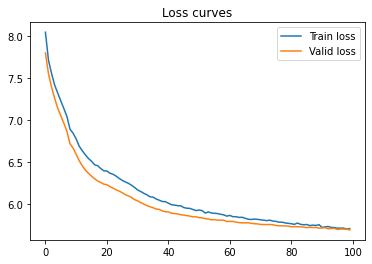

In [16]:
import matplotlib.pyplot as plt
epochs = np.array(list(range(len(best_plot_cache))))
plt.plot(epochs, [i[0] for i in best_plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in best_plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

In [17]:
torch.save({'options': options,
            'loss_cache': best_plot_cache,
            'model_dict': best_model.state_dict()
            }, '../content/drive/My Drive/wiki_lstm_2.pt')

##### Model 3

input_size = 256, hidden_size = 512, num_layers = 3

In [ ]:
import torch.optim as optim

model = models[2]
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

plot_cache = []
max_patience = 3
epochs_no_improve = 0
early_stop = False
last_val_loss = 100

for epoch_number in range(100):
    print(epoch_number)
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wiki_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(wiki_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    if avg_val_loss < last_val_loss:
  # Save the model
             #torch.save(model)
             best_model = model
             best_plot_cache = plot_cache
             epochs_no_improve = 0
    else:
      epochs_no_improve += 1
    
    last_val_loss = avg_val_loss

    if epoch_number > 2 and epochs_no_improve >= max_patience:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
    break
    
    if early_stop:
        print("Stopped")
        break
    
    if load_pretrained:
        break

0
Step 0 avg train loss = 10.4063
Step 100 avg train loss = 10.3781
Step 200 avg train loss = 10.1891
Step 300 avg train loss = 9.3500
Step 400 avg train loss = 8.5569
Step 500 avg train loss = 8.2117
Step 600 avg train loss = 7.9767
Validation loss after 0 epoch = 7.8536
1
Step 0 avg train loss = 7.8992
Step 100 avg train loss = 7.8736
Step 200 avg train loss = 7.8021
Step 300 avg train loss = 7.7427
Step 400 avg train loss = 7.6787
Step 500 avg train loss = 7.6418
Step 600 avg train loss = 7.5829
Validation loss after 1 epoch = 7.4309
2
Step 0 avg train loss = 7.5368
Step 100 avg train loss = 7.5456
Step 200 avg train loss = 7.4925
Step 300 avg train loss = 7.4421
Step 400 avg train loss = 7.3952
Step 500 avg train loss = 7.3603
Step 600 avg train loss = 7.3025
Validation loss after 2 epoch = 7.1087
3
Step 0 avg train loss = 7.2534
Step 100 avg train loss = 7.2489
Step 200 avg train loss = 7.1939
Step 300 avg train loss = 7.1780
Step 400 avg train loss = 7.1390
Step 500 avg train los

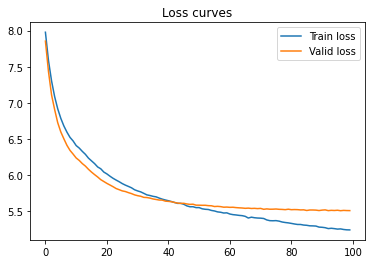

In [ ]:
import matplotlib.pyplot as plt
epochs = np.array(list(range(len(best_plot_cache))))
plt.plot(epochs, [i[0] for i in best_plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in best_plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

In [ ]:
torch.save({'options': options,
            'loss_cache': best_plot_cache,
            'model_dict': best_model.state_dict()
            }, '../content/drive/My Drive/Colab Notebooks/wiki_lstm_3.pt')

##### Model 4

input_size = 256, hidden_size = 512, num_layers = 5

In [ ]:
import torch.optim as optim

model = models[3]
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

plot_cache = []
max_patience = 3
epochs_no_improve = 0
early_stop = False
last_val_loss = 100

for epoch_number in range(100):
    print(epoch_number)
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        train_log_cache = []
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['train'])):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in tqdm(enumerate(wiki_loaders['valid'])):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))
    
    if avg_val_loss < last_val_loss:
  # Save the model
             #torch.save(model)
             best_model = model
             best_plot_cache = plot_cache
             epochs_no_improve = 0
    else:
      epochs_no_improve += 1
    
    last_val_loss = avg_val_loss

    if epoch_number > 2 and epochs_no_improve >= max_patience:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
    break
    
    if early_stop:
        print("Stopped")
        break
    
    if load_pretrained:
        break

0it [00:00, ?it/s]

0


1it [00:00,  1.81it/s]

Step 0 avg train loss = 10.4058


101it [00:50,  2.12it/s]

Step 100 avg train loss = 10.3778


201it [01:39,  2.14it/s]

Step 200 avg train loss = 10.1983


301it [02:31,  2.02it/s]

Step 300 avg train loss = 9.4120


401it [03:21,  1.93it/s]

Step 400 avg train loss = 8.5655


501it [04:11,  2.09it/s]

Step 500 avg train loss = 8.2418


601it [05:02,  1.89it/s]

Step 600 avg train loss = 7.9981


612it [05:08,  1.99it/s]
67it [00:12,  5.43it/s]
0it [00:00, ?it/s]

Validation loss after 0 epoch = 7.8620
1


1it [00:00,  1.77it/s]

Step 0 avg train loss = 7.9877


101it [00:52,  2.20it/s]

Step 100 avg train loss = 7.8992


201it [01:43,  1.83it/s]

Step 200 avg train loss = 7.8217


301it [02:36,  1.91it/s]

Step 300 avg train loss = 7.7632


401it [03:26,  2.15it/s]

Step 400 avg train loss = 7.7273


501it [04:16,  1.86it/s]

Step 500 avg train loss = 7.6920


601it [05:07,  2.00it/s]

Step 600 avg train loss = 7.6524


612it [05:13,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 1 epoch = 7.4997
2


1it [00:00,  1.79it/s]

Step 0 avg train loss = 7.6639


101it [00:52,  1.97it/s]

Step 100 avg train loss = 7.6354


201it [01:43,  1.99it/s]

Step 200 avg train loss = 7.5917


301it [02:34,  2.07it/s]

Step 300 avg train loss = 7.5684


401it [03:25,  1.52it/s]

Step 400 avg train loss = 7.5409


501it [04:16,  2.07it/s]

Step 500 avg train loss = 7.5140


601it [05:07,  2.04it/s]

Step 600 avg train loss = 7.5014


612it [05:12,  1.96it/s]
67it [00:12,  5.35it/s]
0it [00:00, ?it/s]

Validation loss after 2 epoch = 7.3282
3


1it [00:00,  2.51it/s]

Step 0 avg train loss = 7.4847


101it [00:51,  2.18it/s]

Step 100 avg train loss = 7.4705


201it [01:43,  1.88it/s]

Step 200 avg train loss = 7.4494


301it [02:33,  1.85it/s]

Step 300 avg train loss = 7.4344


401it [03:24,  2.19it/s]

Step 400 avg train loss = 7.4168


501it [04:15,  1.91it/s]

Step 500 avg train loss = 7.3930


601it [05:07,  1.97it/s]

Step 600 avg train loss = 7.3636


612it [05:12,  1.96it/s]
67it [00:12,  5.33it/s]
0it [00:00, ?it/s]

Validation loss after 3 epoch = 7.2002
4


1it [00:00,  1.86it/s]

Step 0 avg train loss = 7.3807


101it [00:52,  1.86it/s]

Step 100 avg train loss = 7.3531


201it [01:42,  2.04it/s]

Step 200 avg train loss = 7.3273


301it [02:35,  1.83it/s]

Step 300 avg train loss = 7.3175


401it [03:26,  1.84it/s]

Step 400 avg train loss = 7.3030


501it [04:17,  1.83it/s]

Step 500 avg train loss = 7.2811


601it [05:08,  1.94it/s]

Step 600 avg train loss = 7.2678


612it [05:13,  1.95it/s]
67it [00:12,  5.35it/s]
0it [00:00, ?it/s]

Validation loss after 4 epoch = 7.0757
5


1it [00:00,  1.83it/s]

Step 0 avg train loss = 7.1427


101it [00:52,  1.88it/s]

Step 100 avg train loss = 7.2375


201it [01:42,  2.02it/s]

Step 200 avg train loss = 7.2110


301it [02:33,  2.02it/s]

Step 300 avg train loss = 7.1916


401it [03:26,  1.84it/s]

Step 400 avg train loss = 7.1787


501it [04:17,  2.03it/s]

Step 500 avg train loss = 7.1482


601it [05:07,  1.98it/s]

Step 600 avg train loss = 7.1414


612it [05:13,  1.95it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 5 epoch = 6.9580
6


1it [00:00,  1.99it/s]

Step 0 avg train loss = 7.1624


101it [00:51,  1.91it/s]

Step 100 avg train loss = 7.1138


201it [01:43,  1.91it/s]

Step 200 avg train loss = 7.1044


301it [02:33,  2.04it/s]

Step 300 avg train loss = 7.0750


401it [03:24,  2.00it/s]

Step 400 avg train loss = 7.0560


501it [04:15,  2.19it/s]

Step 500 avg train loss = 7.0289


601it [05:05,  1.92it/s]

Step 600 avg train loss = 7.0036


612it [05:11,  1.97it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 6 epoch = 6.8113
7


1it [00:00,  2.55it/s]

Step 0 avg train loss = 6.9328


101it [00:50,  1.95it/s]

Step 100 avg train loss = 6.9665


201it [01:42,  2.28it/s]

Step 200 avg train loss = 6.9230


301it [02:33,  1.90it/s]

Step 300 avg train loss = 6.8972


401it [03:24,  1.93it/s]

Step 400 avg train loss = 6.8850


501it [04:15,  2.04it/s]

Step 500 avg train loss = 6.8656


601it [05:08,  1.69it/s]

Step 600 avg train loss = 6.8611


612it [05:13,  1.95it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 7 epoch = 6.6874
8


1it [00:00,  2.36it/s]

Step 0 avg train loss = 6.9076


101it [00:49,  2.25it/s]

Step 100 avg train loss = 6.8309


201it [01:40,  1.92it/s]

Step 200 avg train loss = 6.8256


301it [02:31,  2.12it/s]

Step 300 avg train loss = 6.8180


401it [03:22,  2.30it/s]

Step 400 avg train loss = 6.8046


501it [04:13,  1.79it/s]

Step 500 avg train loss = 6.7785


601it [05:04,  1.82it/s]

Step 600 avg train loss = 6.7808


612it [05:10,  1.97it/s]
67it [00:12,  5.40it/s]
0it [00:00, ?it/s]

Validation loss after 8 epoch = 6.5980
9


1it [00:00,  1.93it/s]

Step 0 avg train loss = 6.7386


101it [00:50,  2.13it/s]

Step 100 avg train loss = 6.7587


201it [01:42,  1.81it/s]

Step 200 avg train loss = 6.7541


301it [02:33,  2.08it/s]

Step 300 avg train loss = 6.7379


401it [03:24,  1.96it/s]

Step 400 avg train loss = 6.7241


501it [04:15,  1.97it/s]

Step 500 avg train loss = 6.7200


601it [05:07,  2.05it/s]

Step 600 avg train loss = 6.6975


612it [05:12,  1.96it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 9 epoch = 6.5251
10


1it [00:00,  1.77it/s]

Step 0 avg train loss = 6.5619


101it [00:52,  1.90it/s]

Step 100 avg train loss = 6.6919


201it [01:44,  1.91it/s]

Step 200 avg train loss = 6.6797


301it [02:35,  2.11it/s]

Step 300 avg train loss = 6.6745


401it [03:25,  2.17it/s]

Step 400 avg train loss = 6.6680


501it [04:16,  1.80it/s]

Step 500 avg train loss = 6.6478


601it [05:07,  1.95it/s]

Step 600 avg train loss = 6.6343


612it [05:12,  1.96it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 10 epoch = 6.4599
11


1it [00:00,  1.36it/s]

Step 0 avg train loss = 6.6654


101it [00:52,  1.93it/s]

Step 100 avg train loss = 6.6261


201it [01:43,  2.11it/s]

Step 200 avg train loss = 6.6205


301it [02:33,  2.01it/s]

Step 300 avg train loss = 6.6076


401it [03:24,  1.88it/s]

Step 400 avg train loss = 6.6069


501it [04:15,  1.90it/s]

Step 500 avg train loss = 6.5976


601it [05:07,  2.02it/s]

Step 600 avg train loss = 6.5832


612it [05:12,  1.96it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 11 epoch = 6.4103
12


1it [00:00,  1.62it/s]

Step 0 avg train loss = 6.6227


101it [00:50,  1.90it/s]

Step 100 avg train loss = 6.5736


201it [01:42,  1.97it/s]

Step 200 avg train loss = 6.5664


301it [02:33,  1.84it/s]

Step 300 avg train loss = 6.5617


401it [03:26,  1.81it/s]

Step 400 avg train loss = 6.5541


501it [04:17,  1.88it/s]

Step 500 avg train loss = 6.5481


601it [05:08,  2.07it/s]

Step 600 avg train loss = 6.5429


612it [05:13,  1.95it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 12 epoch = 6.3658
13


1it [00:00,  2.47it/s]

Step 0 avg train loss = 6.5467


101it [00:51,  1.86it/s]

Step 100 avg train loss = 6.5357


201it [01:44,  2.00it/s]

Step 200 avg train loss = 6.5264


301it [02:36,  1.81it/s]

Step 300 avg train loss = 6.5255


401it [03:27,  1.95it/s]

Step 400 avg train loss = 6.5110


501it [04:16,  2.26it/s]

Step 500 avg train loss = 6.5045


601it [05:07,  2.15it/s]

Step 600 avg train loss = 6.5080


612it [05:12,  1.96it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 13 epoch = 6.3261
14


1it [00:00,  1.85it/s]

Step 0 avg train loss = 6.5768


101it [00:52,  1.94it/s]

Step 100 avg train loss = 6.4956


201it [01:44,  2.09it/s]

Step 200 avg train loss = 6.4863


301it [02:36,  2.07it/s]

Step 300 avg train loss = 6.4770


401it [03:27,  2.00it/s]

Step 400 avg train loss = 6.4801


501it [04:17,  1.89it/s]

Step 500 avg train loss = 6.4716


601it [05:08,  1.95it/s]

Step 600 avg train loss = 6.4698


612it [05:13,  1.95it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 14 epoch = 6.2981
15


1it [00:00,  1.84it/s]

Step 0 avg train loss = 6.5773


101it [00:52,  1.74it/s]

Step 100 avg train loss = 6.4558


201it [01:43,  2.12it/s]

Step 200 avg train loss = 6.4555


301it [02:36,  1.55it/s]

Step 300 avg train loss = 6.4498


401it [03:26,  1.66it/s]

Step 400 avg train loss = 6.4417


501it [04:18,  1.95it/s]

Step 500 avg train loss = 6.4377


601it [05:08,  1.91it/s]

Step 600 avg train loss = 6.4363


612it [05:13,  1.95it/s]
67it [00:12,  5.33it/s]
0it [00:00, ?it/s]

Validation loss after 15 epoch = 6.2637
16


1it [00:00,  1.71it/s]

Step 0 avg train loss = 6.4530


101it [00:52,  2.10it/s]

Step 100 avg train loss = 6.4206


201it [01:43,  1.86it/s]

Step 200 avg train loss = 6.4263


301it [02:36,  1.94it/s]

Step 300 avg train loss = 6.4145


401it [03:26,  2.01it/s]

Step 400 avg train loss = 6.4258


501it [04:17,  1.75it/s]

Step 500 avg train loss = 6.4053


601it [05:07,  2.05it/s]

Step 600 avg train loss = 6.4052


612it [05:12,  1.96it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 16 epoch = 6.2422
17


1it [00:00,  1.74it/s]

Step 0 avg train loss = 6.3827


101it [00:51,  2.12it/s]

Step 100 avg train loss = 6.3983


201it [01:43,  1.85it/s]

Step 200 avg train loss = 6.3925


301it [02:33,  1.90it/s]

Step 300 avg train loss = 6.3854


401it [03:24,  1.92it/s]

Step 400 avg train loss = 6.3892


501it [04:15,  2.28it/s]

Step 500 avg train loss = 6.3894


601it [05:07,  1.90it/s]

Step 600 avg train loss = 6.3914


612it [05:13,  1.95it/s]
67it [00:12,  5.19it/s]
0it [00:00, ?it/s]

Validation loss after 17 epoch = 6.2219
18


1it [00:00,  1.83it/s]

Step 0 avg train loss = 6.3169


101it [00:51,  1.92it/s]

Step 100 avg train loss = 6.3710


201it [01:43,  1.96it/s]

Step 200 avg train loss = 6.3803


301it [02:36,  1.86it/s]

Step 300 avg train loss = 6.3729


401it [03:26,  1.97it/s]

Step 400 avg train loss = 6.3634


501it [04:17,  2.23it/s]

Step 500 avg train loss = 6.3598


601it [05:07,  2.09it/s]

Step 600 avg train loss = 6.3512


612it [05:12,  1.96it/s]
67it [00:12,  5.34it/s]
0it [00:00, ?it/s]

Validation loss after 18 epoch = 6.1950
19


1it [00:00,  2.18it/s]

Step 0 avg train loss = 6.3994


101it [00:49,  2.14it/s]

Step 100 avg train loss = 6.3439


201it [01:40,  2.05it/s]

Step 200 avg train loss = 6.3472


301it [02:31,  1.75it/s]

Step 300 avg train loss = 6.3442


401it [03:23,  1.89it/s]

Step 400 avg train loss = 6.3460


501it [04:15,  1.84it/s]

Step 500 avg train loss = 6.3470


601it [05:07,  1.79it/s]

Step 600 avg train loss = 6.3346


612it [05:12,  1.96it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 19 epoch = 6.1777
20


1it [00:00,  1.40it/s]

Step 0 avg train loss = 6.3121


101it [00:51,  2.08it/s]

Step 100 avg train loss = 6.3283


201it [01:42,  2.12it/s]

Step 200 avg train loss = 6.3242


301it [02:34,  1.95it/s]

Step 300 avg train loss = 6.3252


401it [03:26,  2.00it/s]

Step 400 avg train loss = 6.3176


501it [04:16,  2.08it/s]

Step 500 avg train loss = 6.3255


601it [05:06,  2.05it/s]

Step 600 avg train loss = 6.3194


612it [05:12,  1.96it/s]
67it [00:12,  5.24it/s]
0it [00:00, ?it/s]

Validation loss after 20 epoch = 6.1602
21


1it [00:00,  1.18it/s]

Step 0 avg train loss = 6.2956


101it [00:51,  1.99it/s]

Step 100 avg train loss = 6.3179


201it [01:42,  2.06it/s]

Step 200 avg train loss = 6.3078


301it [02:33,  1.85it/s]

Step 300 avg train loss = 6.3024


401it [03:23,  2.03it/s]

Step 400 avg train loss = 6.2995


501it [04:16,  1.92it/s]

Step 500 avg train loss = 6.3026


601it [05:08,  1.83it/s]

Step 600 avg train loss = 6.3056


612it [05:14,  1.95it/s]
67it [00:12,  5.27it/s]
0it [00:00, ?it/s]

Validation loss after 21 epoch = 6.1527
22


1it [00:00,  2.21it/s]

Step 0 avg train loss = 6.2848


101it [00:51,  1.95it/s]

Step 100 avg train loss = 6.2967


201it [01:43,  1.82it/s]

Step 200 avg train loss = 6.2900


301it [02:33,  1.98it/s]

Step 300 avg train loss = 6.2978


401it [03:23,  2.16it/s]

Step 400 avg train loss = 6.2899


501it [04:16,  1.85it/s]

Step 500 avg train loss = 6.2829


601it [05:08,  1.98it/s]

Step 600 avg train loss = 6.2834


612it [05:13,  1.95it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 22 epoch = 6.1317
23


1it [00:00,  1.55it/s]

Step 0 avg train loss = 6.3839


101it [00:51,  2.07it/s]

Step 100 avg train loss = 6.2837


201it [01:42,  2.15it/s]

Step 200 avg train loss = 6.2675


301it [02:32,  2.06it/s]

Step 300 avg train loss = 6.2774


401it [03:23,  2.02it/s]

Step 400 avg train loss = 6.2705


501it [04:15,  1.96it/s]

Step 500 avg train loss = 6.2654


601it [05:07,  1.56it/s]

Step 600 avg train loss = 6.2689


612it [05:12,  1.96it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 23 epoch = 6.1182
24


1it [00:00,  2.18it/s]

Step 0 avg train loss = 6.2386


101it [00:50,  1.97it/s]

Step 100 avg train loss = 6.2517


201it [01:41,  1.83it/s]

Step 200 avg train loss = 6.2578


301it [02:33,  1.91it/s]

Step 300 avg train loss = 6.2577


401it [03:24,  1.92it/s]

Step 400 avg train loss = 6.2555


501it [04:14,  1.85it/s]

Step 500 avg train loss = 6.2514


601it [05:06,  1.95it/s]

Step 600 avg train loss = 6.2481


612it [05:12,  1.96it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 24 epoch = 6.1046
25


1it [00:00,  2.56it/s]

Step 0 avg train loss = 6.2824


101it [00:51,  1.85it/s]

Step 100 avg train loss = 6.2469


201it [01:43,  1.65it/s]

Step 200 avg train loss = 6.2447


301it [02:34,  2.14it/s]

Step 300 avg train loss = 6.2314


401it [03:27,  2.08it/s]

Step 400 avg train loss = 6.2311


501it [04:17,  2.09it/s]

Step 500 avg train loss = 6.2303


601it [05:08,  2.11it/s]

Step 600 avg train loss = 6.2171


612it [05:14,  1.94it/s]
67it [00:12,  5.27it/s]
0it [00:00, ?it/s]

Validation loss after 25 epoch = 6.0906
26


1it [00:00,  2.59it/s]

Step 0 avg train loss = 6.2174


101it [00:52,  1.78it/s]

Step 100 avg train loss = 6.2170


201it [01:44,  1.73it/s]

Step 200 avg train loss = 6.2159


301it [02:35,  1.97it/s]

Step 300 avg train loss = 6.2227


401it [03:26,  1.85it/s]

Step 400 avg train loss = 6.2097


501it [04:16,  2.19it/s]

Step 500 avg train loss = 6.2102


601it [05:08,  1.67it/s]

Step 600 avg train loss = 6.1968


612it [05:14,  1.95it/s]
67it [00:12,  5.24it/s]
0it [00:00, ?it/s]

Validation loss after 26 epoch = 6.0666
27


1it [00:00,  2.11it/s]

Step 0 avg train loss = 6.2112


101it [00:53,  1.97it/s]

Step 100 avg train loss = 6.1862


201it [01:45,  1.88it/s]

Step 200 avg train loss = 6.1948


301it [02:37,  1.96it/s]

Step 300 avg train loss = 6.1896


401it [03:28,  2.05it/s]

Step 400 avg train loss = 6.1834


501it [04:17,  2.00it/s]

Step 500 avg train loss = 6.1803


601it [05:08,  1.84it/s]

Step 600 avg train loss = 6.1902


612it [05:13,  1.95it/s]
67it [00:12,  5.27it/s]
0it [00:00, ?it/s]

Validation loss after 27 epoch = 6.0476
28


1it [00:00,  1.90it/s]

Step 0 avg train loss = 6.1744


101it [00:51,  2.13it/s]

Step 100 avg train loss = 6.1782


201it [01:43,  2.13it/s]

Step 200 avg train loss = 6.1651


301it [02:35,  1.90it/s]

Step 300 avg train loss = 6.1720


401it [03:28,  1.71it/s]

Step 400 avg train loss = 6.1689


501it [04:19,  2.13it/s]

Step 500 avg train loss = 6.1525


601it [05:09,  1.86it/s]

Step 600 avg train loss = 6.1589


612it [05:14,  1.95it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 28 epoch = 6.0254
29


1it [00:00,  2.20it/s]

Step 0 avg train loss = 6.1689


101it [00:51,  2.01it/s]

Step 100 avg train loss = 6.1477


201it [01:42,  2.04it/s]

Step 200 avg train loss = 6.1443


301it [02:33,  2.14it/s]

Step 300 avg train loss = 6.1442


401it [03:24,  2.08it/s]

Step 400 avg train loss = 6.1421


501it [04:15,  2.02it/s]

Step 500 avg train loss = 6.1418


601it [05:07,  2.13it/s]

Step 600 avg train loss = 6.1428


612it [05:12,  1.96it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 29 epoch = 6.0084
30


1it [00:00,  2.26it/s]

Step 0 avg train loss = 6.1591


101it [00:52,  1.86it/s]

Step 100 avg train loss = 6.1298


201it [01:43,  1.90it/s]

Step 200 avg train loss = 6.1275


301it [02:35,  1.70it/s]

Step 300 avg train loss = 6.1283


401it [03:27,  1.97it/s]

Step 400 avg train loss = 6.1199


501it [04:18,  2.17it/s]

Step 500 avg train loss = 6.1153


601it [05:09,  2.05it/s]

Step 600 avg train loss = 6.1168


612it [05:14,  1.95it/s]
67it [00:12,  5.24it/s]
0it [00:00, ?it/s]

Validation loss after 30 epoch = 5.9885
31


1it [00:00,  1.79it/s]

Step 0 avg train loss = 6.0788


101it [00:52,  1.99it/s]

Step 100 avg train loss = 6.1076


201it [01:43,  2.00it/s]

Step 200 avg train loss = 6.1004


301it [02:34,  2.03it/s]

Step 300 avg train loss = 6.0987


401it [03:27,  1.90it/s]

Step 400 avg train loss = 6.0965


501it [04:18,  2.11it/s]

Step 500 avg train loss = 6.0894


601it [05:09,  1.85it/s]

Step 600 avg train loss = 6.0968


612it [05:14,  1.95it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 31 epoch = 5.9739
32


1it [00:00,  1.62it/s]

Step 0 avg train loss = 6.0561


101it [00:51,  1.78it/s]

Step 100 avg train loss = 6.0791


201it [01:41,  2.29it/s]

Step 200 avg train loss = 6.0805


301it [02:33,  2.12it/s]

Step 300 avg train loss = 6.0693


401it [03:24,  2.11it/s]

Step 400 avg train loss = 6.0727


501it [04:15,  1.89it/s]

Step 500 avg train loss = 6.0732


601it [05:07,  1.96it/s]

Step 600 avg train loss = 6.0794


612it [05:12,  1.96it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 32 epoch = 5.9550
33


1it [00:00,  1.72it/s]

Step 0 avg train loss = 6.0225


101it [00:53,  2.00it/s]

Step 100 avg train loss = 6.0756


201it [01:45,  1.86it/s]

Step 200 avg train loss = 6.0558


301it [02:35,  2.08it/s]

Step 300 avg train loss = 6.0567


401it [03:25,  1.86it/s]

Step 400 avg train loss = 6.0531


501it [04:16,  1.95it/s]

Step 500 avg train loss = 6.0535


601it [05:09,  1.90it/s]

Step 600 avg train loss = 6.0374


612it [05:14,  1.95it/s]
67it [00:12,  5.24it/s]
0it [00:00, ?it/s]

Validation loss after 33 epoch = 5.9337
34


1it [00:00,  2.14it/s]

Step 0 avg train loss = 6.0369


101it [00:52,  1.83it/s]

Step 100 avg train loss = 6.0434


201it [01:42,  1.78it/s]

Step 200 avg train loss = 6.0503


301it [02:33,  2.14it/s]

Step 300 avg train loss = 6.0357


401it [03:25,  2.05it/s]

Step 400 avg train loss = 6.0246


501it [04:17,  1.79it/s]

Step 500 avg train loss = 6.0348


601it [05:10,  1.86it/s]

Step 600 avg train loss = 6.0361


612it [05:15,  1.94it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 34 epoch = 5.9222
35


1it [00:00,  2.25it/s]

Step 0 avg train loss = 6.0045


101it [00:52,  1.98it/s]

Step 100 avg train loss = 6.0279


201it [01:43,  2.02it/s]

Step 200 avg train loss = 6.0147


301it [02:34,  1.84it/s]

Step 300 avg train loss = 6.0212


401it [03:24,  2.09it/s]

Step 400 avg train loss = 6.0291


501it [04:16,  2.03it/s]

Step 500 avg train loss = 6.0183


601it [05:07,  1.91it/s]

Step 600 avg train loss = 6.0144


612it [05:12,  1.96it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 35 epoch = 5.9137
36


1it [00:00,  1.91it/s]

Step 0 avg train loss = 5.9509


101it [00:51,  1.88it/s]

Step 100 avg train loss = 5.9915


201it [01:42,  2.10it/s]

Step 200 avg train loss = 6.0035


301it [02:34,  2.03it/s]

Step 300 avg train loss = 6.0053


401it [03:25,  1.98it/s]

Step 400 avg train loss = 6.0100


501it [04:18,  1.92it/s]

Step 500 avg train loss = 5.9960


601it [05:08,  1.86it/s]

Step 600 avg train loss = 5.9940


612it [05:13,  1.95it/s]
67it [00:12,  5.32it/s]
0it [00:00, ?it/s]

Validation loss after 36 epoch = 5.8958
37


1it [00:00,  1.94it/s]

Step 0 avg train loss = 6.1881


101it [00:52,  1.95it/s]

Step 100 avg train loss = 5.9884


201it [01:44,  2.02it/s]

Step 200 avg train loss = 5.9754


301it [02:35,  1.77it/s]

Step 300 avg train loss = 5.9817


401it [03:27,  1.91it/s]

Step 400 avg train loss = 5.9838


501it [04:19,  1.87it/s]

Step 500 avg train loss = 5.9759


601it [05:09,  1.78it/s]

Step 600 avg train loss = 5.9796


612it [05:14,  1.95it/s]
67it [00:12,  5.28it/s]
0it [00:00, ?it/s]

Validation loss after 37 epoch = 5.8773
38


1it [00:00,  1.98it/s]

Step 0 avg train loss = 6.0012


101it [00:52,  1.82it/s]

Step 100 avg train loss = 5.9677


201it [01:44,  2.06it/s]

Step 200 avg train loss = 5.9624


301it [02:36,  2.29it/s]

Step 300 avg train loss = 5.9594


401it [03:26,  2.29it/s]

Step 400 avg train loss = 5.9671


501it [04:18,  1.85it/s]

Step 500 avg train loss = 5.9616


601it [05:10,  1.83it/s]

Step 600 avg train loss = 5.9682


612it [05:15,  1.94it/s]
67it [00:12,  5.22it/s]
0it [00:00, ?it/s]

Validation loss after 38 epoch = 5.8681
39


1it [00:00,  1.85it/s]

Step 0 avg train loss = 5.9705


101it [00:52,  2.00it/s]

Step 100 avg train loss = 5.9430


201it [01:43,  1.68it/s]

Step 200 avg train loss = 5.9537


301it [02:34,  1.75it/s]

Step 300 avg train loss = 5.9402


401it [03:24,  2.00it/s]

Step 400 avg train loss = 5.9537


501it [04:15,  1.92it/s]

Step 500 avg train loss = 5.9512


601it [05:07,  1.95it/s]

Step 600 avg train loss = 5.9552


612it [05:13,  1.95it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 39 epoch = 5.8566
40


1it [00:00,  2.61it/s]

Step 0 avg train loss = 5.9461


101it [00:52,  2.16it/s]

Step 100 avg train loss = 5.9458


201it [01:43,  1.88it/s]

Step 200 avg train loss = 5.9395


301it [02:36,  2.00it/s]

Step 300 avg train loss = 5.9377


401it [03:29,  1.97it/s]

Step 400 avg train loss = 5.9288


501it [04:19,  2.17it/s]

Step 500 avg train loss = 5.9396


601it [05:10,  2.04it/s]

Step 600 avg train loss = 5.9281


612it [05:15,  1.94it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 40 epoch = 5.8479
41


1it [00:00,  1.28it/s]

Step 0 avg train loss = 5.9820


101it [00:52,  1.96it/s]

Step 100 avg train loss = 5.9249


201it [01:42,  1.93it/s]

Step 200 avg train loss = 5.9232


301it [02:33,  1.85it/s]

Step 300 avg train loss = 5.9280


401it [03:25,  1.95it/s]

Step 400 avg train loss = 5.9224


501it [04:17,  1.87it/s]

Step 500 avg train loss = 5.9159


601it [05:08,  1.98it/s]

Step 600 avg train loss = 5.9170


612it [05:13,  1.95it/s]
67it [00:12,  5.33it/s]
0it [00:00, ?it/s]

Validation loss after 41 epoch = 5.8405
42


1it [00:00,  2.65it/s]

Step 0 avg train loss = 5.9495


101it [00:52,  1.82it/s]

Step 100 avg train loss = 5.9106


201it [01:43,  1.75it/s]

Step 200 avg train loss = 5.9066


301it [02:35,  1.89it/s]

Step 300 avg train loss = 5.9097


401it [03:27,  2.08it/s]

Step 400 avg train loss = 5.9082


501it [04:19,  1.84it/s]

Step 500 avg train loss = 5.9065


601it [05:10,  1.93it/s]

Step 600 avg train loss = 5.9079


612it [05:15,  1.94it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 42 epoch = 5.8348
43


1it [00:00,  2.44it/s]

Step 0 avg train loss = 5.9399


101it [00:52,  1.81it/s]

Step 100 avg train loss = 5.8926


201it [01:41,  1.94it/s]

Step 200 avg train loss = 5.9001


301it [02:33,  1.90it/s]

Step 300 avg train loss = 5.8974


401it [03:27,  2.00it/s]

Step 400 avg train loss = 5.9083


501it [04:19,  2.03it/s]

Step 500 avg train loss = 5.8870


601it [05:10,  1.98it/s]

Step 600 avg train loss = 5.8914


612it [05:16,  1.94it/s]
67it [00:12,  5.28it/s]
0it [00:00, ?it/s]

Validation loss after 43 epoch = 5.8198
44


1it [00:00,  2.17it/s]

Step 0 avg train loss = 5.8868


101it [00:50,  1.78it/s]

Step 100 avg train loss = 5.8892


201it [01:42,  1.75it/s]

Step 200 avg train loss = 5.8777


301it [02:34,  1.87it/s]

Step 300 avg train loss = 5.8886


401it [03:26,  1.91it/s]

Step 400 avg train loss = 5.8822


501it [04:17,  1.72it/s]

Step 500 avg train loss = 5.8914


601it [05:07,  1.92it/s]

Step 600 avg train loss = 5.8772


612it [05:13,  1.95it/s]
67it [00:12,  5.34it/s]
0it [00:00, ?it/s]

Validation loss after 44 epoch = 5.8122
45


1it [00:00,  1.93it/s]

Step 0 avg train loss = 5.8155


101it [00:51,  2.12it/s]

Step 100 avg train loss = 5.8691


201it [01:42,  2.00it/s]

Step 200 avg train loss = 5.8768


301it [02:33,  2.15it/s]

Step 300 avg train loss = 5.8700


401it [03:25,  2.04it/s]

Step 400 avg train loss = 5.8746


501it [04:17,  2.11it/s]

Step 500 avg train loss = 5.8745


601it [05:08,  1.98it/s]

Step 600 avg train loss = 5.8725


612it [05:13,  1.95it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 45 epoch = 5.8030
46


1it [00:00,  2.16it/s]

Step 0 avg train loss = 5.8952


101it [00:52,  2.06it/s]

Step 100 avg train loss = 5.8664


201it [01:43,  1.79it/s]

Step 200 avg train loss = 5.8564


301it [02:34,  1.82it/s]

Step 300 avg train loss = 5.8629


401it [03:26,  1.95it/s]

Step 400 avg train loss = 5.8551


501it [04:16,  1.91it/s]

Step 500 avg train loss = 5.8663


601it [05:08,  1.96it/s]

Step 600 avg train loss = 5.8700


612it [05:13,  1.95it/s]
67it [00:12,  5.33it/s]
0it [00:00, ?it/s]

Validation loss after 46 epoch = 5.8021
47


1it [00:00,  2.22it/s]

Step 0 avg train loss = 5.7177


101it [00:52,  1.90it/s]

Step 100 avg train loss = 5.8515


201it [01:43,  2.09it/s]

Step 200 avg train loss = 5.8533


301it [02:34,  1.90it/s]

Step 300 avg train loss = 5.8546


401it [03:25,  1.98it/s]

Step 400 avg train loss = 5.8575


501it [04:16,  1.82it/s]

Step 500 avg train loss = 5.8523


601it [05:09,  1.76it/s]

Step 600 avg train loss = 5.8588


612it [05:15,  1.94it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 47 epoch = 5.7934
48


1it [00:00,  1.72it/s]

Step 0 avg train loss = 5.8794


101it [00:51,  1.79it/s]

Step 100 avg train loss = 5.8505


201it [01:43,  1.94it/s]

Step 200 avg train loss = 5.8511


301it [02:35,  1.78it/s]

Step 300 avg train loss = 5.8411


401it [03:27,  1.86it/s]

Step 400 avg train loss = 5.8473


501it [04:17,  2.06it/s]

Step 500 avg train loss = 5.8410


601it [05:09,  1.81it/s]

Step 600 avg train loss = 5.8409


612it [05:14,  1.94it/s]
67it [00:12,  5.22it/s]
0it [00:00, ?it/s]

Validation loss after 48 epoch = 5.7874
49


1it [00:00,  2.39it/s]

Step 0 avg train loss = 5.7999


101it [00:52,  1.93it/s]

Step 100 avg train loss = 5.8381


201it [01:43,  1.79it/s]

Step 200 avg train loss = 5.8414


301it [02:35,  2.19it/s]

Step 300 avg train loss = 5.8345


401it [03:27,  1.83it/s]

Step 400 avg train loss = 5.8295


501it [04:18,  2.11it/s]

Step 500 avg train loss = 5.8360


601it [05:08,  1.97it/s]

Step 600 avg train loss = 5.8367


612it [05:13,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 49 epoch = 5.7835
50


1it [00:00,  2.40it/s]

Step 0 avg train loss = 5.9003


101it [00:51,  2.11it/s]

Step 100 avg train loss = 5.8257


201it [01:42,  1.99it/s]

Step 200 avg train loss = 5.8322


301it [02:33,  2.09it/s]

Step 300 avg train loss = 5.8335


401it [03:24,  1.85it/s]

Step 400 avg train loss = 5.8204


501it [04:17,  1.95it/s]

Step 500 avg train loss = 5.8365


601it [05:09,  1.92it/s]

Step 600 avg train loss = 5.8241


612it [05:15,  1.94it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 50 epoch = 5.7681
51


1it [00:00,  2.12it/s]

Step 0 avg train loss = 5.8590


101it [00:52,  1.64it/s]

Step 100 avg train loss = 5.8129


201it [01:44,  2.01it/s]

Step 200 avg train loss = 5.8219


301it [02:36,  1.99it/s]

Step 300 avg train loss = 5.8213


401it [03:27,  1.98it/s]

Step 400 avg train loss = 5.8114


501it [04:19,  1.68it/s]

Step 500 avg train loss = 5.8174


601it [05:10,  2.03it/s]

Step 600 avg train loss = 5.8181


612it [05:16,  1.94it/s]
67it [00:12,  5.32it/s]
0it [00:00, ?it/s]

Validation loss after 51 epoch = 5.7673
52


1it [00:00,  2.29it/s]

Step 0 avg train loss = 5.8124


101it [00:51,  1.77it/s]

Step 100 avg train loss = 5.8135


201it [01:43,  1.99it/s]

Step 200 avg train loss = 5.8034


301it [02:34,  1.99it/s]

Step 300 avg train loss = 5.8051


401it [03:26,  1.97it/s]

Step 400 avg train loss = 5.8097


501it [04:18,  2.12it/s]

Step 500 avg train loss = 5.7990


601it [05:09,  1.85it/s]

Step 600 avg train loss = 5.8111


612it [05:14,  1.94it/s]
67it [00:12,  5.22it/s]
0it [00:00, ?it/s]

Validation loss after 52 epoch = 5.7609
53


1it [00:00,  1.93it/s]

Step 0 avg train loss = 5.8446


101it [00:52,  2.03it/s]

Step 100 avg train loss = 5.7919


201it [01:43,  1.86it/s]

Step 200 avg train loss = 5.8020


301it [02:34,  1.95it/s]

Step 300 avg train loss = 5.7990


401it [03:26,  1.94it/s]

Step 400 avg train loss = 5.8026


501it [04:18,  1.87it/s]

Step 500 avg train loss = 5.7964


601it [05:11,  1.76it/s]

Step 600 avg train loss = 5.7939


612it [05:16,  1.93it/s]
67it [00:12,  5.19it/s]
0it [00:00, ?it/s]

Validation loss after 53 epoch = 5.7529
54


1it [00:00,  1.80it/s]

Step 0 avg train loss = 5.7357


101it [00:51,  1.66it/s]

Step 100 avg train loss = 5.7906


201it [01:42,  2.08it/s]

Step 200 avg train loss = 5.7861


301it [02:34,  2.01it/s]

Step 300 avg train loss = 5.7891


401it [03:26,  1.80it/s]

Step 400 avg train loss = 5.7870


501it [04:16,  2.14it/s]

Step 500 avg train loss = 5.7862


601it [05:07,  1.84it/s]

Step 600 avg train loss = 5.8006


612it [05:12,  1.96it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 54 epoch = 5.7519
55


1it [00:00,  1.80it/s]

Step 0 avg train loss = 5.8314


101it [00:52,  1.73it/s]

Step 100 avg train loss = 5.7845


201it [01:42,  1.89it/s]

Step 200 avg train loss = 5.7786


301it [02:34,  1.88it/s]

Step 300 avg train loss = 5.7808


401it [03:27,  1.99it/s]

Step 400 avg train loss = 5.7847


501it [04:18,  1.76it/s]

Step 500 avg train loss = 5.7875


601it [05:09,  1.89it/s]

Step 600 avg train loss = 5.7864


612it [05:14,  1.94it/s]
67it [00:12,  5.32it/s]
0it [00:00, ?it/s]

Validation loss after 55 epoch = 5.7534
56


1it [00:00,  1.63it/s]

Step 0 avg train loss = 5.7812


101it [00:51,  2.21it/s]

Step 100 avg train loss = 5.7709


201it [01:43,  1.95it/s]

Step 200 avg train loss = 5.7837


301it [02:34,  2.01it/s]

Step 300 avg train loss = 5.7817


401it [03:25,  2.01it/s]

Step 400 avg train loss = 5.7683


501it [04:18,  2.07it/s]

Step 500 avg train loss = 5.7800


601it [05:09,  1.95it/s]

Step 600 avg train loss = 5.7822


612it [05:14,  1.94it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 56 epoch = 5.7467
57


1it [00:00,  1.71it/s]

Step 0 avg train loss = 5.8055


101it [00:50,  2.11it/s]

Step 100 avg train loss = 5.7725


201it [01:42,  2.28it/s]

Step 200 avg train loss = 5.7709


301it [02:34,  1.95it/s]

Step 300 avg train loss = 5.7668


401it [03:26,  1.78it/s]

Step 400 avg train loss = 5.7736


501it [04:17,  2.14it/s]

Step 500 avg train loss = 5.7788


601it [05:07,  1.85it/s]

Step 600 avg train loss = 5.7641


612it [05:13,  1.95it/s]
67it [00:12,  5.32it/s]
0it [00:00, ?it/s]

Validation loss after 57 epoch = 5.7431
58


1it [00:00,  2.41it/s]

Step 0 avg train loss = 5.8744


101it [00:49,  2.14it/s]

Step 100 avg train loss = 5.7590


201it [01:41,  1.82it/s]

Step 200 avg train loss = 5.7554


301it [02:34,  1.89it/s]

Step 300 avg train loss = 5.7758


401it [03:26,  1.94it/s]

Step 400 avg train loss = 5.7597


501it [04:19,  2.18it/s]

Step 500 avg train loss = 5.7651


601it [05:09,  1.88it/s]

Step 600 avg train loss = 5.7701


612it [05:14,  1.94it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 58 epoch = 5.7385
59


1it [00:00,  1.79it/s]

Step 0 avg train loss = 5.7837


101it [00:52,  1.69it/s]

Step 100 avg train loss = 5.7653


201it [01:44,  1.57it/s]

Step 200 avg train loss = 5.7559


301it [02:35,  1.84it/s]

Step 300 avg train loss = 5.7555


401it [03:26,  1.80it/s]

Step 400 avg train loss = 5.7548


501it [04:18,  1.83it/s]

Step 500 avg train loss = 5.7595


601it [05:10,  2.05it/s]

Step 600 avg train loss = 5.7524


612it [05:16,  1.94it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 59 epoch = 5.7381
60


1it [00:00,  1.89it/s]

Step 0 avg train loss = 5.7192


101it [00:53,  1.94it/s]

Step 100 avg train loss = 5.7502


201it [01:43,  2.12it/s]

Step 200 avg train loss = 5.7542


301it [02:35,  1.92it/s]

Step 300 avg train loss = 5.7468


401it [03:26,  1.83it/s]

Step 400 avg train loss = 5.7464


501it [04:18,  2.01it/s]

Step 500 avg train loss = 5.7574


601it [05:09,  1.91it/s]

Step 600 avg train loss = 5.7547


612it [05:14,  1.94it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 60 epoch = 5.7314
61


1it [00:00,  1.84it/s]

Step 0 avg train loss = 5.6268


101it [00:51,  1.76it/s]

Step 100 avg train loss = 5.7384


201it [01:44,  1.90it/s]

Step 200 avg train loss = 5.7433


301it [02:34,  2.07it/s]

Step 300 avg train loss = 5.7423


401it [03:26,  2.05it/s]

Step 400 avg train loss = 5.7463


501it [04:17,  1.75it/s]

Step 500 avg train loss = 5.7501


601it [05:08,  1.78it/s]

Step 600 avg train loss = 5.7494


612it [05:13,  1.95it/s]
67it [00:12,  5.22it/s]
0it [00:00, ?it/s]

Validation loss after 61 epoch = 5.7252
62


1it [00:00,  1.74it/s]

Step 0 avg train loss = 5.8293


101it [00:52,  1.77it/s]

Step 100 avg train loss = 5.7550


201it [01:42,  1.94it/s]

Step 200 avg train loss = 5.7301


301it [02:35,  1.83it/s]

Step 300 avg train loss = 5.7377


401it [03:26,  1.88it/s]

Step 400 avg train loss = 5.7378


501it [04:17,  1.76it/s]

Step 500 avg train loss = 5.7358


601it [05:07,  2.06it/s]

Step 600 avg train loss = 5.7376


612it [05:12,  1.96it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 62 epoch = 5.7223
63


1it [00:00,  1.88it/s]

Step 0 avg train loss = 5.7005


101it [00:51,  2.04it/s]

Step 100 avg train loss = 5.7312


201it [01:43,  1.86it/s]

Step 200 avg train loss = 5.7400


301it [02:34,  1.86it/s]

Step 300 avg train loss = 5.7292


401it [03:25,  1.97it/s]

Step 400 avg train loss = 5.7341


501it [04:16,  1.96it/s]

Step 500 avg train loss = 5.7239


601it [05:08,  1.87it/s]

Step 600 avg train loss = 5.7338


612it [05:13,  1.95it/s]
67it [00:12,  5.18it/s]
0it [00:00, ?it/s]

Validation loss after 63 epoch = 5.7202
64


1it [00:00,  2.47it/s]

Step 0 avg train loss = 5.7383


101it [00:50,  1.98it/s]

Step 100 avg train loss = 5.7368


201it [01:42,  1.98it/s]

Step 200 avg train loss = 5.7202


301it [02:33,  2.09it/s]

Step 300 avg train loss = 5.7163


401it [03:25,  1.91it/s]

Step 400 avg train loss = 5.7245


501it [04:17,  1.96it/s]

Step 500 avg train loss = 5.7271


601it [05:09,  2.01it/s]

Step 600 avg train loss = 5.7320


612it [05:14,  1.95it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 64 epoch = 5.7165
65


1it [00:00,  2.32it/s]

Step 0 avg train loss = 5.7018


101it [00:51,  1.99it/s]

Step 100 avg train loss = 5.7240


201it [01:43,  1.92it/s]

Step 200 avg train loss = 5.7182


301it [02:33,  2.08it/s]

Step 300 avg train loss = 5.7161


401it [03:25,  2.18it/s]

Step 400 avg train loss = 5.7205


501it [04:16,  1.94it/s]

Step 500 avg train loss = 5.7200


601it [05:08,  1.87it/s]

Step 600 avg train loss = 5.7175


612it [05:14,  1.95it/s]
67it [00:12,  5.17it/s]
0it [00:00, ?it/s]

Validation loss after 65 epoch = 5.7118
66


1it [00:00,  2.46it/s]

Step 0 avg train loss = 5.6803


101it [00:51,  1.81it/s]

Step 100 avg train loss = 5.7210


201it [01:42,  2.02it/s]

Step 200 avg train loss = 5.7099


301it [02:32,  2.00it/s]

Step 300 avg train loss = 5.7001


401it [03:25,  1.97it/s]

Step 400 avg train loss = 5.7199


501it [04:17,  1.87it/s]

Step 500 avg train loss = 5.7178


601it [05:09,  2.22it/s]

Step 600 avg train loss = 5.7156


612it [05:14,  1.95it/s]
67it [00:12,  5.29it/s]
0it [00:00, ?it/s]

Validation loss after 66 epoch = 5.7105
67


1it [00:00,  1.84it/s]

Step 0 avg train loss = 5.7151


101it [00:51,  1.75it/s]

Step 100 avg train loss = 5.7019


201it [01:43,  1.82it/s]

Step 200 avg train loss = 5.7187


301it [02:36,  1.97it/s]

Step 300 avg train loss = 5.7055


401it [03:27,  1.72it/s]

Step 400 avg train loss = 5.7089


501it [04:18,  1.86it/s]

Step 500 avg train loss = 5.7149


601it [05:08,  1.92it/s]

Step 600 avg train loss = 5.6961


612it [05:14,  1.95it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 67 epoch = 5.7053
68


1it [00:00,  1.83it/s]

Step 0 avg train loss = 5.7353


101it [00:50,  2.06it/s]

Step 100 avg train loss = 5.7026


201it [01:43,  1.85it/s]

Step 200 avg train loss = 5.6986


301it [02:33,  2.02it/s]

Step 300 avg train loss = 5.7003


401it [03:26,  1.98it/s]

Step 400 avg train loss = 5.7028


501it [04:17,  1.97it/s]

Step 500 avg train loss = 5.6997


601it [05:08,  1.94it/s]

Step 600 avg train loss = 5.7071


612it [05:14,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 68 epoch = 5.7021
69


1it [00:00,  2.36it/s]

Step 0 avg train loss = 5.6010


101it [00:51,  1.97it/s]

Step 100 avg train loss = 5.6964


201it [01:42,  1.96it/s]

Step 200 avg train loss = 5.6899


301it [02:34,  2.00it/s]

Step 300 avg train loss = 5.6852


401it [03:26,  1.65it/s]

Step 400 avg train loss = 5.7071


501it [04:17,  1.99it/s]

Step 500 avg train loss = 5.6942


601it [05:09,  1.68it/s]

Step 600 avg train loss = 5.7093


612it [05:14,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 69 epoch = 5.7016
70


1it [00:00,  2.16it/s]

Step 0 avg train loss = 5.6070


101it [00:52,  1.84it/s]

Step 100 avg train loss = 5.6892


201it [01:41,  1.98it/s]

Step 200 avg train loss = 5.6942


301it [02:33,  2.07it/s]

Step 300 avg train loss = 5.6933


401it [03:25,  1.83it/s]

Step 400 avg train loss = 5.6882


501it [04:17,  2.07it/s]

Step 500 avg train loss = 5.6923


601it [05:09,  2.00it/s]

Step 600 avg train loss = 5.6946


612it [05:15,  1.94it/s]
67it [00:12,  5.16it/s]
0it [00:00, ?it/s]

Validation loss after 70 epoch = 5.6992
71


1it [00:00,  2.44it/s]

Step 0 avg train loss = 5.6687


101it [00:51,  1.89it/s]

Step 100 avg train loss = 5.6866


201it [01:41,  1.86it/s]

Step 200 avg train loss = 5.6813


301it [02:32,  1.79it/s]

Step 300 avg train loss = 5.6834


401it [03:23,  1.63it/s]

Step 400 avg train loss = 5.6927


501it [04:16,  1.89it/s]

Step 500 avg train loss = 5.6921


601it [05:09,  1.68it/s]

Step 600 avg train loss = 5.6835


612it [05:14,  1.94it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 71 epoch = 5.6940
72


1it [00:00,  2.18it/s]

Step 0 avg train loss = 5.5945


101it [00:52,  1.86it/s]

Step 100 avg train loss = 5.6775


201it [01:45,  1.88it/s]

Step 200 avg train loss = 5.6835


301it [02:36,  2.08it/s]

Step 300 avg train loss = 5.6735


401it [03:27,  1.84it/s]

Step 400 avg train loss = 5.6890


501it [04:18,  1.79it/s]

Step 500 avg train loss = 5.6834


601it [05:10,  1.72it/s]

Step 600 avg train loss = 5.6888


612it [05:16,  1.93it/s]
67it [00:12,  5.18it/s]
0it [00:00, ?it/s]

Validation loss after 72 epoch = 5.6933
73


1it [00:00,  1.71it/s]

Step 0 avg train loss = 5.6190


101it [00:52,  1.92it/s]

Step 100 avg train loss = 5.6750


201it [01:43,  2.02it/s]

Step 200 avg train loss = 5.6765


301it [02:34,  2.05it/s]

Step 300 avg train loss = 5.6728


401it [03:25,  1.95it/s]

Step 400 avg train loss = 5.6755


501it [04:16,  2.06it/s]

Step 500 avg train loss = 5.6776


601it [05:08,  2.10it/s]

Step 600 avg train loss = 5.6849


612it [05:14,  1.94it/s]
67it [00:12,  5.24it/s]
0it [00:00, ?it/s]

Validation loss after 73 epoch = 5.6890
74


1it [00:00,  1.85it/s]

Step 0 avg train loss = 5.7209


101it [00:50,  1.87it/s]

Step 100 avg train loss = 5.6669


201it [01:42,  1.87it/s]

Step 200 avg train loss = 5.6796


301it [02:35,  2.00it/s]

Step 300 avg train loss = 5.6798


401it [03:27,  1.70it/s]

Step 400 avg train loss = 5.6644


501it [04:18,  1.82it/s]

Step 500 avg train loss = 5.6724


601it [05:10,  1.70it/s]

Step 600 avg train loss = 5.6687


612it [05:15,  1.94it/s]
67it [00:12,  5.19it/s]
0it [00:00, ?it/s]

Validation loss after 74 epoch = 5.6891
75


1it [00:00,  2.33it/s]

Step 0 avg train loss = 5.6033


101it [00:52,  1.92it/s]

Step 100 avg train loss = 5.6625


201it [01:43,  1.96it/s]

Step 200 avg train loss = 5.6563


301it [02:35,  1.82it/s]

Step 300 avg train loss = 5.6719


401it [03:26,  1.91it/s]

Step 400 avg train loss = 5.6724


501it [04:18,  2.03it/s]

Step 500 avg train loss = 5.6648


601it [05:09,  2.01it/s]

Step 600 avg train loss = 5.6791


612it [05:14,  1.94it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 75 epoch = 5.6882
76


1it [00:00,  2.19it/s]

Step 0 avg train loss = 5.5860


101it [00:53,  2.12it/s]

Step 100 avg train loss = 5.6664


201it [01:45,  1.94it/s]

Step 200 avg train loss = 5.6592


301it [02:36,  1.98it/s]

Step 300 avg train loss = 5.6621


401it [03:27,  2.08it/s]

Step 400 avg train loss = 5.6611


501it [04:18,  2.07it/s]

Step 500 avg train loss = 5.6617


601it [05:11,  1.59it/s]

Step 600 avg train loss = 5.6667


612it [05:16,  1.93it/s]
67it [00:12,  5.25it/s]
0it [00:00, ?it/s]

Validation loss after 76 epoch = 5.6825
77


1it [00:00,  1.95it/s]

Step 0 avg train loss = 5.6289


101it [00:51,  1.92it/s]

Step 100 avg train loss = 5.6596


201it [01:43,  2.03it/s]

Step 200 avg train loss = 5.6523


301it [02:35,  1.98it/s]

Step 300 avg train loss = 5.6663


401it [03:26,  2.19it/s]

Step 400 avg train loss = 5.6527


501it [04:16,  2.09it/s]

Step 500 avg train loss = 5.6613


601it [05:08,  2.06it/s]

Step 600 avg train loss = 5.6554


612it [05:14,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 77 epoch = 5.6824
78


1it [00:00,  1.47it/s]

Step 0 avg train loss = 5.6772


101it [00:52,  1.94it/s]

Step 100 avg train loss = 5.6585


201it [01:43,  1.92it/s]

Step 200 avg train loss = 5.6468


301it [02:33,  2.08it/s]

Step 300 avg train loss = 5.6481


401it [03:24,  1.82it/s]

Step 400 avg train loss = 5.6524


501it [04:16,  2.03it/s]

Step 500 avg train loss = 5.6582


601it [05:09,  2.07it/s]

Step 600 avg train loss = 5.6612


612it [05:14,  1.95it/s]
67it [00:12,  5.27it/s]
0it [00:00, ?it/s]

Validation loss after 78 epoch = 5.6797
79


1it [00:00,  1.83it/s]

Step 0 avg train loss = 5.6703


101it [00:52,  1.79it/s]

Step 100 avg train loss = 5.6516


201it [01:43,  1.98it/s]

Step 200 avg train loss = 5.6495


301it [02:36,  2.04it/s]

Step 300 avg train loss = 5.6497


401it [03:27,  2.04it/s]

Step 400 avg train loss = 5.6521


501it [04:17,  2.18it/s]

Step 500 avg train loss = 5.6511


601it [05:10,  1.80it/s]

Step 600 avg train loss = 5.6464


612it [05:15,  1.94it/s]
67it [00:12,  5.27it/s]
0it [00:00, ?it/s]

Validation loss after 79 epoch = 5.6819
80


1it [00:00,  2.01it/s]

Step 0 avg train loss = 5.6677


101it [00:51,  2.20it/s]

Step 100 avg train loss = 5.6465


201it [01:44,  1.74it/s]

Step 200 avg train loss = 5.6402


301it [02:34,  2.05it/s]

Step 300 avg train loss = 5.6380


401it [03:25,  1.90it/s]

Step 400 avg train loss = 5.6484


501it [04:17,  2.02it/s]

Step 500 avg train loss = 5.6474


601it [05:09,  1.97it/s]

Step 600 avg train loss = 5.6587


612it [05:14,  1.95it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 80 epoch = 5.6771
81


1it [00:00,  2.53it/s]

Step 0 avg train loss = 5.6659


101it [00:52,  1.94it/s]

Step 100 avg train loss = 5.6458


201it [01:44,  2.10it/s]

Step 200 avg train loss = 5.6356


301it [02:35,  2.27it/s]

Step 300 avg train loss = 5.6432


401it [03:26,  1.97it/s]

Step 400 avg train loss = 5.6433


501it [04:18,  1.91it/s]

Step 500 avg train loss = 5.6384


601it [05:09,  2.00it/s]

Step 600 avg train loss = 5.6423


612it [05:15,  1.94it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 81 epoch = 5.6752
82


1it [00:00,  2.03it/s]

Step 0 avg train loss = 5.6793


101it [00:51,  1.89it/s]

Step 100 avg train loss = 5.6330


201it [01:43,  2.03it/s]

Step 200 avg train loss = 5.6393


301it [02:36,  1.76it/s]

Step 300 avg train loss = 5.6387


401it [03:28,  1.82it/s]

Step 400 avg train loss = 5.6308


501it [04:18,  2.10it/s]

Step 500 avg train loss = 5.6382


601it [05:07,  1.85it/s]

Step 600 avg train loss = 5.6372


612it [05:13,  1.95it/s]
67it [00:12,  5.35it/s]
0it [00:00, ?it/s]

Validation loss after 82 epoch = 5.6765
83


1it [00:00,  2.51it/s]

Step 0 avg train loss = 5.5604


101it [00:51,  1.65it/s]

Step 100 avg train loss = 5.6301


201it [01:44,  1.92it/s]

Step 200 avg train loss = 5.6296


301it [02:35,  1.94it/s]

Step 300 avg train loss = 5.6305


401it [03:27,  1.94it/s]

Step 400 avg train loss = 5.6367


501it [04:19,  2.02it/s]

Step 500 avg train loss = 5.6331


601it [05:09,  1.89it/s]

Step 600 avg train loss = 5.6333


612it [05:15,  1.94it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 83 epoch = 5.6666
84


1it [00:00,  2.25it/s]

Step 0 avg train loss = 5.6144


101it [00:52,  1.89it/s]

Step 100 avg train loss = 5.6245


201it [01:43,  2.14it/s]

Step 200 avg train loss = 5.6241


301it [02:35,  1.82it/s]

Step 300 avg train loss = 5.6256


401it [03:27,  2.10it/s]

Step 400 avg train loss = 5.6395


501it [04:17,  2.11it/s]

Step 500 avg train loss = 5.6290


601it [05:09,  2.18it/s]

Step 600 avg train loss = 5.6218


612it [05:14,  1.95it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 84 epoch = 5.6653
85


1it [00:00,  1.95it/s]

Step 0 avg train loss = 5.7019


101it [00:51,  1.99it/s]

Step 100 avg train loss = 5.6167


201it [01:44,  1.91it/s]

Step 200 avg train loss = 5.6228


301it [02:34,  2.33it/s]

Step 300 avg train loss = 5.6214


401it [03:24,  2.14it/s]

Step 400 avg train loss = 5.6258


501it [04:16,  1.90it/s]

Step 500 avg train loss = 5.6288


601it [05:07,  2.00it/s]

Step 600 avg train loss = 5.6251


612it [05:13,  1.95it/s]
67it [00:12,  5.31it/s]
0it [00:00, ?it/s]

Validation loss after 85 epoch = 5.6627
86


1it [00:00,  2.34it/s]

Step 0 avg train loss = 5.6613


101it [00:51,  1.81it/s]

Step 100 avg train loss = 5.6215


201it [01:41,  2.00it/s]

Step 200 avg train loss = 5.6229


301it [02:32,  2.29it/s]

Step 300 avg train loss = 5.6149


401it [03:25,  1.94it/s]

Step 400 avg train loss = 5.6163


501it [04:16,  2.07it/s]

Step 500 avg train loss = 5.6223


601it [05:08,  1.75it/s]

Step 600 avg train loss = 5.6216


612it [05:13,  1.95it/s]
67it [00:12,  5.30it/s]
0it [00:00, ?it/s]

Validation loss after 86 epoch = 5.6576
87


1it [00:00,  1.80it/s]

Step 0 avg train loss = 5.6334


101it [00:52,  1.76it/s]

Step 100 avg train loss = 5.6142


201it [01:43,  2.13it/s]

Step 200 avg train loss = 5.6131


301it [02:35,  1.91it/s]

Step 300 avg train loss = 5.6090


401it [03:28,  1.87it/s]

Step 400 avg train loss = 5.6174


501it [04:19,  2.06it/s]

Step 500 avg train loss = 5.6197


601it [05:08,  2.06it/s]

Step 600 avg train loss = 5.6182


612it [05:14,  1.95it/s]
67it [00:13,  5.15it/s]
0it [00:00, ?it/s]

Validation loss after 87 epoch = 5.6625
88


1it [00:00,  2.27it/s]

Step 0 avg train loss = 5.5446


101it [00:50,  2.06it/s]

Step 100 avg train loss = 5.6096


201it [01:42,  2.00it/s]

Step 200 avg train loss = 5.6057


301it [02:32,  2.21it/s]

Step 300 avg train loss = 5.6150


401it [03:24,  1.91it/s]

Step 400 avg train loss = 5.6177


501it [04:16,  1.89it/s]

Step 500 avg train loss = 5.6023


601it [05:10,  1.86it/s]

Step 600 avg train loss = 5.6163


612it [05:15,  1.94it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 88 epoch = 5.6547
89


1it [00:00,  1.86it/s]

Step 0 avg train loss = 5.6243


101it [00:53,  1.93it/s]

Step 100 avg train loss = 5.6044


201it [01:45,  1.79it/s]

Step 200 avg train loss = 5.6020


301it [02:35,  1.94it/s]

Step 300 avg train loss = 5.5993


401it [03:27,  1.98it/s]

Step 400 avg train loss = 5.6134


501it [04:17,  2.05it/s]

Step 500 avg train loss = 5.6108


601it [05:08,  1.95it/s]

Step 600 avg train loss = 5.6076


612it [05:13,  1.95it/s]
67it [00:13,  5.15it/s]
0it [00:00, ?it/s]

Validation loss after 89 epoch = 5.6586
90


1it [00:00,  1.57it/s]

Step 0 avg train loss = 5.5965


101it [00:52,  1.93it/s]

Step 100 avg train loss = 5.6033


201it [01:45,  2.13it/s]

Step 200 avg train loss = 5.6070


301it [02:37,  1.90it/s]

Step 300 avg train loss = 5.6051


401it [03:28,  1.93it/s]

Step 400 avg train loss = 5.5987


501it [04:19,  2.04it/s]

Step 500 avg train loss = 5.6031


601it [05:09,  2.11it/s]

Step 600 avg train loss = 5.6050


612it [05:15,  1.94it/s]
67it [00:12,  5.21it/s]
0it [00:00, ?it/s]

Validation loss after 90 epoch = 5.6616
91


1it [00:00,  2.37it/s]

Step 0 avg train loss = 5.6279


101it [00:52,  2.04it/s]

Step 100 avg train loss = 5.5957


201it [01:42,  2.16it/s]

Step 200 avg train loss = 5.6050


301it [02:33,  1.98it/s]

Step 300 avg train loss = 5.6087


401it [03:25,  2.17it/s]

Step 400 avg train loss = 5.5834


501it [04:17,  1.80it/s]

Step 500 avg train loss = 5.6018


601it [05:08,  2.10it/s]

Step 600 avg train loss = 5.6034


612it [05:13,  1.95it/s]
67it [00:12,  5.22it/s]
0it [00:00, ?it/s]

Validation loss after 91 epoch = 5.6524
92


1it [00:00,  2.14it/s]

Step 0 avg train loss = 5.6994


101it [00:52,  2.03it/s]

Step 100 avg train loss = 5.5943


201it [01:44,  1.92it/s]

Step 200 avg train loss = 5.5921


301it [02:34,  1.86it/s]

Step 300 avg train loss = 5.5924


401it [03:27,  1.93it/s]

Step 400 avg train loss = 5.5995


501it [04:19,  1.80it/s]

Step 500 avg train loss = 5.6002


601it [05:10,  1.75it/s]

Step 600 avg train loss = 5.5965


612it [05:15,  1.94it/s]
67it [00:12,  5.28it/s]
0it [00:00, ?it/s]

Validation loss after 92 epoch = 5.6487
93


1it [00:00,  2.47it/s]

Step 0 avg train loss = 5.5711


101it [00:50,  2.16it/s]

Step 100 avg train loss = 5.5864


201it [01:42,  1.98it/s]

Step 200 avg train loss = 5.5853


301it [02:33,  1.90it/s]

Step 300 avg train loss = 5.5973


401it [03:25,  2.17it/s]

Step 400 avg train loss = 5.6040


501it [04:17,  1.93it/s]

Step 500 avg train loss = 5.5888


601it [05:07,  2.02it/s]

Step 600 avg train loss = 5.6026


612it [05:13,  1.95it/s]
67it [00:12,  5.23it/s]
0it [00:00, ?it/s]

Validation loss after 93 epoch = 5.6505
94


1it [00:00,  1.81it/s]

Step 0 avg train loss = 5.6130


101it [00:52,  1.80it/s]

Step 100 avg train loss = 5.5843


201it [01:42,  2.02it/s]

Step 200 avg train loss = 5.5836


301it [02:34,  1.93it/s]

Step 300 avg train loss = 5.5927


401it [03:25,  2.24it/s]

Step 400 avg train loss = 5.5976


501it [04:16,  1.92it/s]

Step 500 avg train loss = 5.5929


601it [05:08,  1.94it/s]

Step 600 avg train loss = 5.5878


612it [05:13,  1.95it/s]
67it [00:12,  5.26it/s]
0it [00:00, ?it/s]

Validation loss after 94 epoch = 5.6512
95


1it [00:00,  2.35it/s]

Step 0 avg train loss = 5.5444


101it [00:50,  1.89it/s]

Step 100 avg train loss = 5.5820


201it [01:42,  2.05it/s]

Step 200 avg train loss = 5.5786


301it [02:34,  1.73it/s]

Step 300 avg train loss = 5.5837


401it [03:26,  1.83it/s]

Step 400 avg train loss = 5.5884


501it [04:17,  1.85it/s]

Step 500 avg train loss = 5.5816


601it [05:09,  1.80it/s]

Step 600 avg train loss = 5.5876


612it [05:15,  1.94it/s]
67it [00:12,  5.20it/s]

Validation loss after 95 epoch = 5.6545
Early stopping!


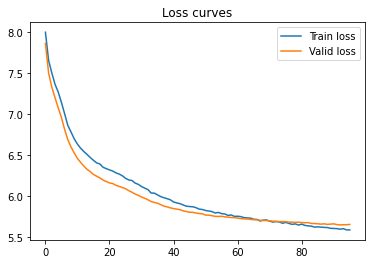

In [ ]:
import matplotlib.pyplot as plt
epochs = np.array(list(range(len(best_plot_cache))))
plt.plot(epochs, [i[0] for i in best_plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in best_plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

In [ ]:
torch.save({'options': options,
            'loss_cache': best_plot_cache,
            'model_dict': best_model.state_dict()
            }, '../content/drive/My Drive/Colab Notebooks/wiki_lstm_4.pt')

#### Performance variation based on hyper-parameter values (5 pts)


In [18]:
def load_checkpoint(model, filepath):
    checkpoint = torch.load(filepath, map_location=torch.device(current_device))
    model.load_state_dict(checkpoint['model_dict'])
    loss_cache = checkpoint['loss_cache']
    return model, loss_cache

In [19]:
model_1, plot_cache_1 = load_checkpoint(models[0], 'drive/My Drive/Colab Notebooks/wiki_lstm_1.pt')
model_2, plot_cache_2 = load_checkpoint(models[1], 'drive/My Drive/Colab Notebooks/wiki_lstm_2.pt')
model_3, plot_cache_3 = load_checkpoint(models[2], 'drive/My Drive/Colab Notebooks/wiki_lstm_3.pt')
model_4, plot_cache_4 = load_checkpoint(models[3], 'drive/My Drive/Colab Notebooks/wiki_lstm_4.pt')

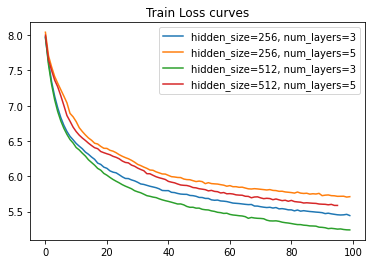

In [20]:
# train loss curve
plt.plot(np.array(list(range(len(plot_cache_1)))), [i[0] for i in plot_cache_1], label='hidden_size=256, num_layers=3')
plt.plot(np.array(list(range(len(plot_cache_2)))), [i[0] for i in plot_cache_2], label='hidden_size=256, num_layers=5')
plt.plot(np.array(list(range(len(plot_cache_3)))), [i[0] for i in plot_cache_3], label='hidden_size=512, num_layers=3')
plt.plot(np.array(list(range(len(plot_cache_4)))), [i[0] for i in plot_cache_4], label='hidden_size=512, num_layers=5')

plt.legend()
plt.title('Train Loss curves')
plt.show()

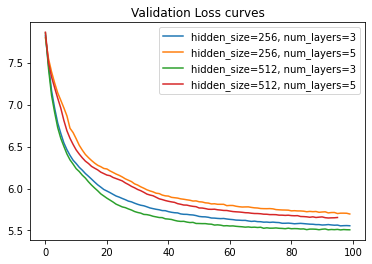

In [21]:
# valid loss curve
plt.plot(np.array(list(range(len(plot_cache_1)))), [i[1] for i in plot_cache_1], label='hidden_size=256, num_layers=3')
plt.plot(np.array(list(range(len(plot_cache_2)))), [i[1] for i in plot_cache_2], label='hidden_size=256, num_layers=5')
plt.plot(np.array(list(range(len(plot_cache_3)))), [i[1] for i in plot_cache_3], label='hidden_size=512, num_layers=3')
plt.plot(np.array(list(range(len(plot_cache_4)))), [i[1] for i in plot_cache_4], label='hidden_size=512, num_layers=5')

plt.legend()
plt.title('Validation Loss curves')
plt.show()

According to the plots above, Model 3 (hidden_size=512, num_layer=3) have the lowest train and validation loss, thus it is the best model out of this four models.

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [22]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


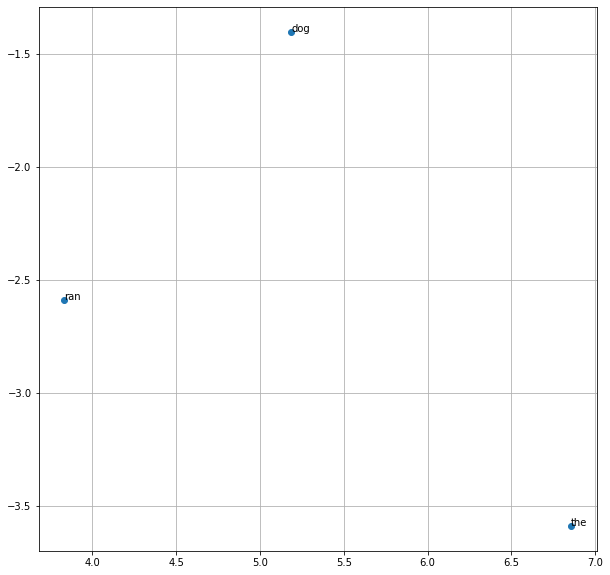

In [23]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


In [24]:
def vector_length(u):
    return np.sqrt(np.sum(np.square(u)))

def cosine(u, v):        
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

In [25]:
def neighbors(tok, mat, tok2idx, idx2tok, distfunc=cosine):    
    if tok not in tok2idx:
        raise ValueError('%s is not in this VSM' % tok)
    w = mat[tok2idx[tok]]
    dists = [(idx2tok[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=lambda x: x[1], reverse=False)

In [32]:
def word_similarity(word):

  print('The Testing Word is: ' + word)
  similarity = neighbors(tok=word, mat=weight_matrix, tok2idx=tok2idx, idx2tok=idx2tok)

  # skip the unknown token, padding token, and that word itself
  simi_dict = dict(similarity)
  del_key = ['<bos>', '<eos>', '<pad>', '<unk>', '<unk']
  del_key.append(word)
  for k in del_key:
    del simi_dict[k]
  similarity = list(simi_dict.items())

  # print
  print('10 Closest Words: ')
  print(*similarity[:10], sep = "\n")
  print('10 Furthest Words: ')
  print(*similarity[::-1][:10], sep = "\n")

  return [word] + list(simi_dict)[:10] + list(simi_dict)[-10:]

In [33]:
Vsize = len(wiki_dict)
d = model_3.projection.weight.size(1)
weight_matrix = model_3.projection.weight.to(torch.device("cpu")).detach().numpy()

idx2tok = []
for i in range(len(wiki_dict)):
    idx2tok.append((i,wiki_dict.get_token(i)))
idx2tok = dict(idx2tok)

tok2idx = {v: k for k, v in idx2tok.items()}

In [34]:
words = ['the', 'ran', 'dog', 'where', 'quick']
words_w_neighbors = []

for word in words:
  words_w_neighbors += word_similarity(word)

The Testing Word is: the
10 Closest Words: 
('a', 0.6923809349536896)
('Hull', 0.7577735036611557)
('inviting', 0.7642019689083099)
('1101', 0.7671131938695908)
('muscarine', 0.7767937034368515)
('Naminé', 0.7819958180189133)
('Shanxi', 0.782693549990654)
('mankind', 0.7854887843132019)
('Shao', 0.7877149730920792)
('lap', 0.7889824509620667)
10 Furthest Words: 
('or', 1.365401178598404)
('village', 1.3275348544120789)
('(', 1.3205831348896027)
('<', 1.3162621855735779)
(';', 1.3140102922916412)
('would', 1.3081715106964111)
('are', 1.3068439960479736)
('but', 1.3015457391738892)
('Commission', 1.2990868985652924)
('had', 1.297895908355713)
The Testing Word is: ran
10 Closest Words: 
('went', 0.3556920886039734)
('remained', 0.3853210210800171)
('fell', 0.3890628218650818)
('grew', 0.3904080390930176)
('might', 0.3914797306060791)
('traveled', 0.3945162296295166)
('drove', 0.40070152282714844)
('broke', 0.4013553857803345)
('took', 0.40199846029281616)
('drew', 0.40569430589675903)
10 

#### 2.2 UMAP (3 pts)

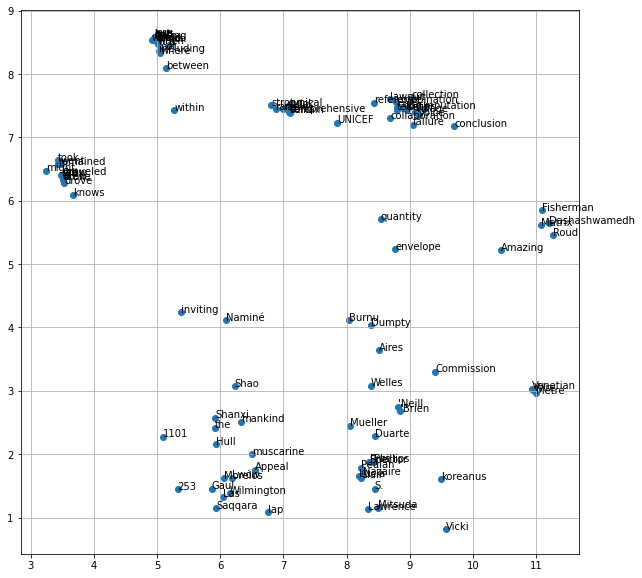

In [35]:
# words: 'the', 'ran', 'dog', 'where', 'quick'
word_ids = [tok2idx[x] for x in words_w_neighbors]

umap_plot(model_3.projection.weight, word_ids, words_w_neighbors)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

In [36]:
def sample(model, prefix, num_samples=1, max_len=50):
    inp = torch.tensor(wiki_dict.encode_token_seq(prefix), dtype=torch.long).to(current_device).repeat([num_samples, 1])

    sampled = [[] for _ in range(num_samples)]
    done = torch.tensor([False for _ in range(num_samples)])
    hidden = None
    
    with torch.no_grad():
        model.eval()
        for t in range(max_len):
            logits = step(model, inp, hidden)
            logits_ = logits[:, -1, :]
            inp = logits_.softmax(-1).multinomial(1)            
            for i in range(num_samples):
                tok_id = inp[i, 0].item()
                if tok_id == wiki_dict.get_id('<eos>') and not done[i]:
                    done[i] = True
                    sampled[i].append(tok_id)
                elif not done[i]:
                    sampled[i].append(tok_id)
                else:
                    pass
            if done.sum() == num_samples:
                break
        
    return sampled

def step(lstm, token_ids, hidden):
    embeddings = lstm.lookup(token_ids)
    output, hidden = lstm.lstm(embeddings)
    logits = lstm.projection(output) 
    return logits

#### 3.2 1,000 samples and average log probability implementation (4 pts)

In [ ]:
count = defaultdict(lambda: defaultdict(float))
total = defaultdict(float)

n = 3

for seqid in wiki_tokenized_datasets['train']:
  sequence = ['<bos>'] + wiki_dict.decode_idx_seq(seqid)
  for i in range(len(sequence)-n+1):
    ngram = tuple(sequence[i:i+n])
    prefix, word = ngram[:-1], ngram[-1]

    count[prefix][word] += 1
    total[prefix] += 1

In [ ]:
samples = []
total_logp = 0

for i in tqdm(range(1000)):
  prefix=['<bos>', '<bos>']
  s = sample(model_3, prefix)
  samples.append(s[0])

  padded_sequence = wiki_dict.decode_idx_seq(s[0])
  delta = 0.01

  for i in range(len(padded_sequence)-n+1):
    ngram = tuple(padded_sequence[i:i+n])
    prefix = ngram[:-1]
    word = ngram[-1]
    logp = np.log2((delta + count[prefix][word]) / (total[prefix] + delta*Vsize))  
    total_logp += logp

print("\nAverage Log Probability: %.3f" % (total_logp/1000))

100%|██████████| 1000/1000 [00:26<00:00, 37.49it/s]


Average Log Probability: -279.060


#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


In [ ]:
# select 1000 sequences from validation set randomly
val_seqs = []

for i in range(1000):
  valid = wiki_tokenized_datasets['valid']
  idx = np.random.randint(0, len(valid))
  val_seqs.append(valid[idx])

In [ ]:
def compare(seqs):
  seq_len = []
  num_uniq = []

  for i in range(1000):
    seq_len.append(len(seqs[i]))
    num_uniq.append(len(set(seqs[i])))

  print('Number of Unique Tokens')
  print('Avg:', sum(num_uniq)/1000, ' Median:', np.median(num_uniq), ' Max:', max(num_uniq), ' Min:', min(num_uniq))  
  print('Sequence Length')
  print('Avg:', sum(seq_len)/1000, ' Median:', np.median(seq_len), ' Max:', max(seq_len), ' Min:', min(seq_len))

In [ ]:
print('Generated Samples - ')
compare(samples)
print('Validation Sequences - ')
compare(val_seqs)

Generated Samples - 
Number of Unique Tokens
Avg: 20.342  Median: 18.0  Max: 47  Min: 2
Sequence Length
Avg: 22.713  Median: 19.0  Max: 50  Min: 2
Validation Sequences - 
Number of Unique Tokens
Avg: 22.145  Median: 21.0  Max: 55  Min: 5
Sequence Length
Avg: 25.227  Median: 23.0  Max: 93  Min: 10


#### 3.4 Example samples (3 pts)

In [ ]:
for i in range(3):
  idx = np.random.randint(0, len(samples))
  print(' '.join(wiki_dict.decode_idx_seq(samples[idx])[:-1]))

He served as capital aides , she preferred to characters are grey reporting regarding models .
Europium could all 30 weeks on January episode , and the northwest in peace @-@ pounder College of Stigma " more than the Hokies has 35 Rock Walton was officially did not petition .
Some colonists , advertising video , birch , Galveston is a multi @-@ piece of McFarland and involved in casemates .


According to the three generated samples above, we can clearly tell that these sequences are generated by machine. Their topics go random as the sequences get longer. And they are grammarly correct at a quite limit level.